# Use POCA Ellipsoid info to match Tracks to Primary Vertices
_____
The goal of this notebook is to attempt to match tracks to primary vertices using the mean and widths of the POCA error ellipsoids

## Combining Error Ellipses
___
This link goes through the derivation of how to combine error ellipses in full detail (https://cxc.cfa.harvard.edu/csc/memos/files/Davis_ellipse.pdf), although I will summarize below.

In one dimension, we would compute the center as a weighted average, with weights $w_a$ and sum of weights $w$:

$\bar{x} = \frac{1}{w}\sum_{a} w_a \bar{x}_a$.

In our case, since we are dealing with points with associated errors, we want points with lower error to be weighted higher, so we can use the inverse variance to compute this:

$\bar{x} = \text{Var}(\bar{x})\sum_{a} \text{Var}^{-1}(\bar{x}_a) \bar{x}_a$.

Here, $\text{Var}(\bar{x})$ is calculated as

$\text{Var}(\bar{x}) = \Big[\sum_{a}\text{Var}^{-1}(\bar{x}_a)\Big]^{-1}$.

In the multivariate case, we are dealing with error matrices instead of just error values. Therefore we will perform the same calculation, but with inverting the matrices ($\sigma_a$ represents each individual error matrix):

$\bar{x} = \sigma\sum_{a} \sigma_a^{-1} \bar{x}_a$

and then for $\sigma$,

$\sigma = \Big[\sum_a \sigma_a^{-1}\Big]^{-1}$.

In order to find the major axis, minor axis 1, and minor axis 2, it suffices to find the eigenvectors and associated eigenvalues of the combined error ellipse, scaling the eigenvectors by the eigenvalues.

However in practice, this has resulted in confusing results, which probably warrant further investigation. Since the volume of an error ellipse is proportional to the determinant of its error matrix, computing a weighted average using the volume appears to be a good approximation.

___
<span style="color: blue;">First, let's check to see which GPUs are currently being used:</span>

In [1]:
!nvidia-smi

Wed Jul 21 13:30:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   37C    P8    39W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

___
<span style="color: blue;">Now, we can select which machine we want to use:</span>

In [2]:
from model.training import select_gpu
device = select_gpu(-1)

___
<span style="color: blue;">Here, we import everything we need. The ellipsoid functions imported from model.plots_mdsA_200518 are originally from the Towards_Ellipsoids_*.ipynb notebooks. The model used in this notebook is the four-feature, 6-layer CNN.</span>

In [3]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import numpy as np
import torch
import math as m
import warnings
import numba
try:
    import awkward0 as awkward
except ModuleNotFoundError:
    import awkward
concatenate = awkward.concatenate
from matplotlib.patches import Ellipse
import sys
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as p

from scipy.optimize import curve_fit

# This can throw a warning about float - let's hide it for now.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    import h5py

#local imports
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
from model.collectdata_poca_KDE import collect_data_poca
from model.collectdata_sakar_TPVA import collect_truth
from model.plots_emk_200518 import plot_ruiplot
from model.poca_data_manipulation import gaussian, collect_poca, plotEllipses, plot_combined_ellipse, combine_ellipsoids, combine_ellipsoids_approx
from model.efficiency_res_optimized import get_std_resolution
from model.efficiency import pv_locations, efficiency
from model.core import modernize

In [4]:
def gauss_fitfunction(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

___
<span style="color: blue;">Now, we load our validation dataset, using the method imported from model.collectdata_poca_KDE. Masking is set to True, and shuffle is set to False in order to retain the order of events. The device is set to that which we previously specified.</span>

In [5]:
#specify the path to the dataset (here, dataAA is a symlink to /share/lazy/sokoloff/ML-data_AA)
#file = '/share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
#file = '/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5'
file = '/share/lazy/sakar/ML_data/pv_HLT1CPU_MinBiasMagUp_TPVA.h5'
validation = collect_data_poca(file,
                          batch_size=1,
                          slice=slice(10000),
                          #slice=slice(500),
                          masking=True, shuffle=False,
                          #device=device,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sakar/ML_data/pv_HLT1CPU_MinBiasMagUp_TPVA.h5 in 15.97 s
Constructing 10000 event dataset took 0.1553 s


In [6]:
pocas, track_matches = collect_poca(file)

<KeysViewHDF5 ['Xmax', 'Ymax', 'kernel', 'major_axis_x', 'major_axis_y', 'major_axis_z', 'minor_axis1_x', 'minor_axis1_y', 'minor_axis1_z', 'minor_axis2_x', 'minor_axis2_y', 'minor_axis2_z', 'poca_KDE_A', 'poca_KDE_A_xMax', 'poca_KDE_A_yMax', 'poca_KDE_B', 'poca_KDE_B_xMax', 'poca_KDE_B_yMax', 'poca_x', 'poca_y', 'poca_z', 'pv', 'pv_cat', 'pv_key', 'pv_loc', 'pv_loc_x', 'pv_loc_y', 'pv_ntracks', 'pv_other', 'recon_pv_key', 'recon_tx', 'recon_x', 'recon_y', 'recon_z', 'sv', 'sv_cat', 'sv_loc', 'sv_loc_x', 'sv_loc_y', 'sv_ntracks', 'sv_other']>
['1' '3' 'schema.json']


___
<span style="color: blue;">Now we load the Xmax and Ymax arrays from the hdf5 file:</span>

In [7]:
with h5py.File(file, mode='r') as XY:
    #assign numpy arrays corresponding to xmax and ymax
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

___
<span style="color: blue;">Now we collect the truth information from the hdf5 file corresponding to the primary vertices (pvs = True) and print some examples.</span>

In [8]:
PV = collect_truth(file, pvs=True)
ind = 0
print('PV.n.shape =    ',  PV.n.shape)
print(f'PV.n[{ind}].shape = ', *PV.n[ind].shape)
print(f'PV.x[{ind}] =       ', *PV.x[ind])
print(f'PV.y[{ind}] =       ', *PV.y[ind])
print(f'PV.z[{ind}] =       ', *PV.z[ind])
print(f'PV.n[{ind}] =       ', *PV.n[ind])
print(f'PV.cat[{ind}] =     ', *PV.cat[ind])
print(f'PV.key[{ind}] =     ', *PV.key[ind])

Loaded /share/lazy/sakar/ML_data/pv_HLT1CPU_MinBiasMagUp_TPVA.h5 in 0.02991 s
PV.n.shape =     (51980,)
PV.n[0].shape =  11
PV.x[0] =        -0.0396 0.0155 0.0043 -0.0027 0.0548 0.0204 -0.0377 -0.0384 -0.0188 0.0136 -0.0047
PV.y[0] =        0.0095 -0.0427 0.005 -0.0105 -0.0134 0.0126 0.07 -0.0068 0.0239 -0.0223 -0.0323
PV.z[0] =        -13.2912 -3.9851 55.7932 -53.5683 12.2541 89.1668 -75.9433 29.4695 19.3484 74.7049 -22.578
PV.n[0] =        38 83 32 0 16 14 6 10 22 74 0
PV.cat[0] =      1 1 1 -1 1 1 1 1 1 1 -1
PV.key[0] =      0.0 75.0 286.0 372.0 373.0 412.0 452.0 483.0 521.0 602.0 759.0


___
<span style="color: blue;">We repeat the process for secondary vertices:</span>

In [9]:
SV = collect_truth(file, pvs=False)

Loaded /share/lazy/sakar/ML_data/pv_HLT1CPU_MinBiasMagUp_TPVA.h5 in 0.1706 s


___
<span style="color: blue;">Now we need to load the model:</span>

In [10]:
#specify name of trained model
name = '/share/lazy/sokoloff/ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name, map_location=torch.device('cpu'))
d = modernize(d, 3)

#load and evaluate model
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropou

___
<span style="color: blue;">Create numpy arrays corresponding to the outputs and labels of the model:</span>

In [11]:
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

___
<span style="color: blue;">Create numpy array corresponding to the test dataset:</span>

In [12]:
test = validation.dataset.tensors[0].cpu().numpy()
print('test.shape = ',test.shape)

test.shape =  (10000, 4, 4000)



Event 0: Found 9 of 9, added 1 (eff 100.00%)
Percentage Matched =  91.50943396226415 %


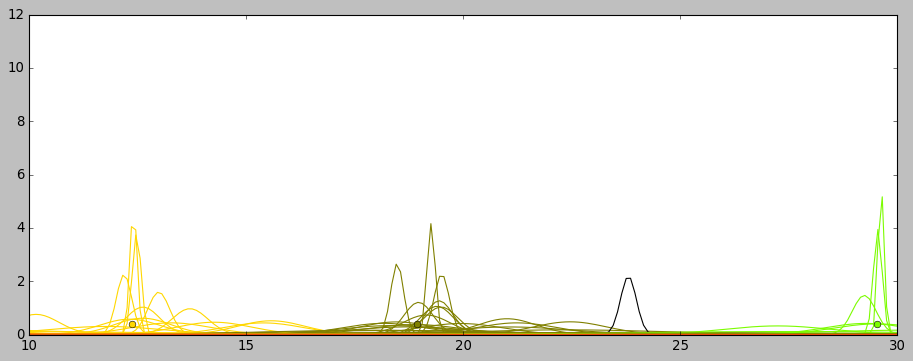

Number Correct:  268
Possible Number of Matches:  372

Event 1: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  68.05555555555556 %


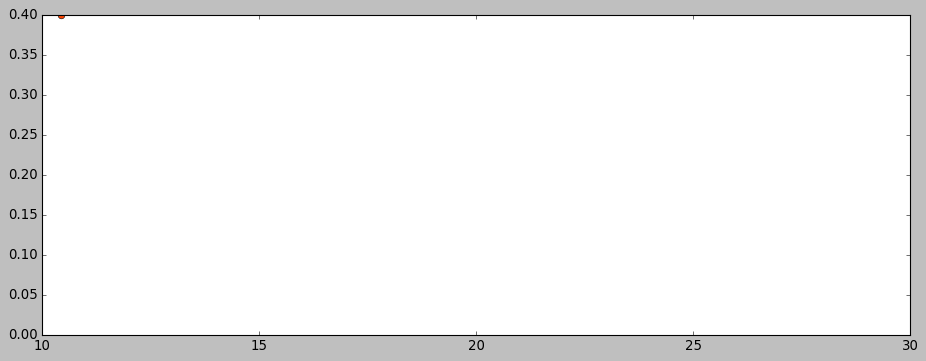

Number Correct:  172
Possible Number of Matches:  196

Event 2: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  32.47863247863248 %


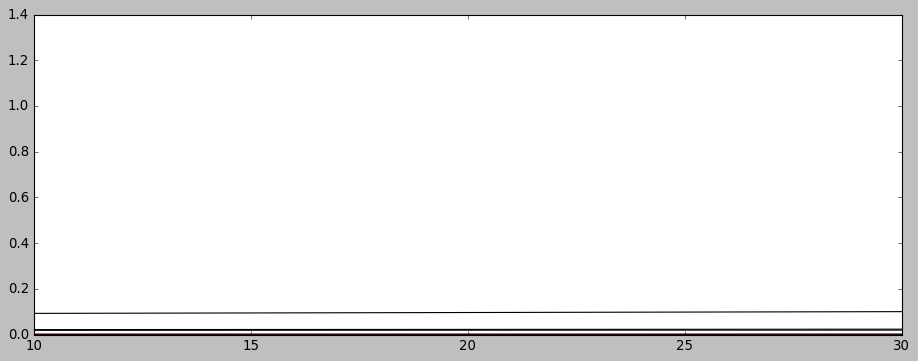

Number Correct:  106
Possible Number of Matches:  114

Event 3: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  71.1038961038961 %


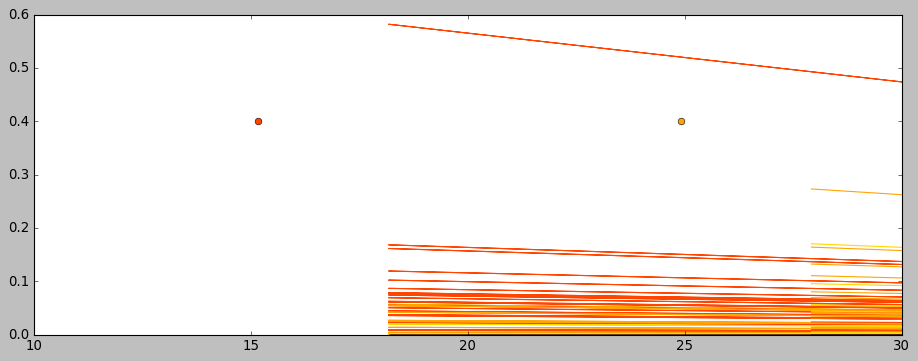

Number Correct:  190
Possible Number of Matches:  216

Event 4: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  87.25490196078431 %


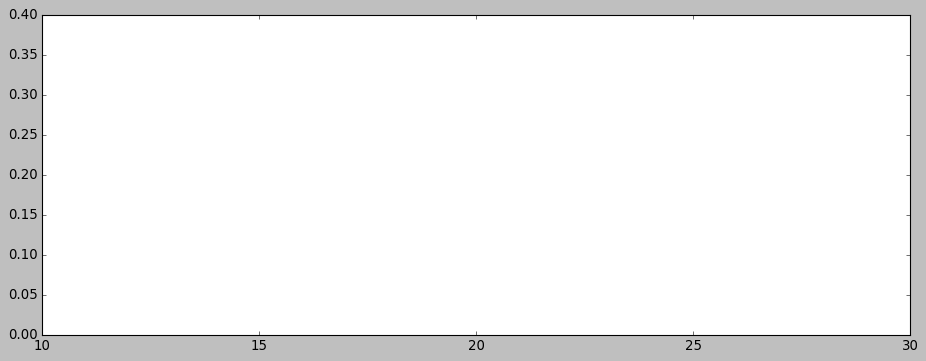

Number Correct:  132
Possible Number of Matches:  179

Event 5: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  84.67153284671532 %


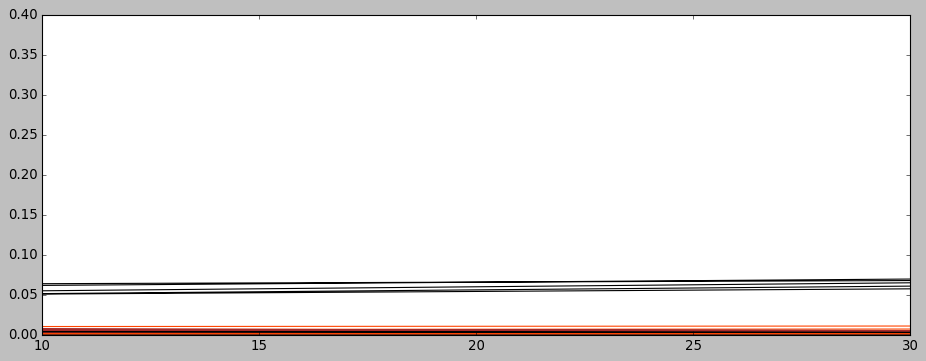

Number Correct:  222
Possible Number of Matches:  237

Event 6: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  92.07920792079207 %


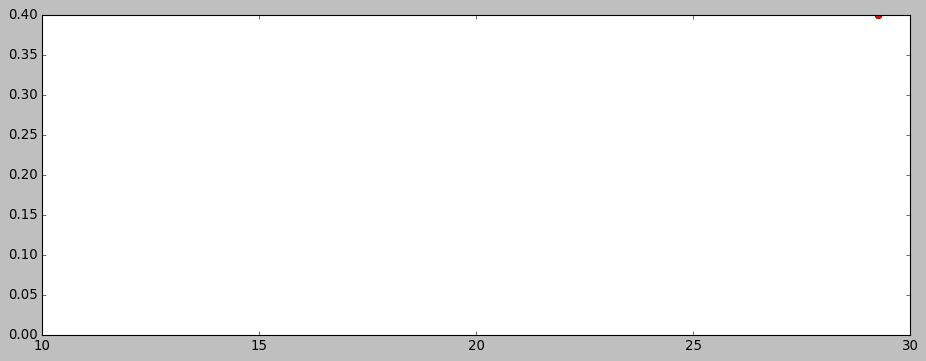

Number Correct:  172
Possible Number of Matches:  186

Event 7: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.15789473684211 %


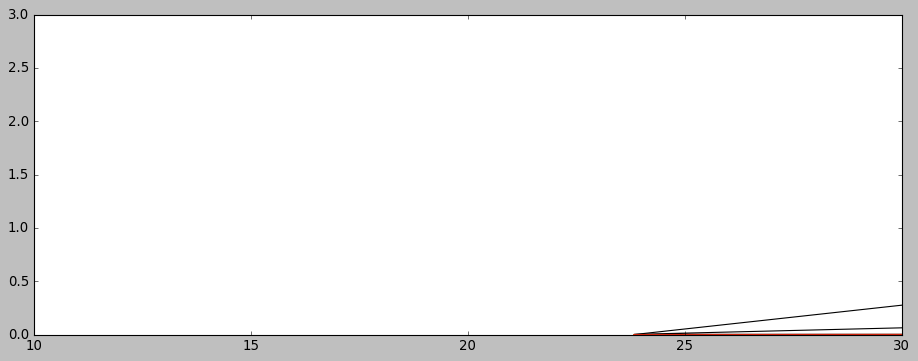

Number Correct:  127
Possible Number of Matches:  133

Event 8: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  87.03071672354949 %


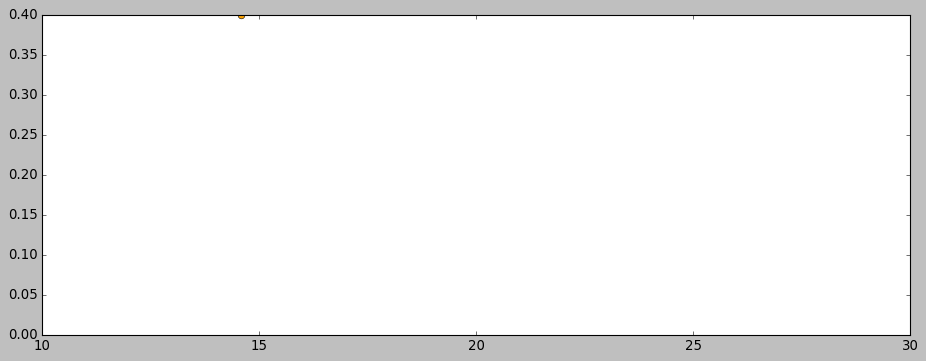

Number Correct:  225
Possible Number of Matches:  251

Event 9: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  65.98639455782313 %


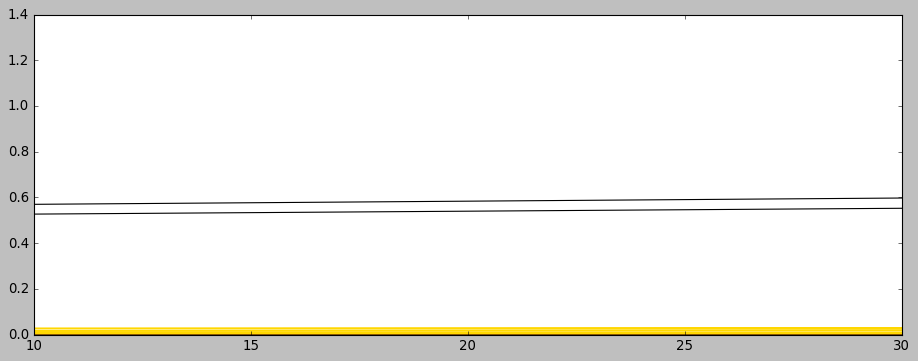

Number Correct:  180
Possible Number of Matches:  185

Event 10: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  78.46153846153847 %


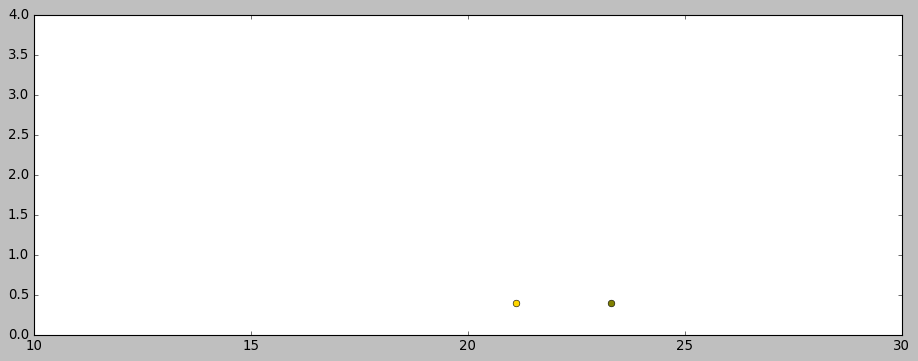

Number Correct:  125
Possible Number of Matches:  152

Event 11: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  89.55223880597015 %


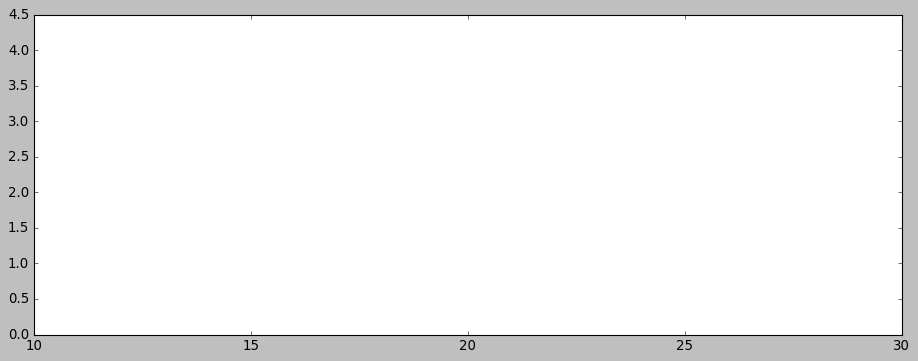

Number Correct:  315
Possible Number of Matches:  352

Event 12: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  85.29411764705883 %


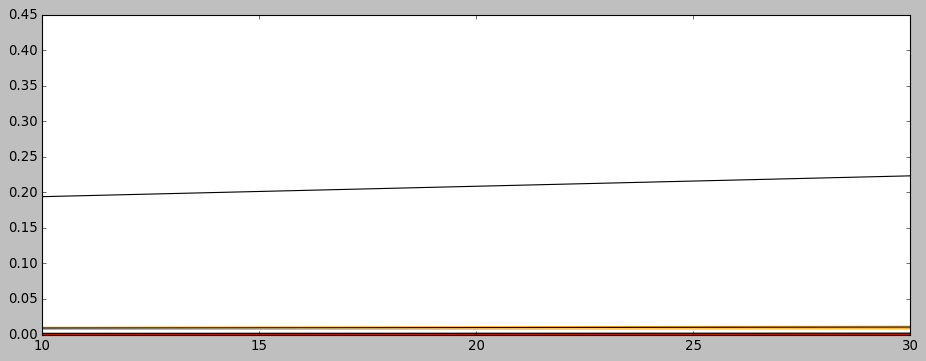

Number Correct:  53
Possible Number of Matches:  55

Event 13: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  72.04610951008645 %


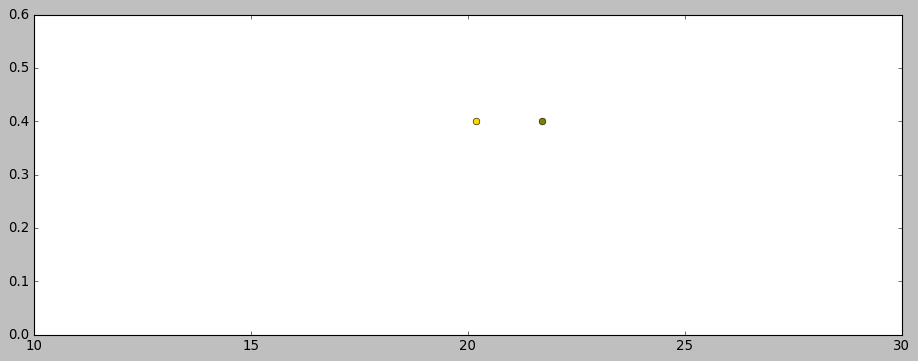

Number Correct:  222
Possible Number of Matches:  250

Event 14: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  92.41706161137441 %


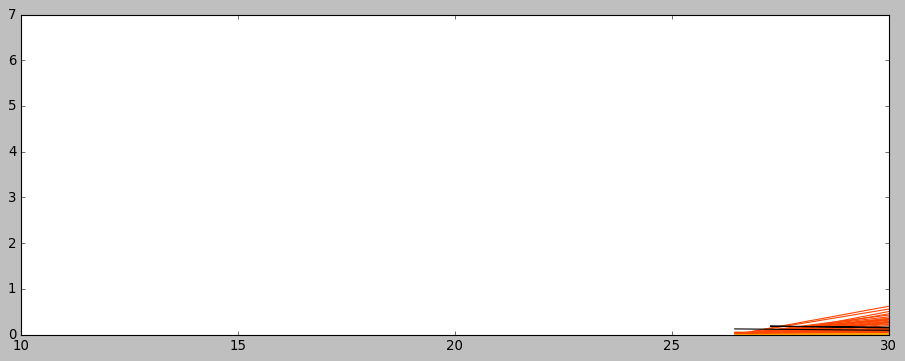

Number Correct:  159
Possible Number of Matches:  188

Event 15: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  86.83127572016461 %


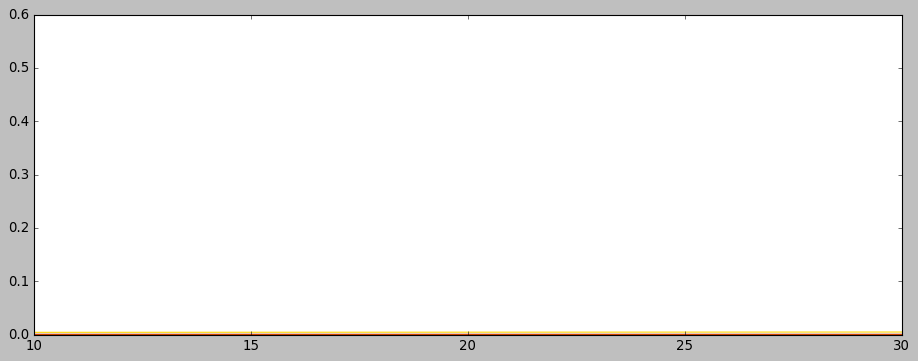

Number Correct:  200
Possible Number of Matches:  214

Event 16: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  64.28571428571429 %


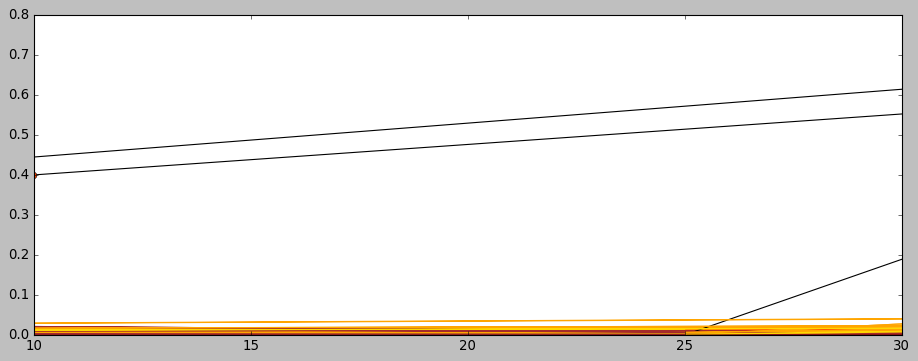

Number Correct:  130
Possible Number of Matches:  142

Event 17: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  91.51785714285714 %


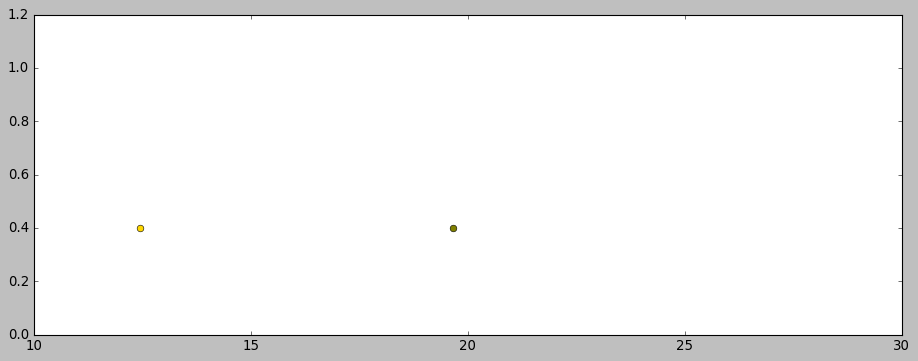

Number Correct:  186
Possible Number of Matches:  203

Event 18: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  57.923497267759565 %


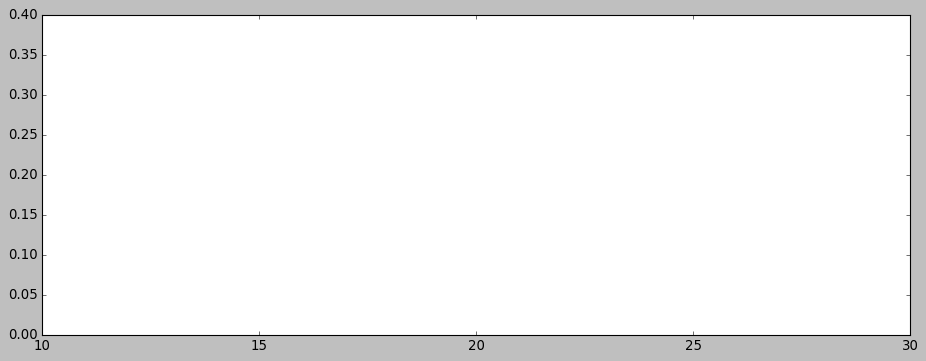

Number Correct:  94
Possible Number of Matches:  101

Event 19: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  88.75739644970415 %


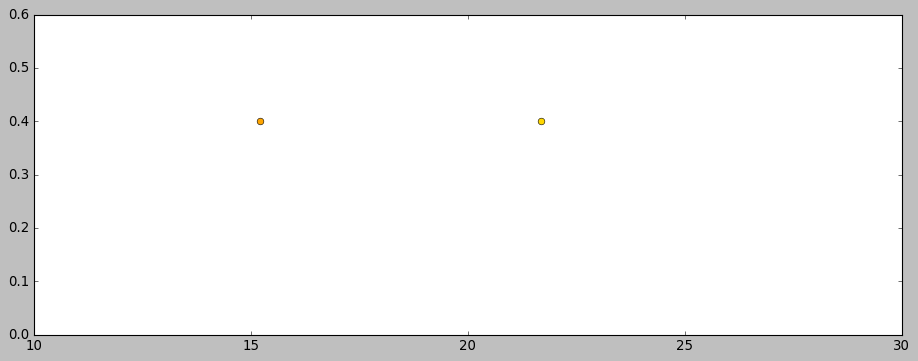

Number Correct:  117
Possible Number of Matches:  156

Event 20: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  89.60244648318043 %


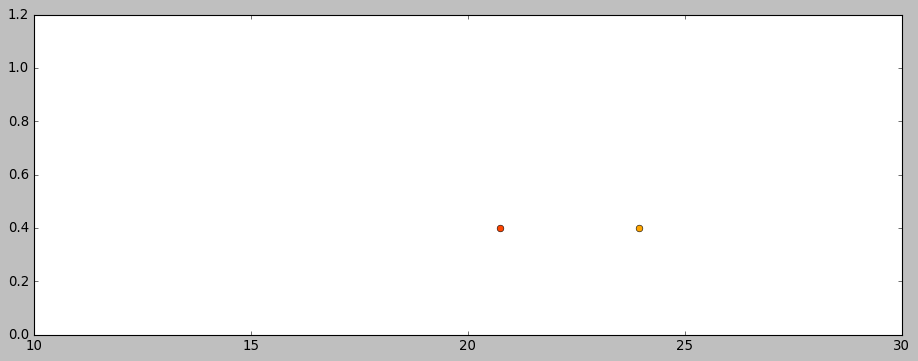

Number Correct:  257
Possible Number of Matches:  288

Event 21: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  91.3946587537092 %


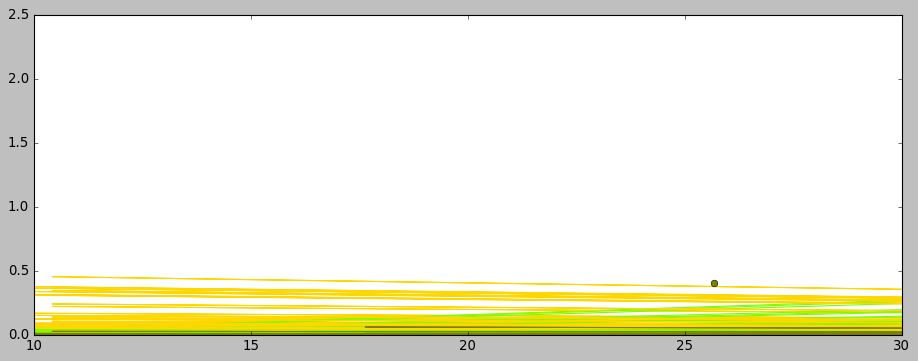

Number Correct:  287
Possible Number of Matches:  310

Event 22: Found 9 of 10, added 1 (eff 90.00%)
Percentage Matched =  84.78260869565217 %


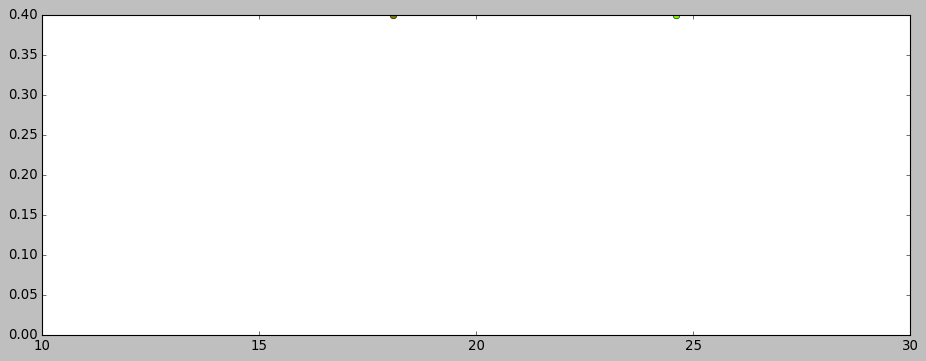

Number Correct:  209
Possible Number of Matches:  244

Event 23: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  91.91176470588235 %


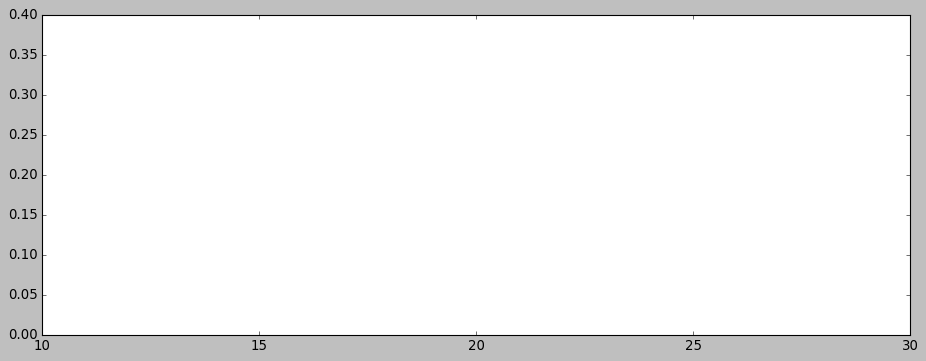

Number Correct:  121
Possible Number of Matches:  123

Event 24: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  87.59689922480621 %


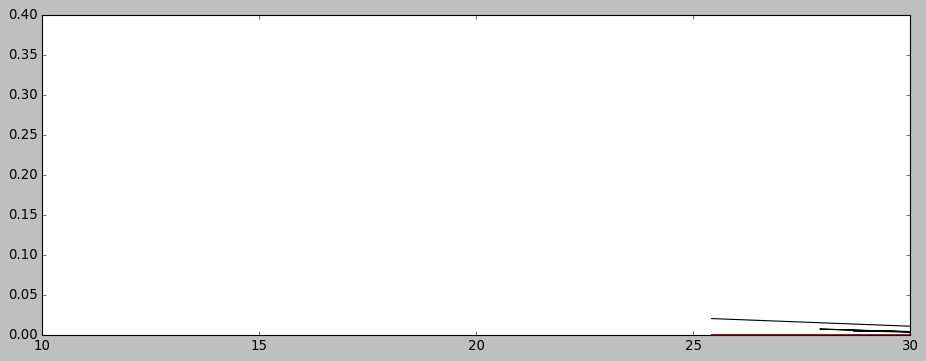

Number Correct:  109
Possible Number of Matches:  112

Event 25: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  87.73946360153256 %


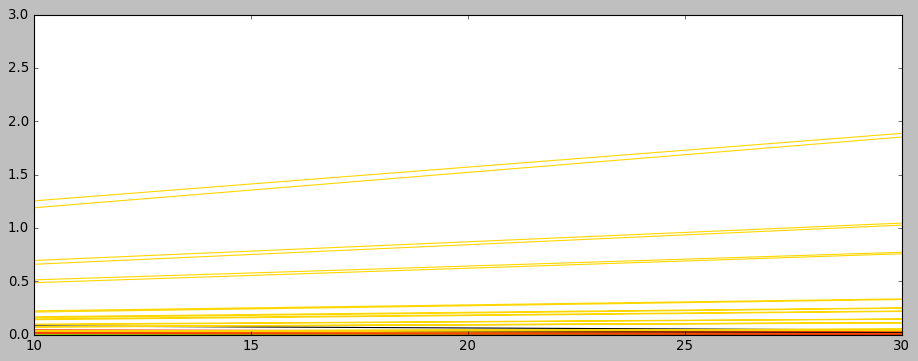

Number Correct:  209
Possible Number of Matches:  229

Event 26: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  72.88732394366197 %


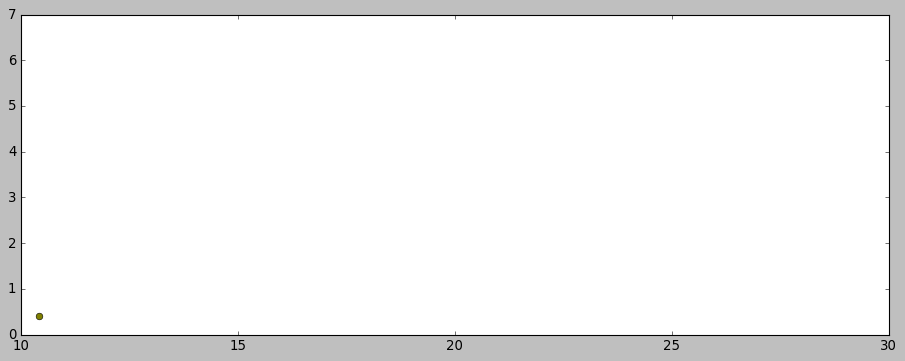

Number Correct:  192
Possible Number of Matches:  220

Event 27: Found 8 of 10, added 0 (eff 80.00%)
Percentage Matched =  88.97435897435898 %


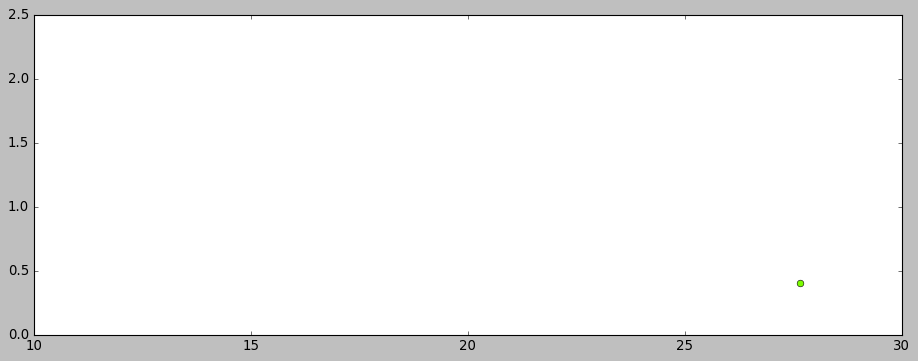

Number Correct:  294
Possible Number of Matches:  320

Event 28: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  81.09452736318408 %


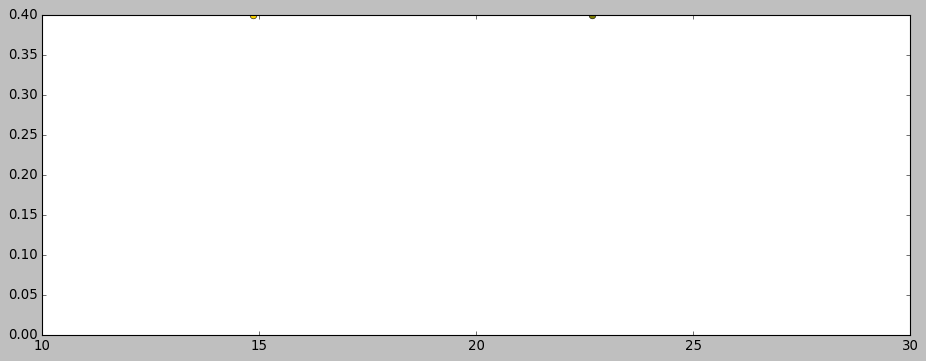

Number Correct:  287
Possible Number of Matches:  322

Event 29: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  92.16589861751152 %


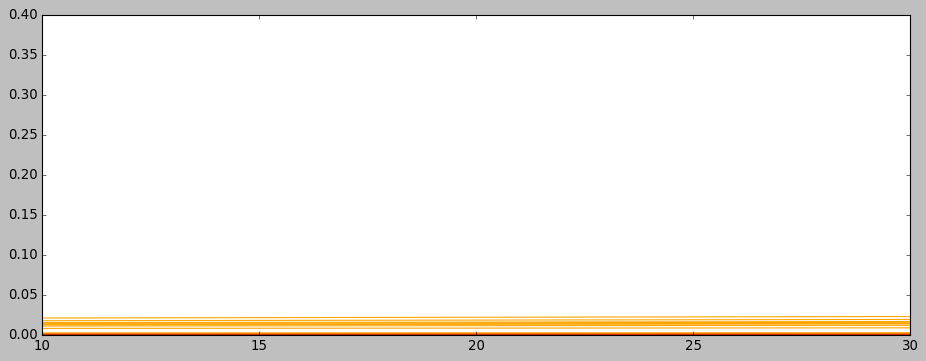

Number Correct:  168
Possible Number of Matches:  200

Event 30: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  72.58064516129032 %


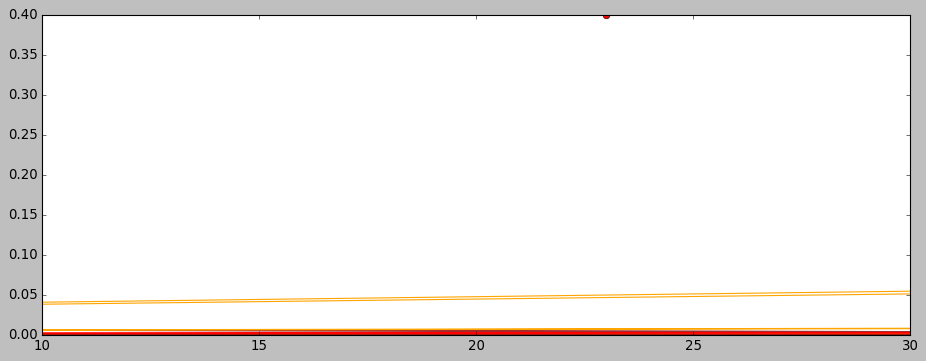

Number Correct:  81
Possible Number of Matches:  85

Event 31: Found 8 of 10, added 0 (eff 80.00%)
Percentage Matched =  86.81318681318682 %


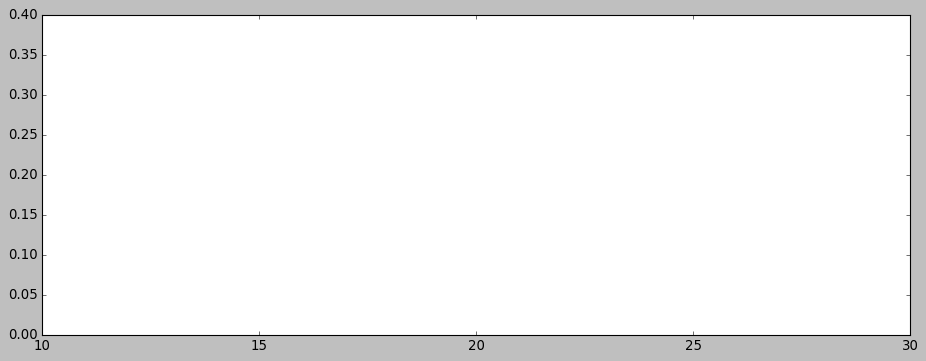

Number Correct:  285
Possible Number of Matches:  319

Event 32: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  87.90322580645162 %


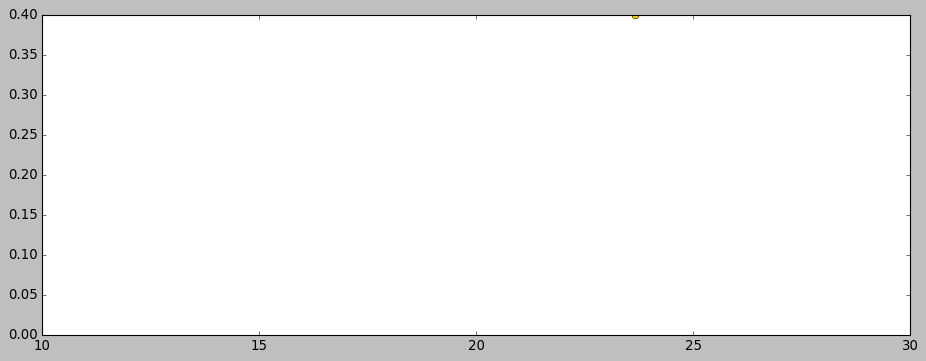

Number Correct:  295
Possible Number of Matches:  315

Event 33: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  84.91620111731844 %


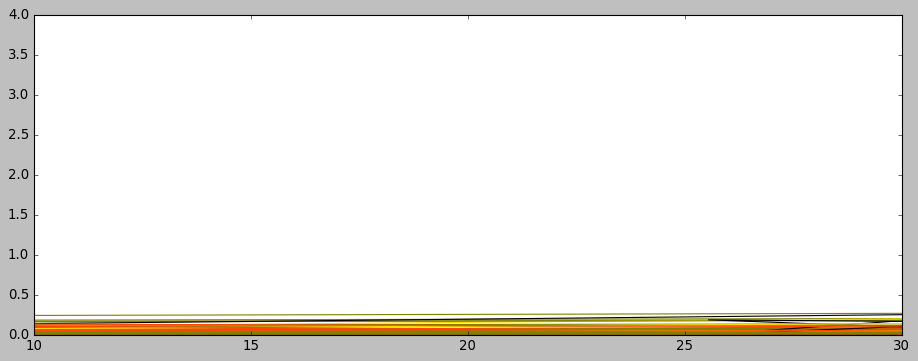

Number Correct:  269
Possible Number of Matches:  293

Event 34: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  89.95633187772926 %


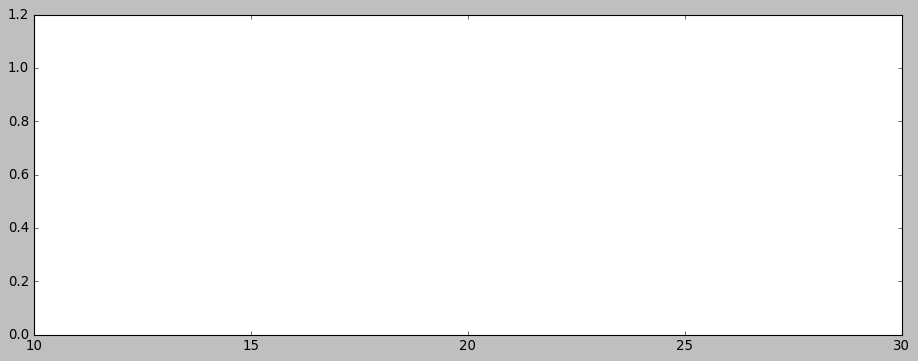

Number Correct:  200
Possible Number of Matches:  204

Event 35: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  88.73239436619718 %


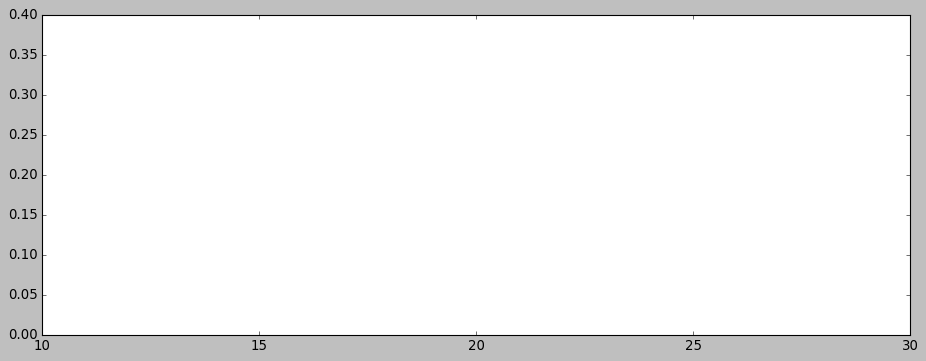

Number Correct:  56
Possible Number of Matches:  77

Event 36: Found 4 of 5, added 0 (eff 80.00%)
Percentage Matched =  82.87937743190662 %


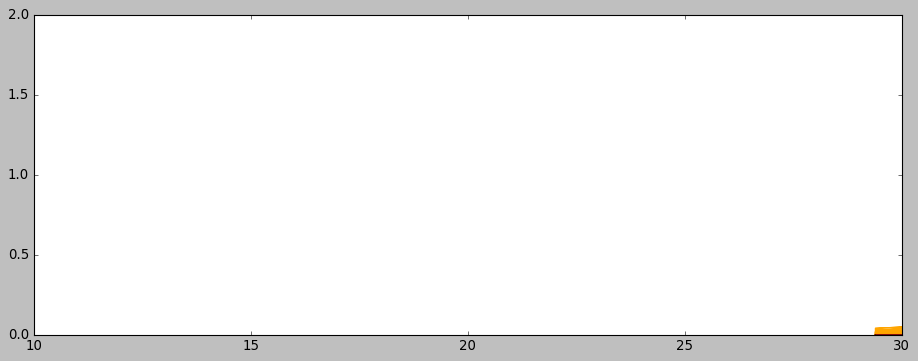

Number Correct:  197
Possible Number of Matches:  216

Event 37: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  82.97872340425532 %


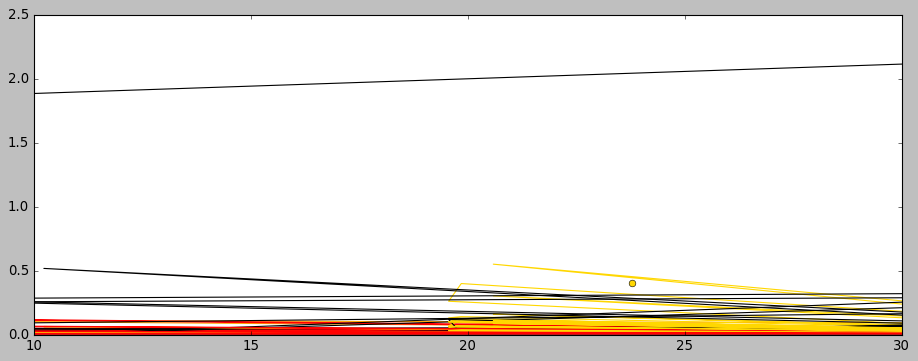

Number Correct:  244
Possible Number of Matches:  272

Event 38: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  90.7514450867052 %


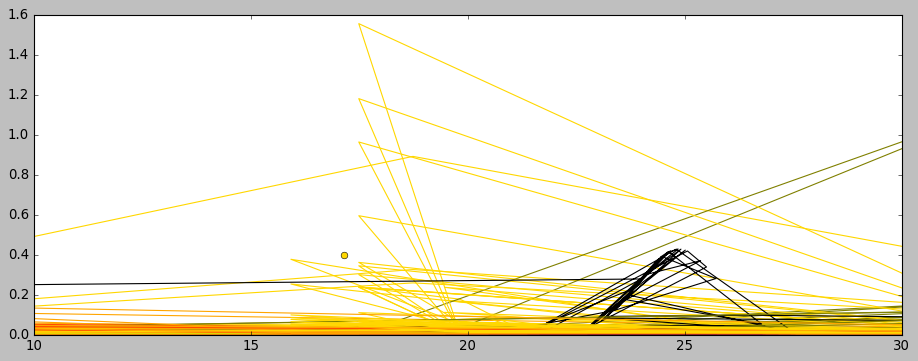

Number Correct:  291
Possible Number of Matches:  312

Event 39: Found 6 of 6, added 1 (eff 100.00%)
Percentage Matched =  88.80597014925372 %


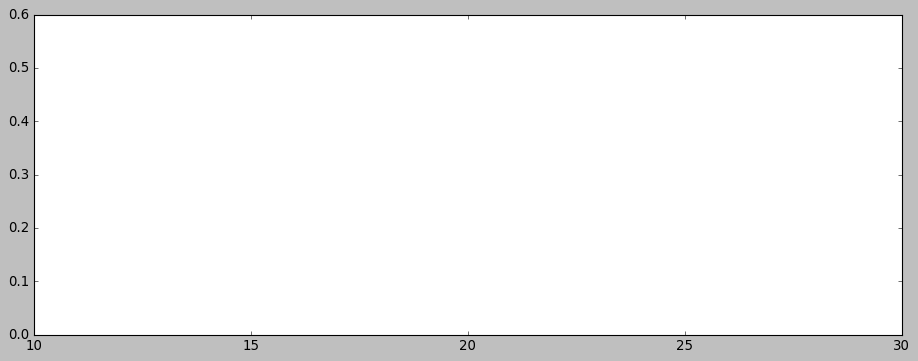

Number Correct:  326
Possible Number of Matches:  356

Event 40: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  93.5672514619883 %


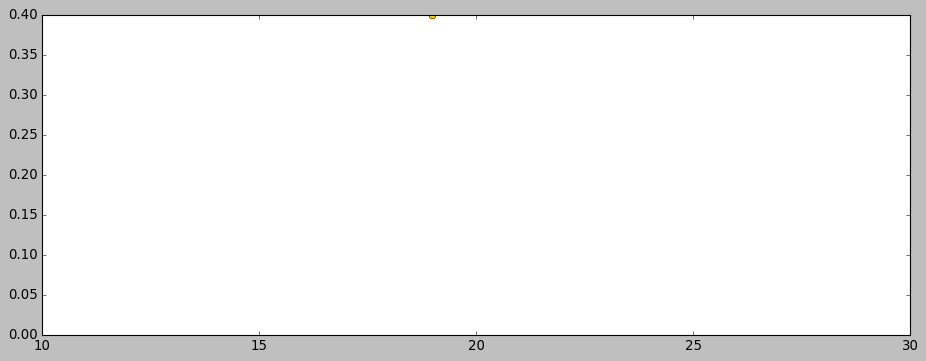

Number Correct:  153
Possible Number of Matches:  230

Event 41: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.16216216216216 %


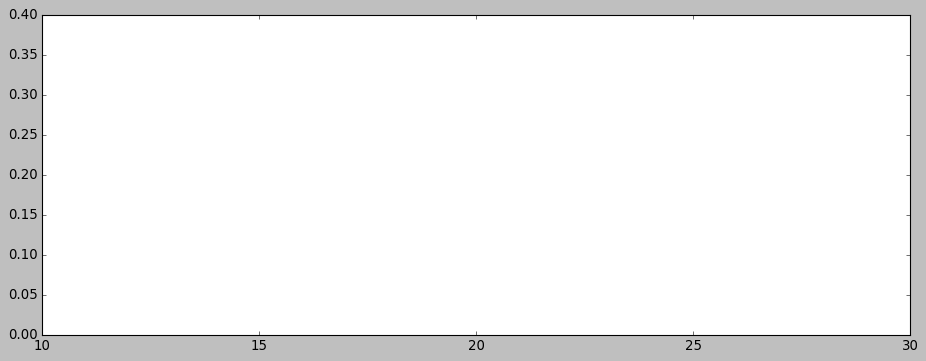

Number Correct:  117
Possible Number of Matches:  132

Event 42: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.20863309352518 %


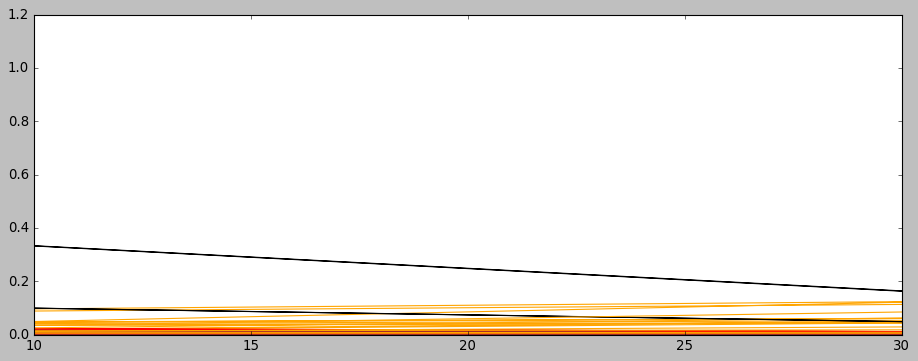

Number Correct:  121
Possible Number of Matches:  125

Event 43: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  87.62886597938144 %


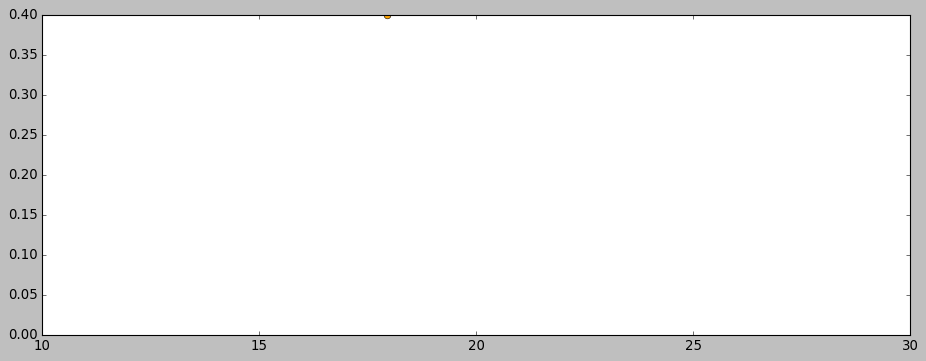

Number Correct:  161
Possible Number of Matches:  172

Event 44: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  85.03649635036497 %


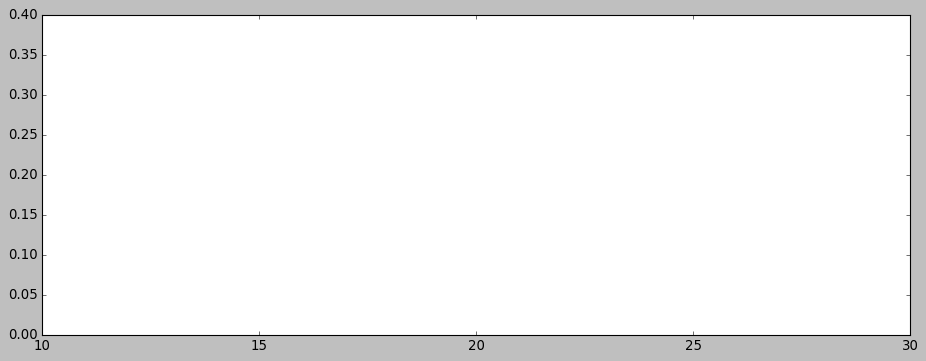

Number Correct:  218
Possible Number of Matches:  239

Event 45: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  59.2436974789916 %


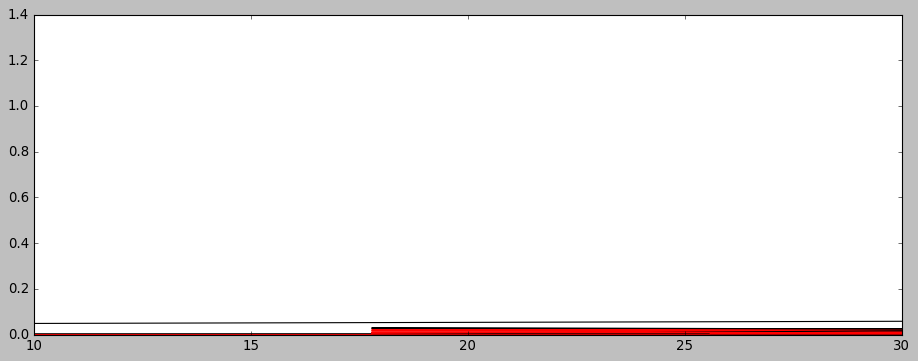

Number Correct:  119
Possible Number of Matches:  136

Event 46: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.41798941798942 %


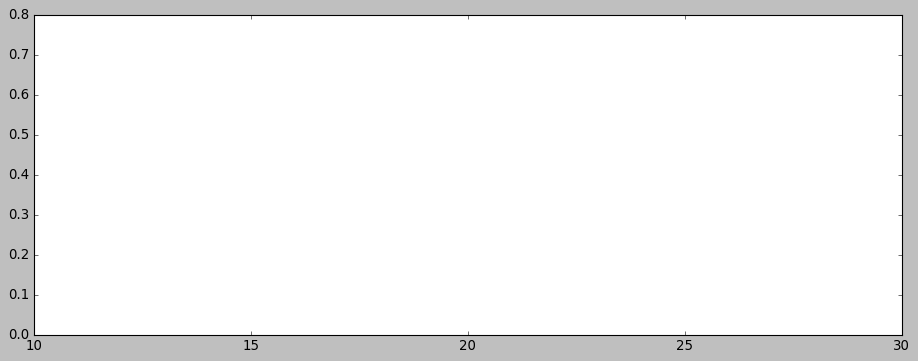

Number Correct:  166
Possible Number of Matches:  169

Event 47: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  86.19402985074628 %


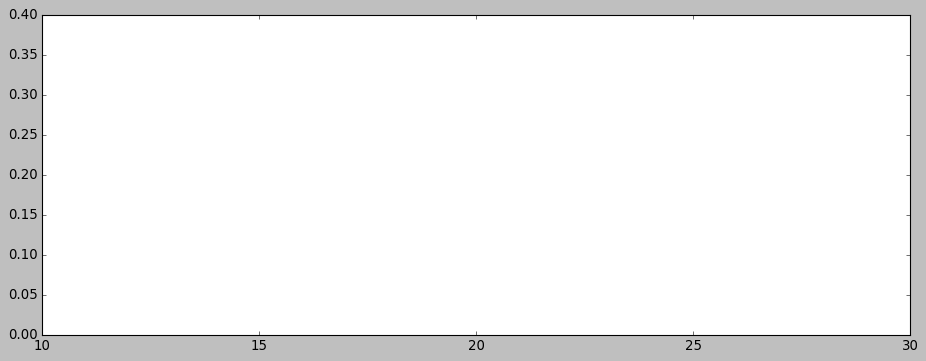

Number Correct:  214
Possible Number of Matches:  222

Event 48: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  87.64044943820225 %


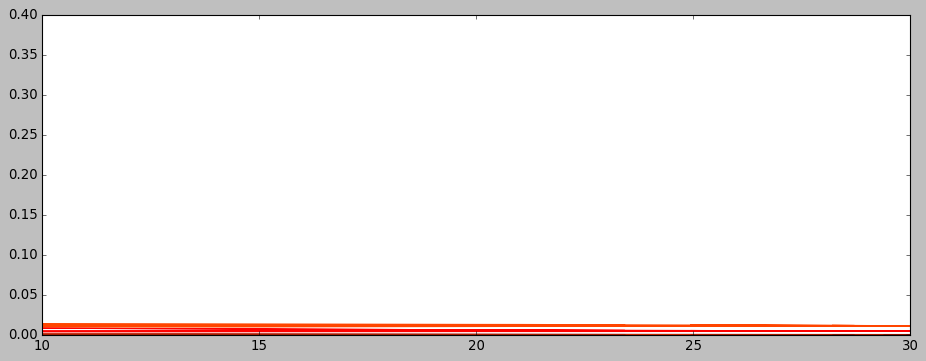

Number Correct:  70
Possible Number of Matches:  71

Event 49: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  77.43190661478599 %


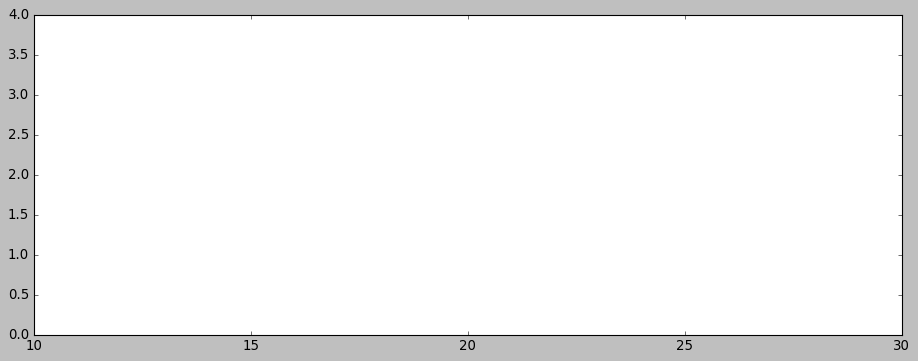

Number Correct:  148
Possible Number of Matches:  168

Event 50: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  89.37728937728937 %


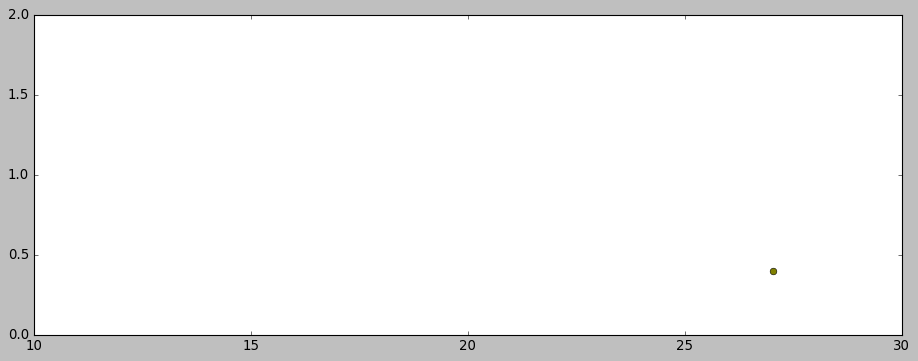

Number Correct:  229
Possible Number of Matches:  247

Event 51: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  84.58646616541354 %


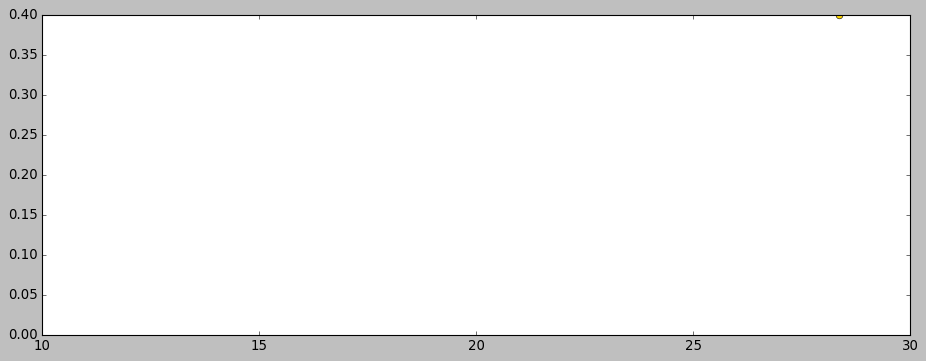

Number Correct:  206
Possible Number of Matches:  228

Event 52: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  85.83333333333333 %


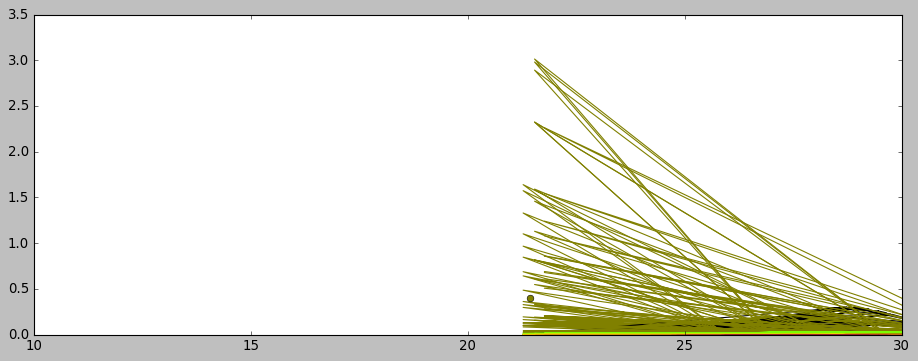

Number Correct:  145
Possible Number of Matches:  173

Event 53: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  85.60311284046692 %


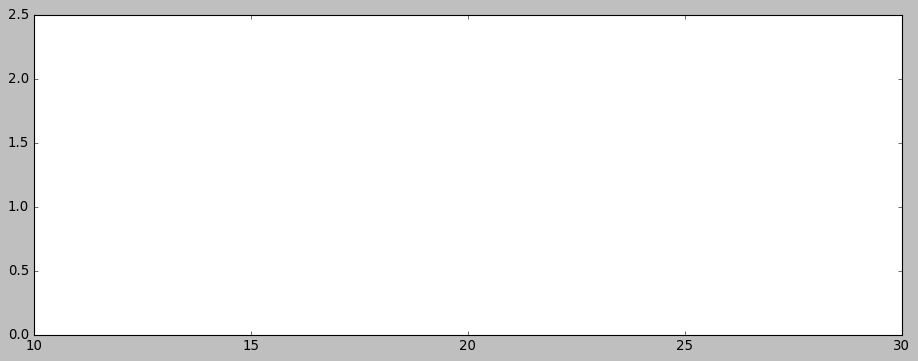

Number Correct:  208
Possible Number of Matches:  220

Event 54: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  85.5 %


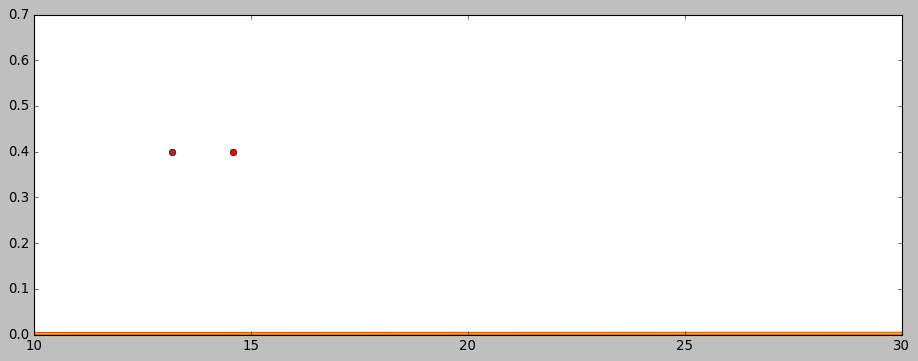

Number Correct:  152
Possible Number of Matches:  164

Event 55: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  91.005291005291 %


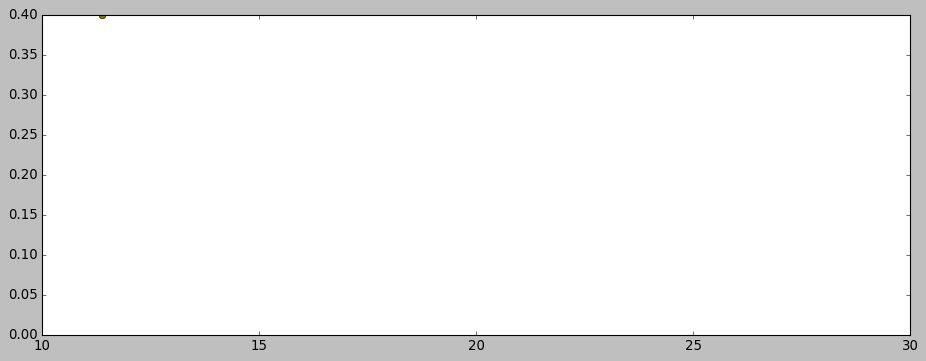

Number Correct:  150
Possible Number of Matches:  166

Event 56: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  93.85964912280701 %


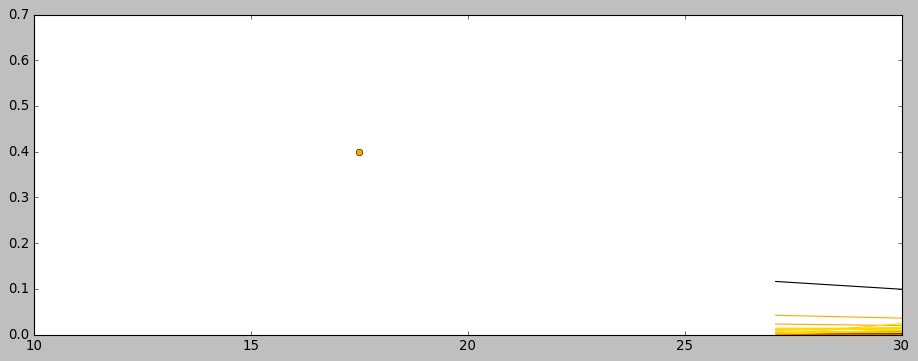

Number Correct:  204
Possible Number of Matches:  211

Event 57: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  89.29663608562691 %


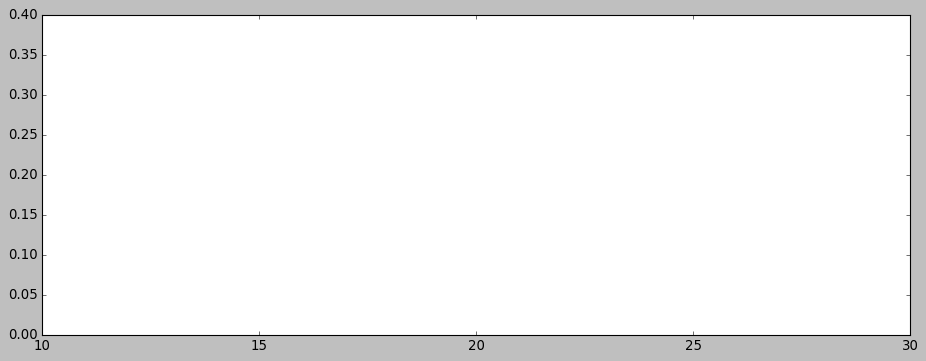

Number Correct:  272
Possible Number of Matches:  290

Event 58: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  76.70250896057348 %


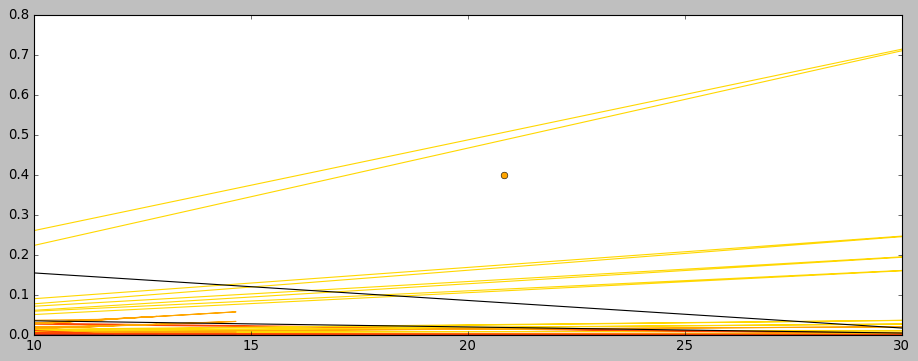

Number Correct:  204
Possible Number of Matches:  212

Event 59: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  86.29032258064517 %


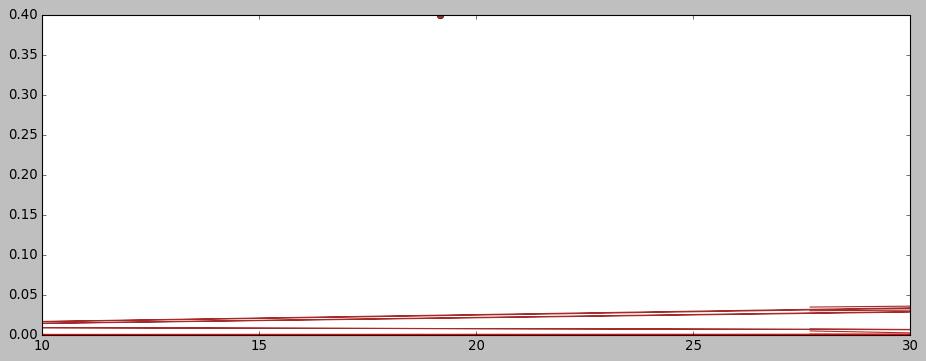

Number Correct:  102
Possible Number of Matches:  106

Event 60: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.937106918239 %


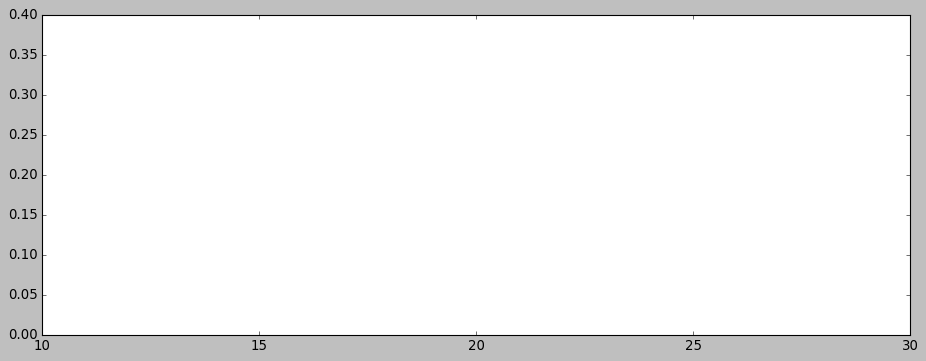

Number Correct:  134
Possible Number of Matches:  144

Event 61: Found 2 of 2, added 2 (eff 100.00%)
Percentage Matched =  90.75907590759076 %


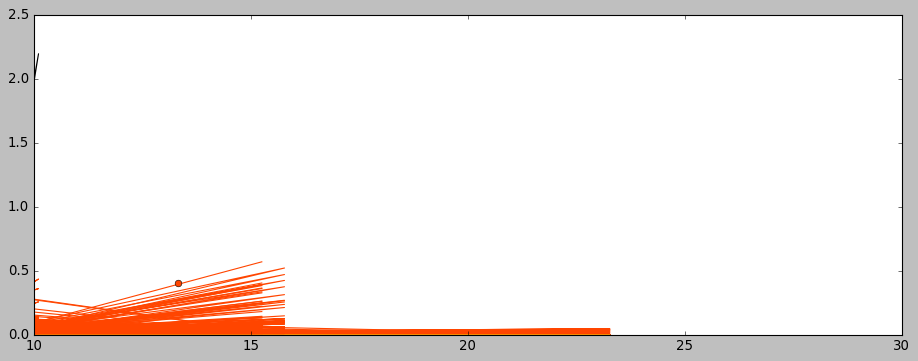

Number Correct:  266
Possible Number of Matches:  284

Event 62: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  78.38616714697406 %


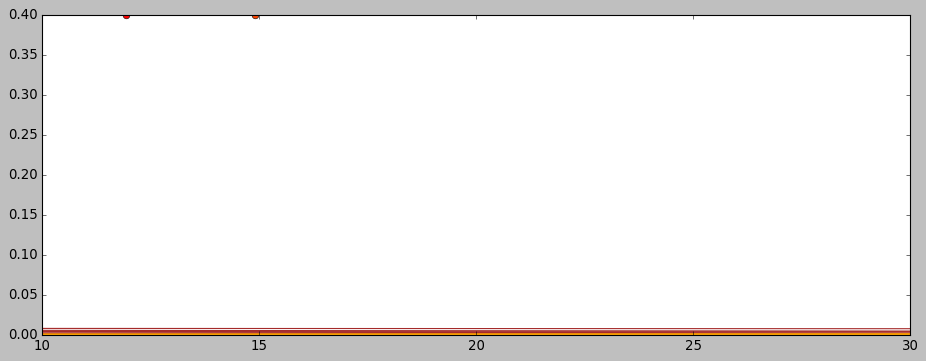

Number Correct:  253
Possible Number of Matches:  282

Event 63: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  89.23076923076923 %


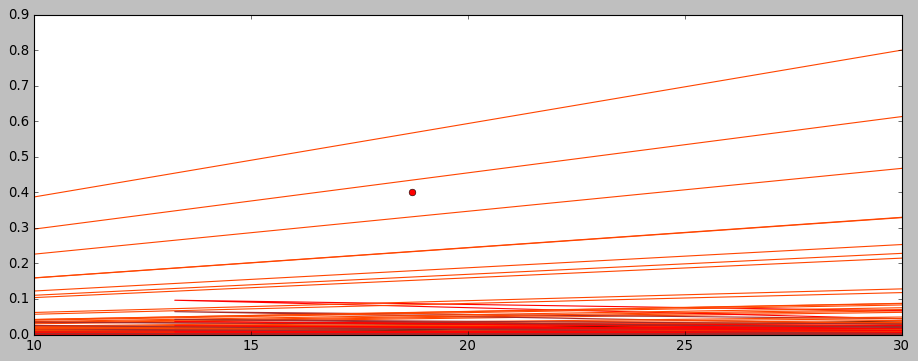

Number Correct:  102
Possible Number of Matches:  115

Event 64: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  79.38931297709924 %


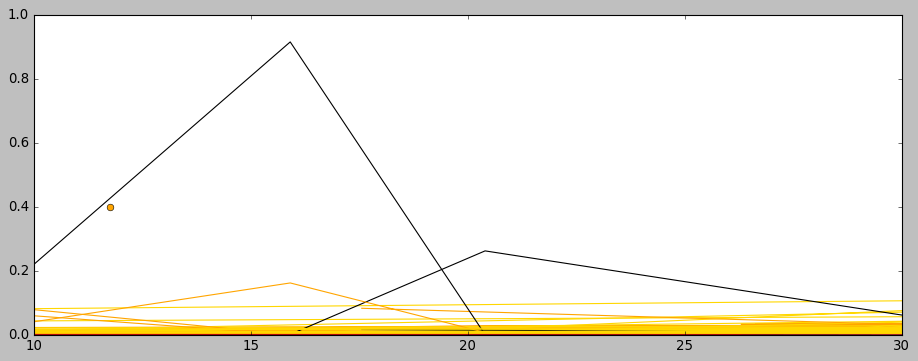

Number Correct:  91
Possible Number of Matches:  99

Event 65: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  84.9673202614379 %


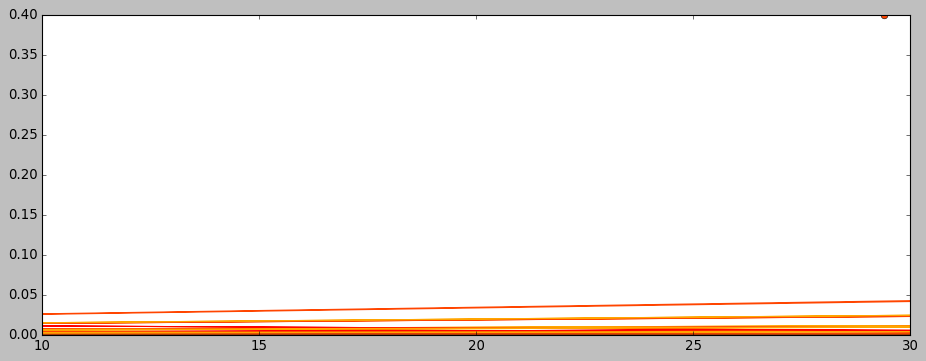

Number Correct:  244
Possible Number of Matches:  271

Event 66: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  88.88888888888889 %


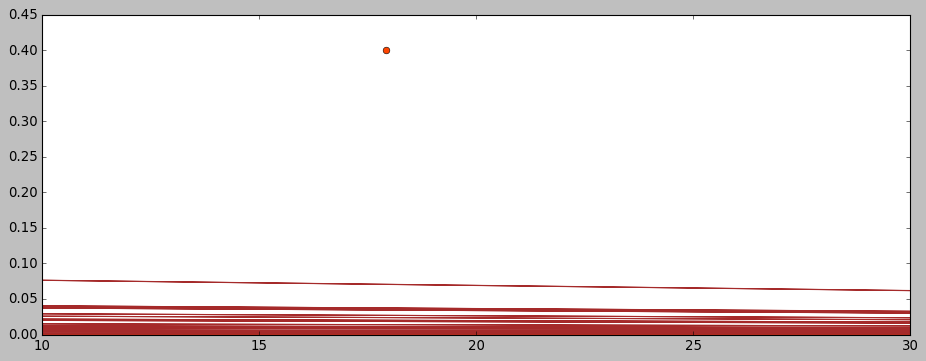

Number Correct:  151
Possible Number of Matches:  155

Event 67: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  86.23853211009174 %


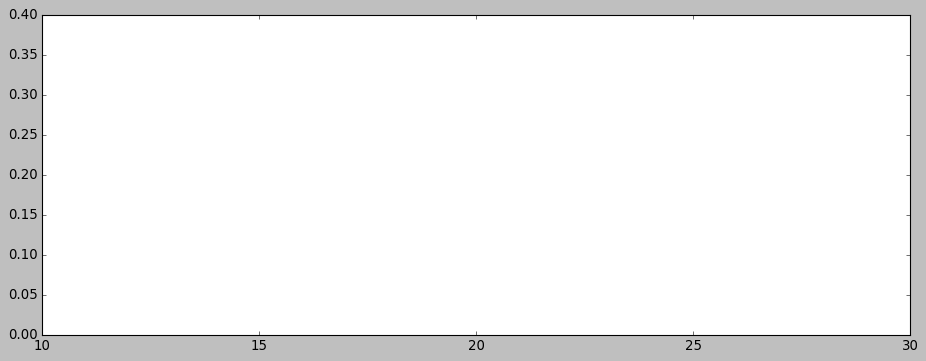

Number Correct:  177
Possible Number of Matches:  199

Event 68: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  88.8412017167382 %


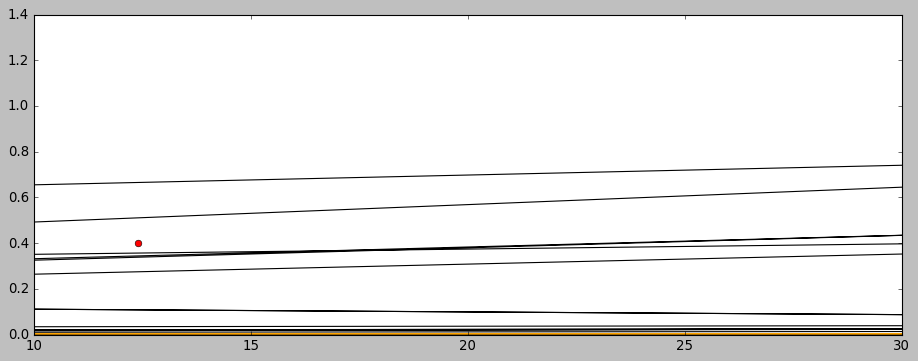

Number Correct:  191
Possible Number of Matches:  212

Event 69: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  76.55172413793103 %


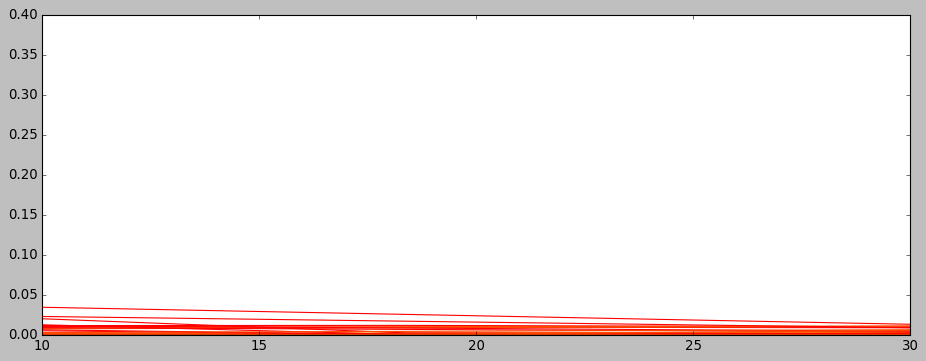

Number Correct:  199
Possible Number of Matches:  211

Event 70: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  76.566757493188 %


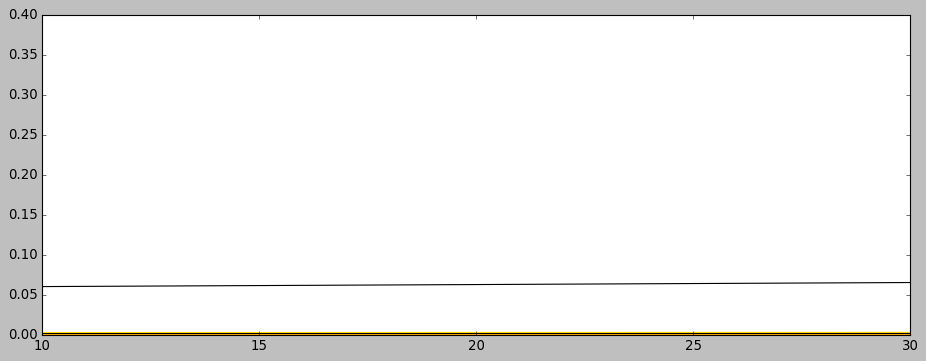

Number Correct:  253
Possible Number of Matches:  267

Event 71: Found 9 of 9, added 0 (eff 100.00%)
Percentage Matched =  96.113074204947 %


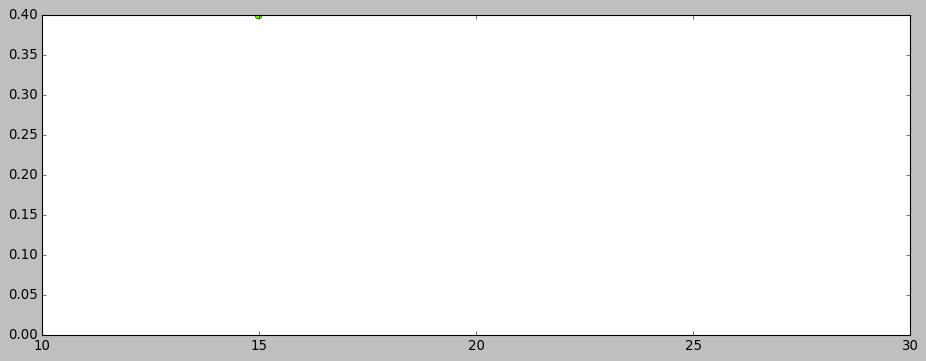

Number Correct:  241
Possible Number of Matches:  267

Event 72: Found 1 of 2, added 0 (eff 50.00%)
Percentage Matched =  86.66666666666667 %


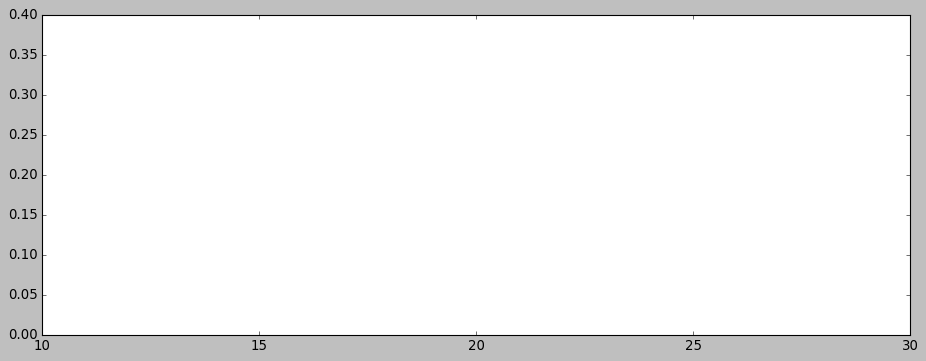

Number Correct:  99
Possible Number of Matches:  104

Event 73: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  86.04651162790698 %


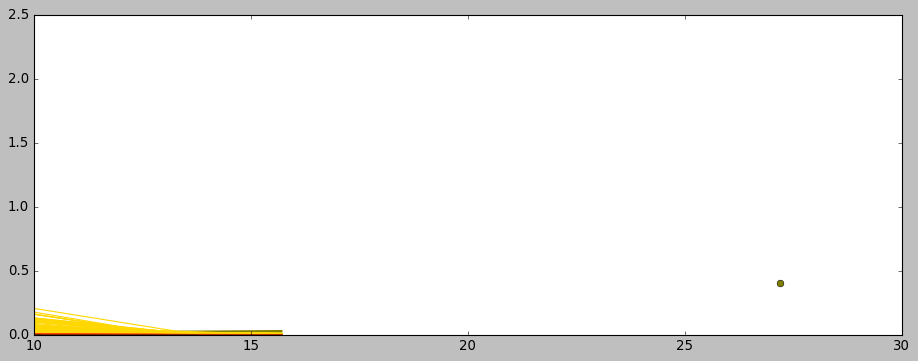

Number Correct:  155
Possible Number of Matches:  183

Event 74: Found 7 of 7, added 2 (eff 100.00%)
Percentage Matched =  90.50445103857567 %


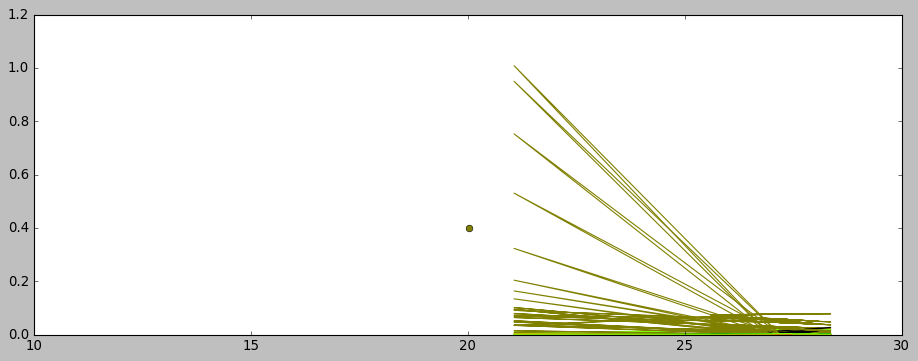

Number Correct:  276
Possible Number of Matches:  326

Event 75: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  84.01639344262296 %


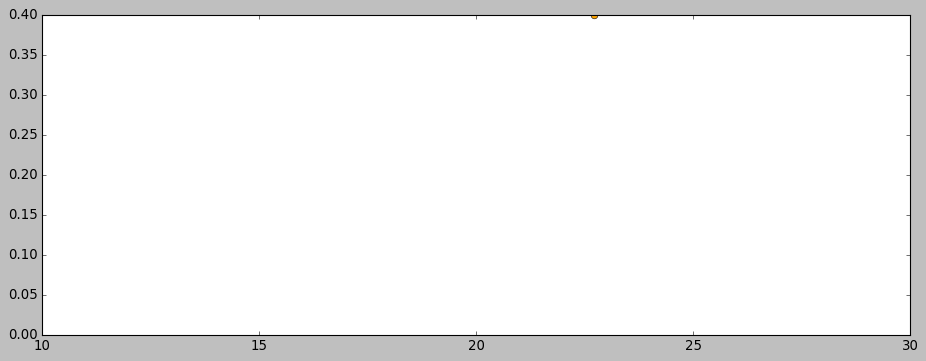

Number Correct:  195
Possible Number of Matches:  210

Event 76: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  90.54545454545455 %


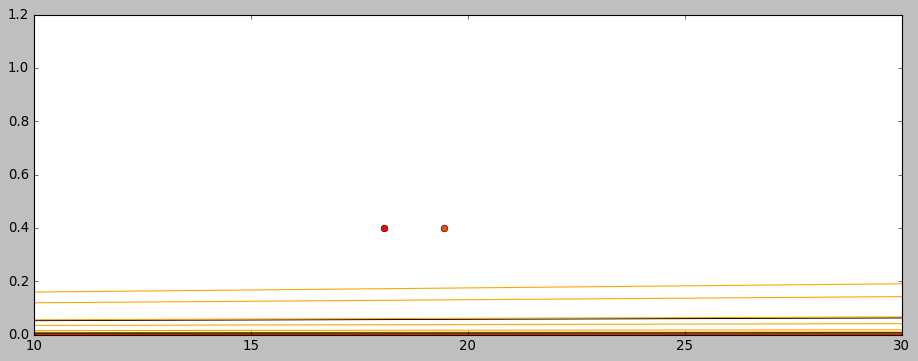

Number Correct:  206
Possible Number of Matches:  231

Event 77: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  92.55319148936171 %


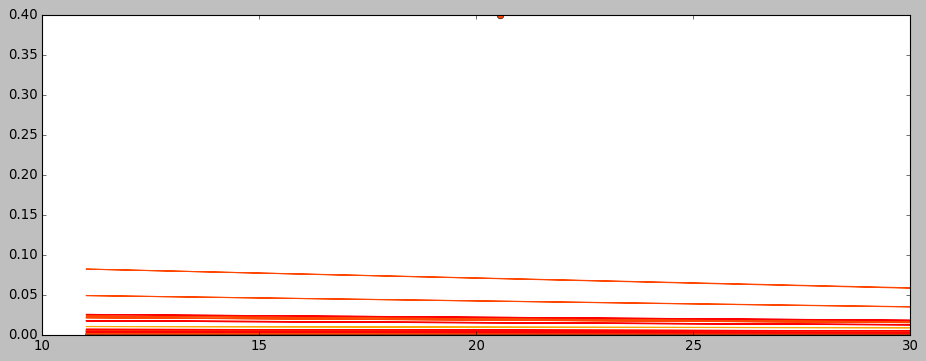

Number Correct:  166
Possible Number of Matches:  174

Event 78: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  92.51336898395722 %


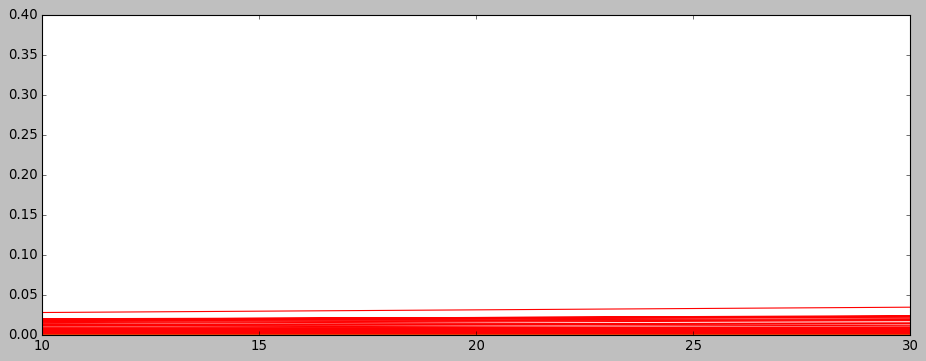

Number Correct:  167
Possible Number of Matches:  169

Event 79: Found 8 of 9, added 3 (eff 88.89%)
Percentage Matched =  90.18181818181819 %


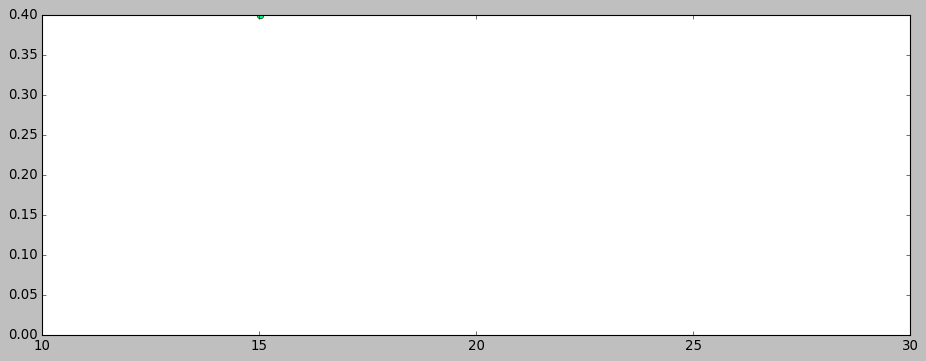

Number Correct:  213
Possible Number of Matches:  264

Event 80: Found 6 of 6, added 1 (eff 100.00%)
Percentage Matched =  91.07981220657277 %


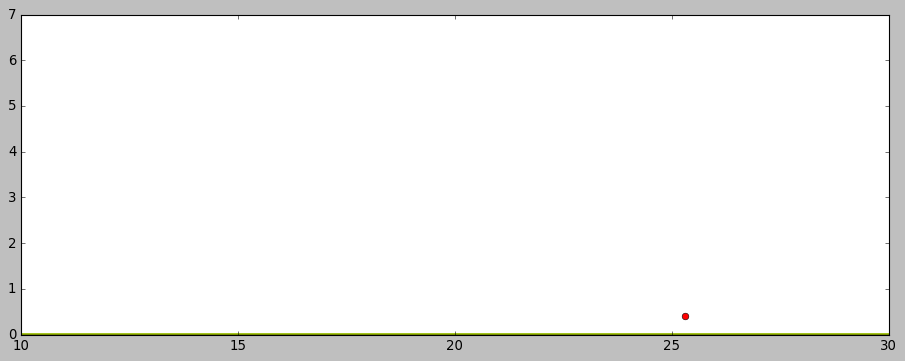

Number Correct:  168
Possible Number of Matches:  203

Event 81: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  50.0 %


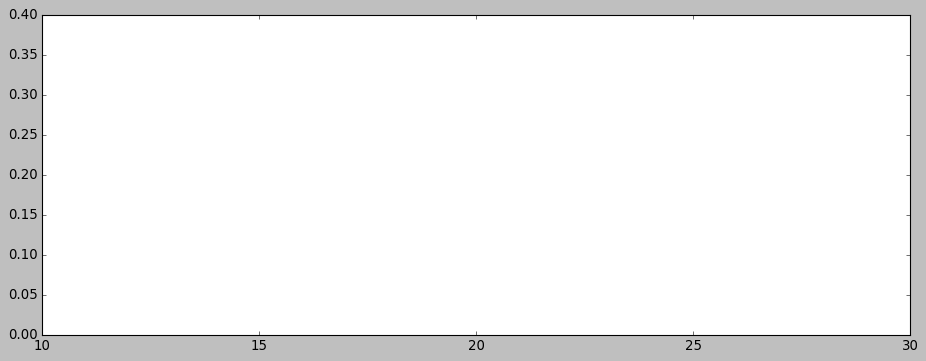

Number Correct:  93
Possible Number of Matches:  98

Event 82: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  84.44444444444444 %


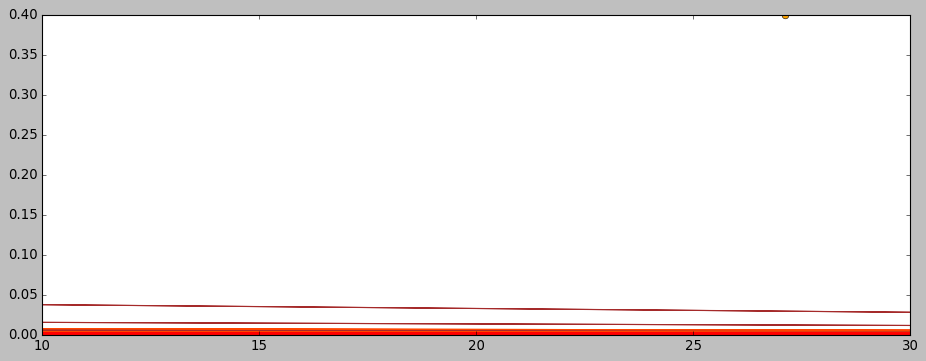

Number Correct:  74
Possible Number of Matches:  76

Event 83: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  90.9090909090909 %


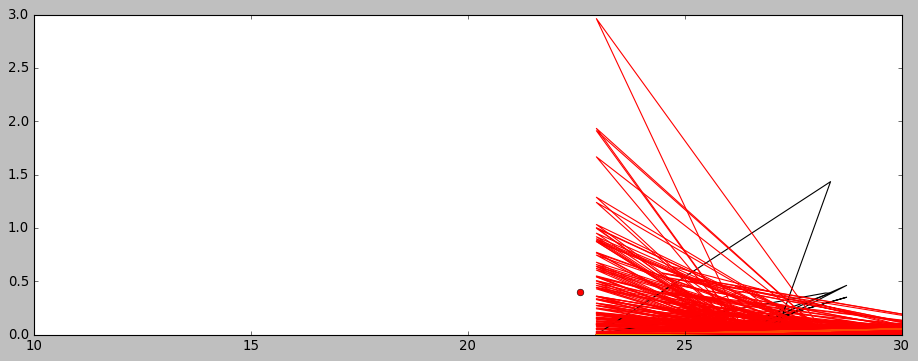

Number Correct:  183
Possible Number of Matches:  198

Event 84: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  89.82456140350877 %


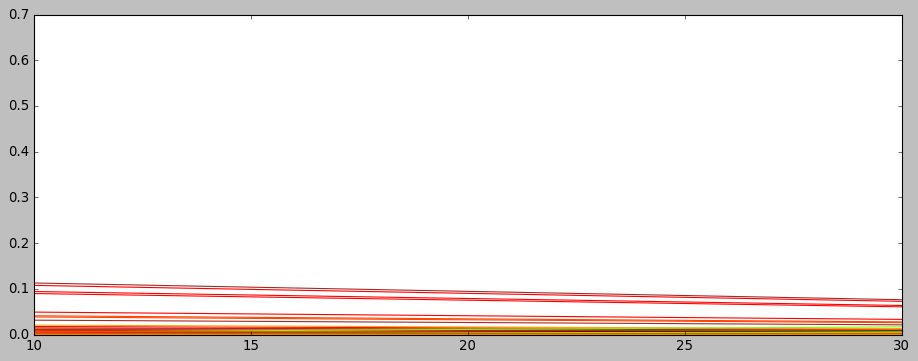

Number Correct:  216
Possible Number of Matches:  256

Event 85: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  78.66323907455013 %


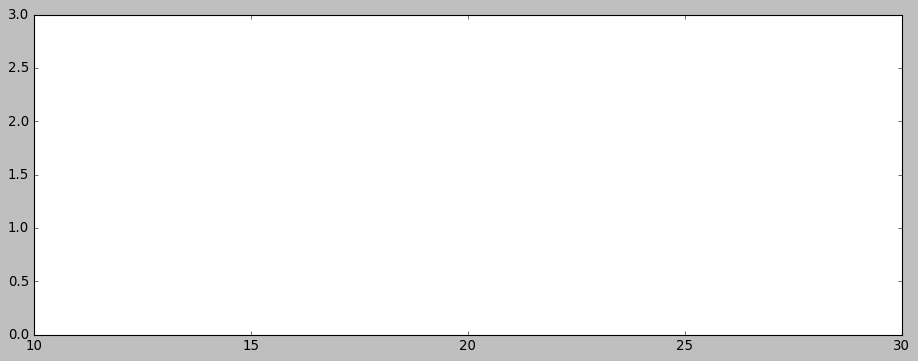

Number Correct:  290
Possible Number of Matches:  311

Event 86: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  76.26262626262626 %


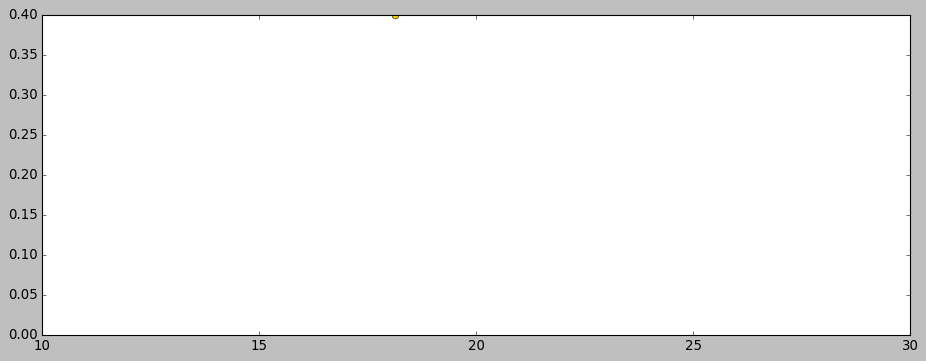

Number Correct:  134
Possible Number of Matches:  150

Event 87: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  86.1003861003861 %


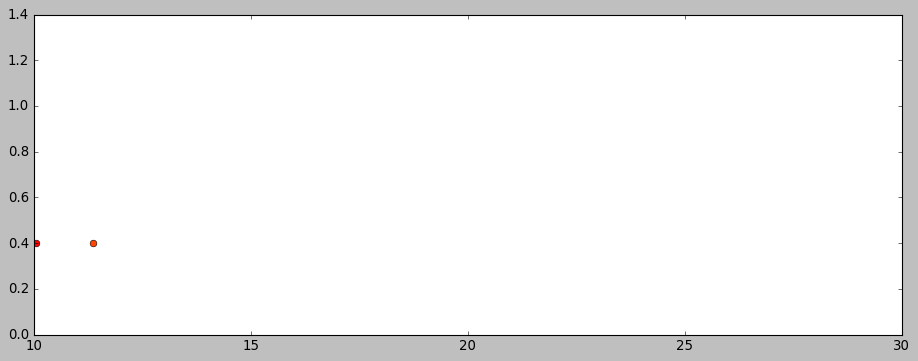

Number Correct:  193
Possible Number of Matches:  223

Event 88: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  85.66666666666667 %


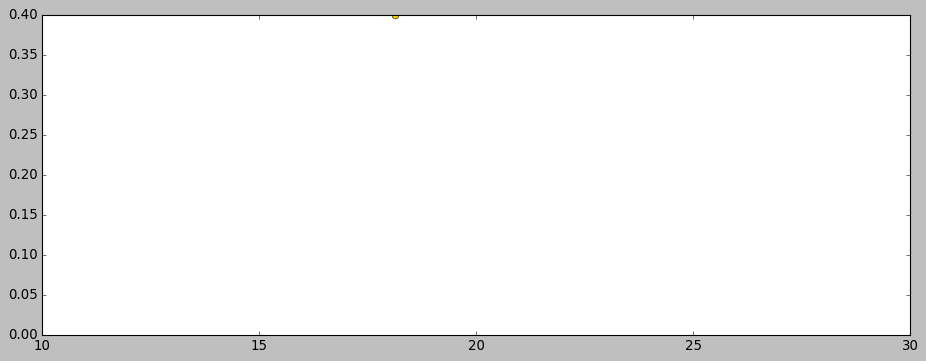

Number Correct:  209
Possible Number of Matches:  235

Event 89: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.81118881118881 %


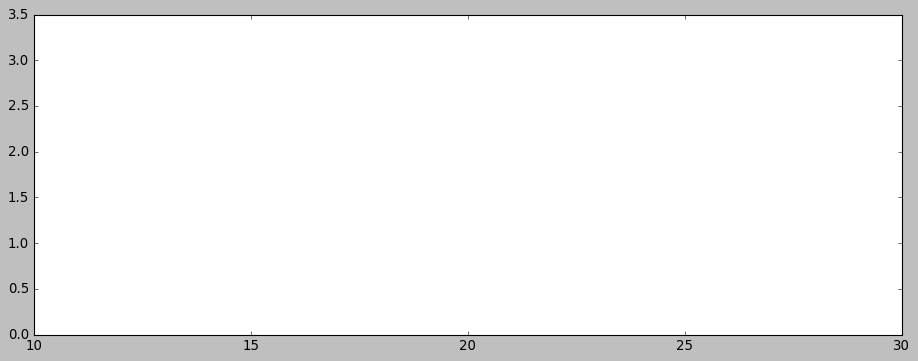

Number Correct:  115
Possible Number of Matches:  121

Event 90: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  93.89312977099236 %


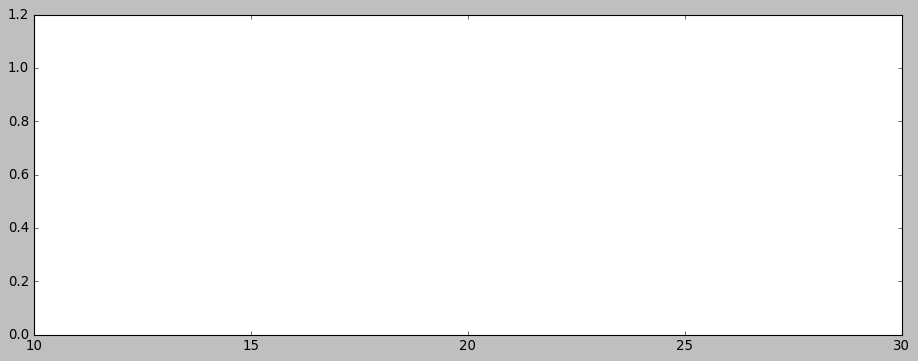

Number Correct:  107
Possible Number of Matches:  119

Event 91: Found 4 of 5, added 0 (eff 80.00%)
Percentage Matched =  87.82608695652173 %


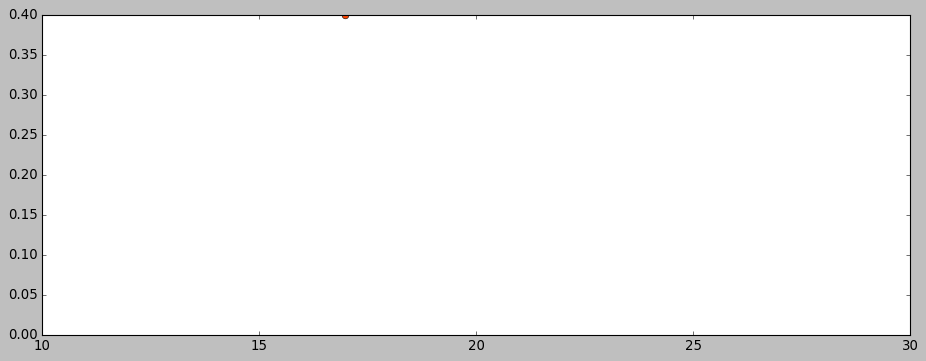

Number Correct:  192
Possible Number of Matches:  203

Event 92: Found 9 of 9, added 1 (eff 100.00%)
Percentage Matched =  91.24579124579125 %


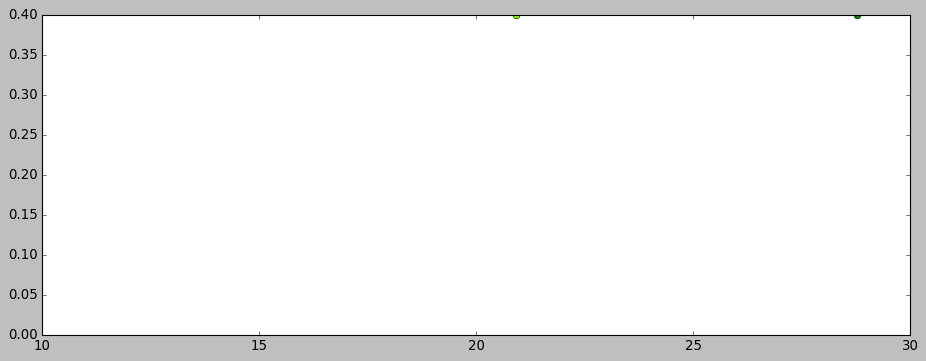

Number Correct:  238
Possible Number of Matches:  318

Event 93: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  86.70520231213872 %


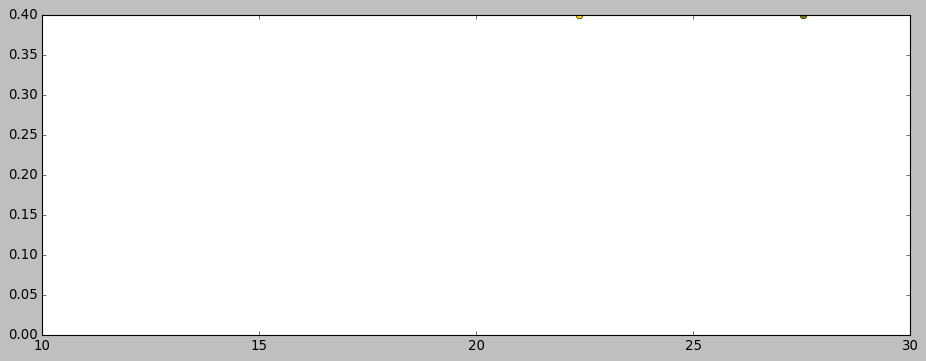

Number Correct:  130
Possible Number of Matches:  142

Event 94: Found 5 of 6, added 2 (eff 83.33%)
Percentage Matched =  63.2034632034632 %


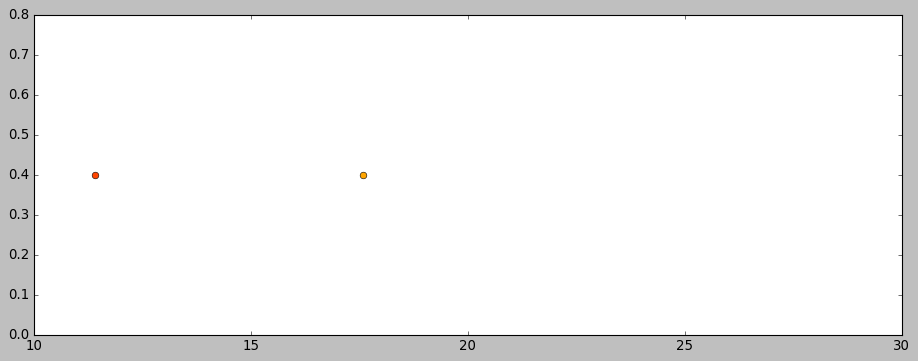

Number Correct:  131
Possible Number of Matches:  156

Event 95: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  62.295081967213115 %


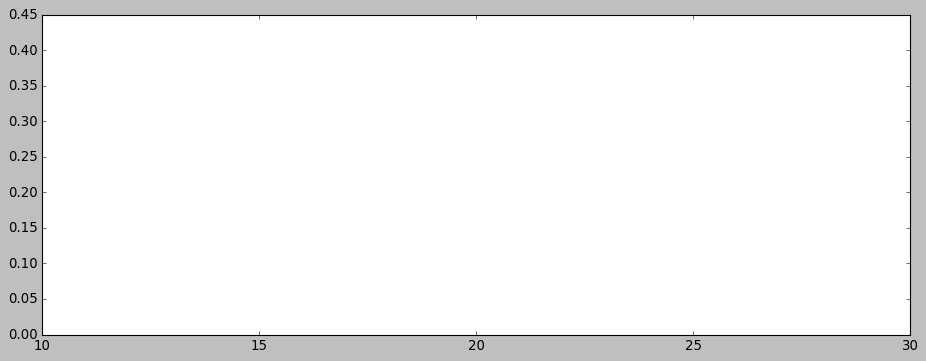

Number Correct:  131
Possible Number of Matches:  202

Event 96: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  88.0952380952381 %


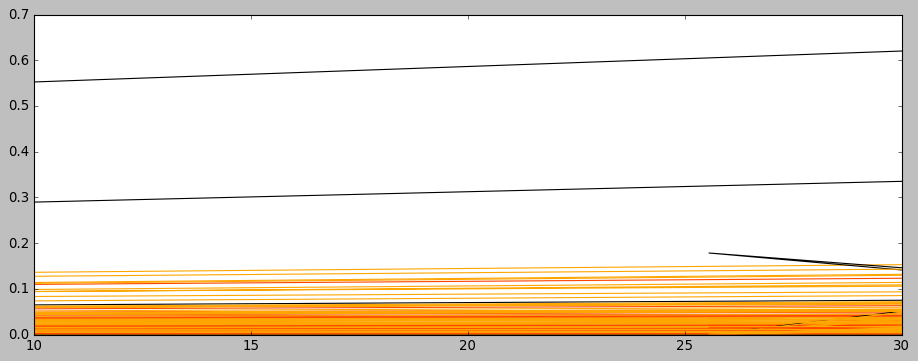

Number Correct:  100
Possible Number of Matches:  111

Event 97: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.03225806451613 %


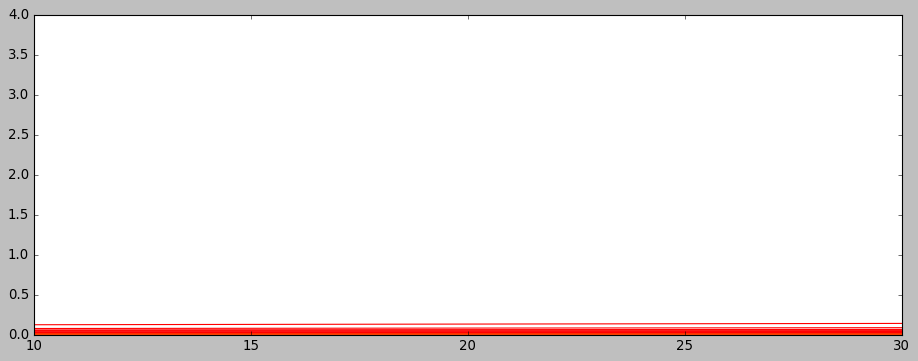

Number Correct:  135
Possible Number of Matches:  142

Event 98: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  91.42857142857143 %


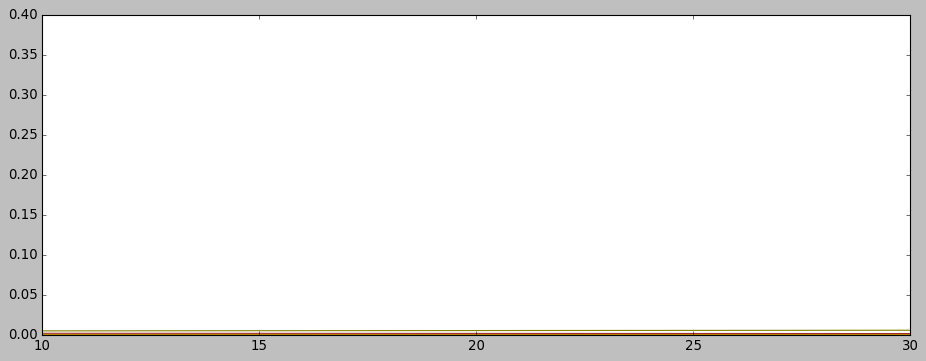

Number Correct:  228
Possible Number of Matches:  257

Event 99: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  56.8 %


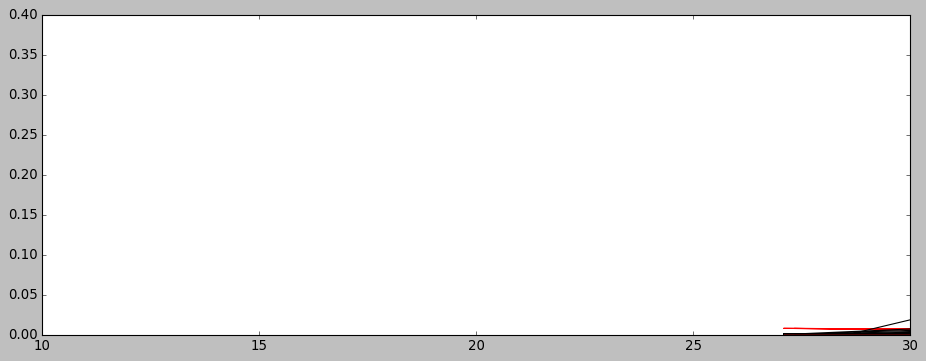

Number Correct:  68
Possible Number of Matches:  70

Event 100: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  87.02702702702703 %


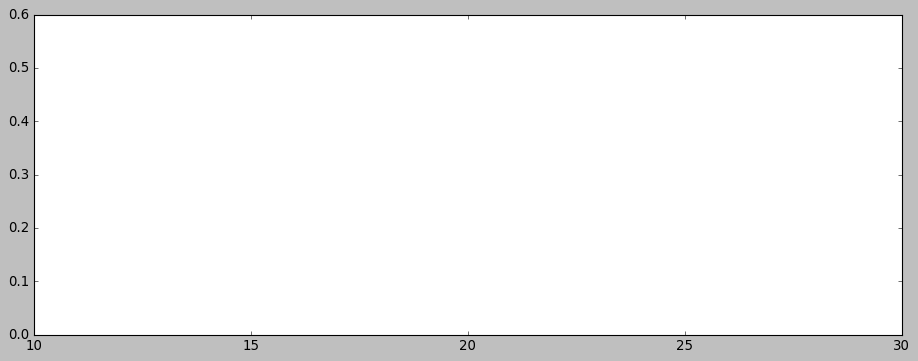

Number Correct:  136
Possible Number of Matches:  158

Event 101: Found 2 of 2, added 1 (eff 100.00%)
Percentage Matched =  80.95238095238095 %


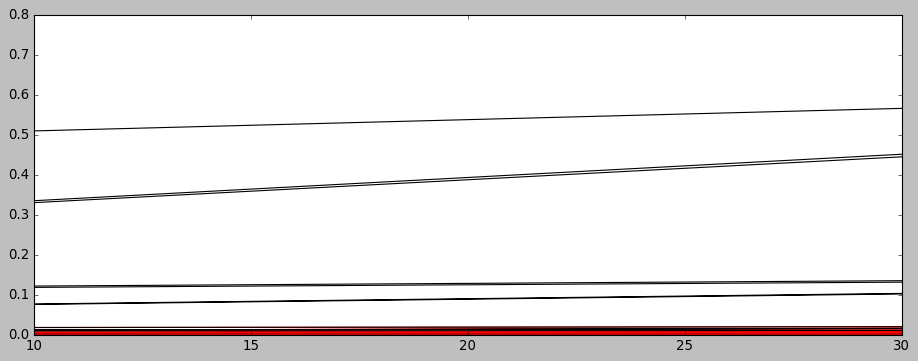

Number Correct:  141
Possible Number of Matches:  154

Event 102: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  92.85714285714286 %


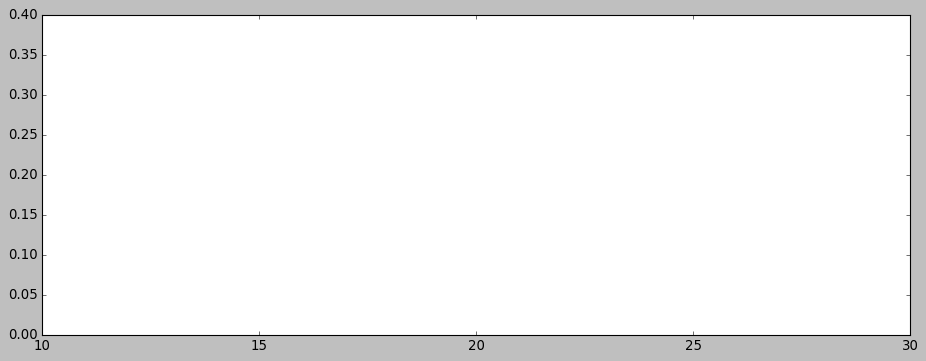

Number Correct:  156
Possible Number of Matches:  178

Event 103: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  84.22939068100358 %


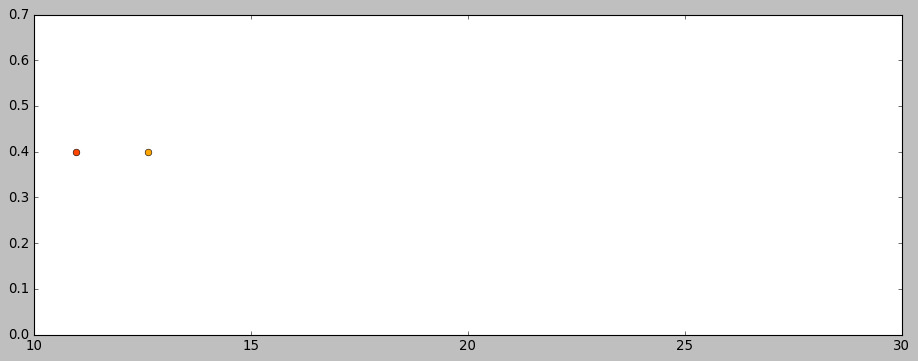

Number Correct:  201
Possible Number of Matches:  240

Event 104: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  81.64556962025317 %


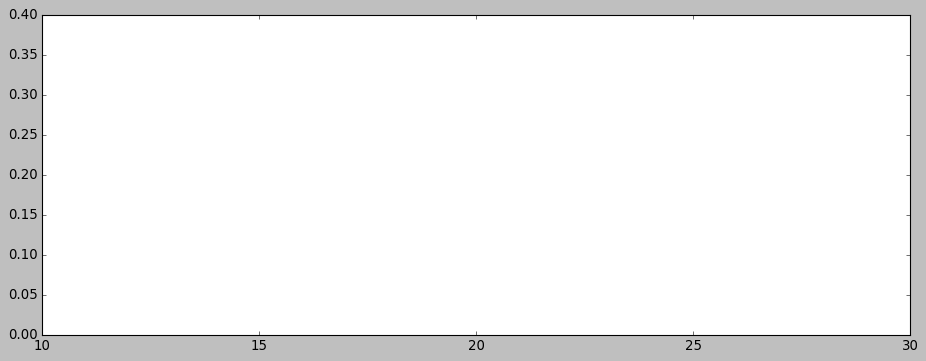

Number Correct:  103
Possible Number of Matches:  114

Event 105: Found 2 of 2, added 2 (eff 100.00%)
Percentage Matched =  88.41463414634147 %


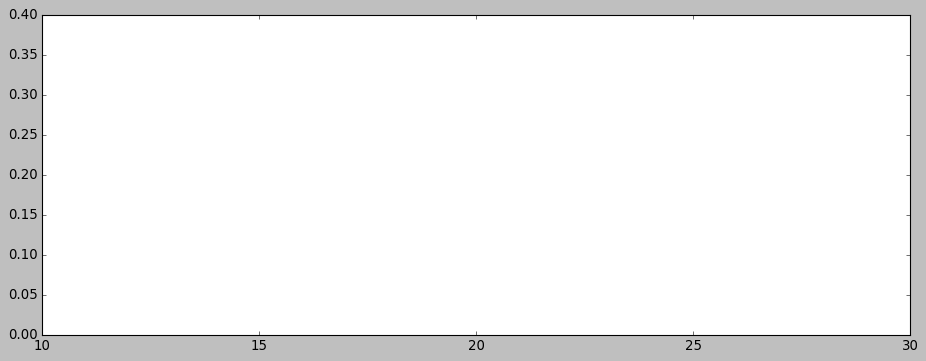

Number Correct:  135
Possible Number of Matches:  242

Event 106: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  89.82456140350877 %


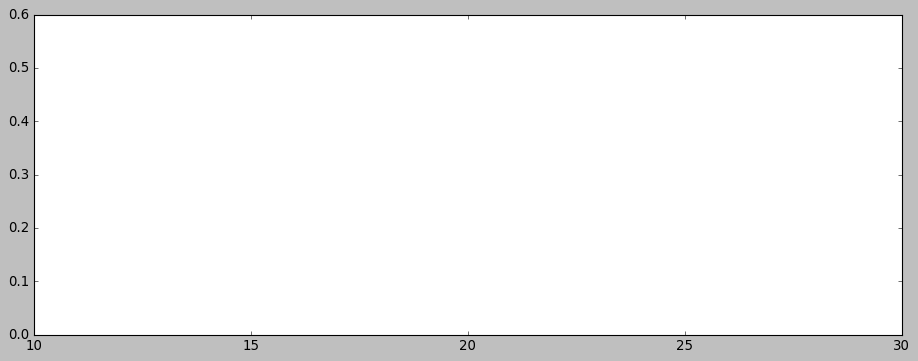

Number Correct:  230
Possible Number of Matches:  259

Event 107: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.63414634146342 %


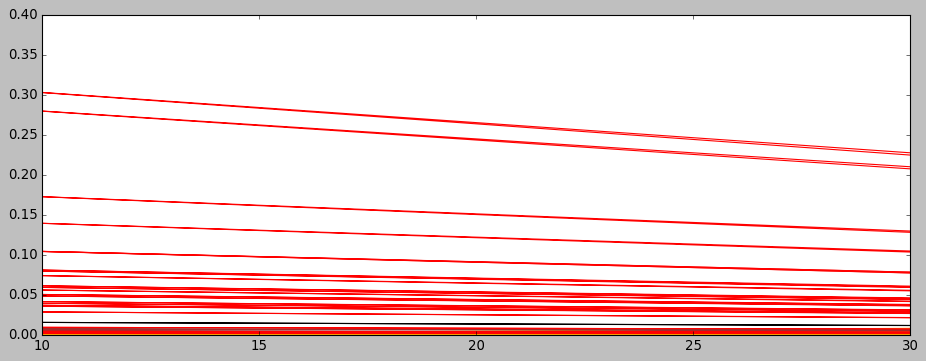

Number Correct:  139
Possible Number of Matches:  149

Event 108: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  84.11214953271028 %


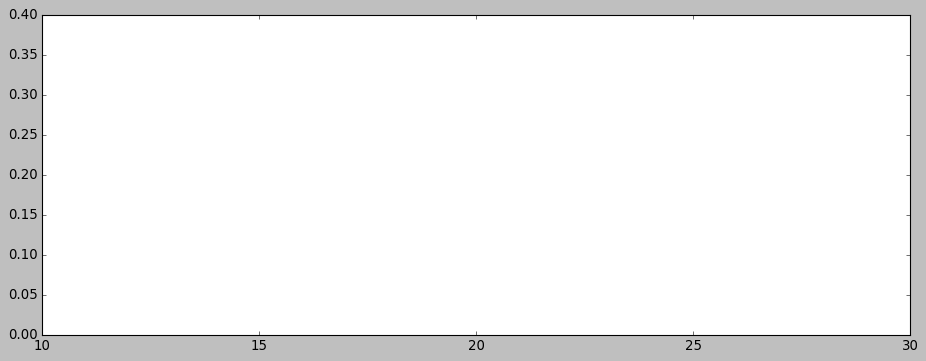

Number Correct:  83
Possible Number of Matches:  89

Event 109: Found 8 of 9, added 0 (eff 88.89%)
Percentage Matched =  91.63987138263666 %


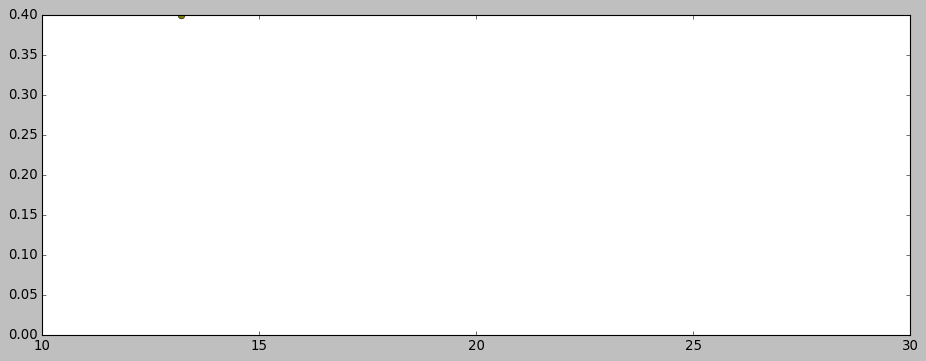

Number Correct:  229
Possible Number of Matches:  263

Event 110: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  78.66108786610879 %


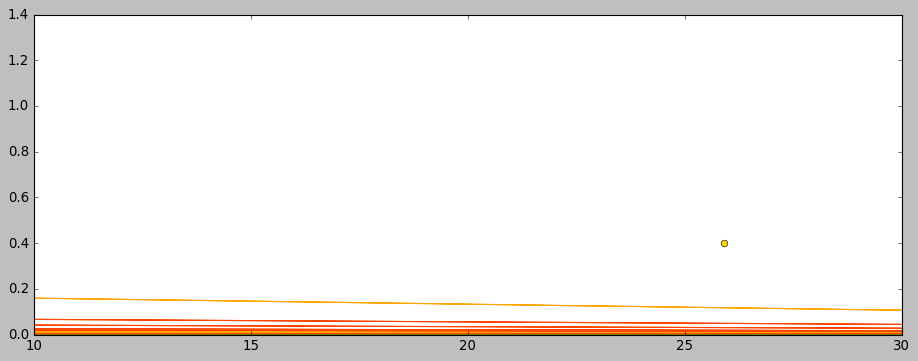

Number Correct:  158
Possible Number of Matches:  181

Event 111: Found 8 of 8, added 1 (eff 100.00%)
Percentage Matched =  89.94565217391305 %


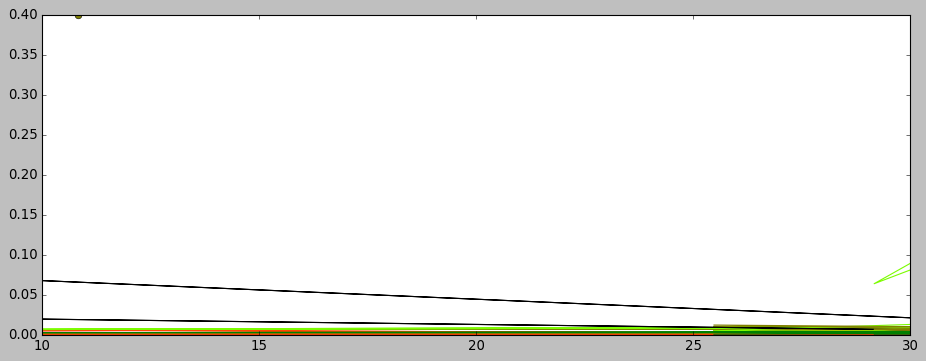

Number Correct:  292
Possible Number of Matches:  332

Event 112: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  93.17073170731707 %


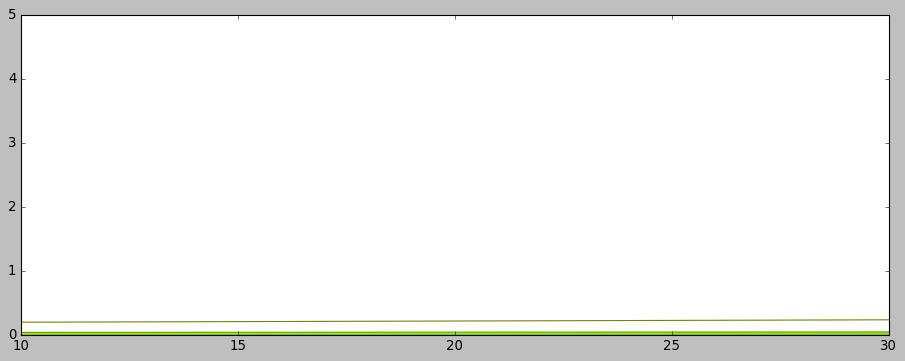

Number Correct:  179
Possible Number of Matches:  191

Event 113: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  91.97860962566845 %


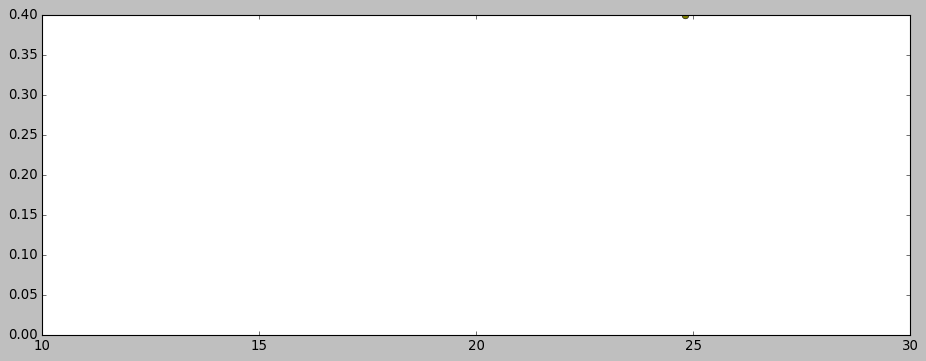

Number Correct:  128
Possible Number of Matches:  145

Event 114: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  91.1660777385159 %


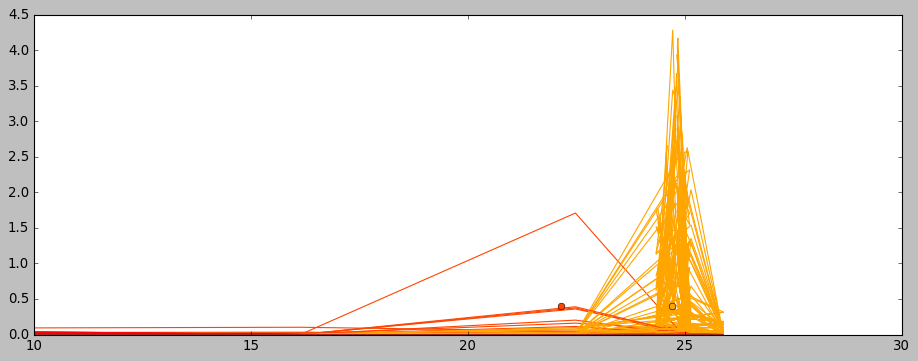

Number Correct:  231
Possible Number of Matches:  257

Event 115: Found 6 of 6, added 1 (eff 100.00%)
Percentage Matched =  92.17687074829932 %


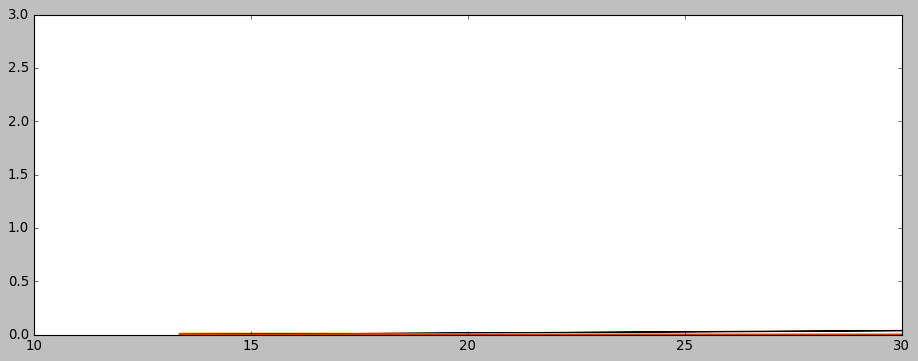

Number Correct:  250
Possible Number of Matches:  284

Event 116: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  90.76923076923077 %


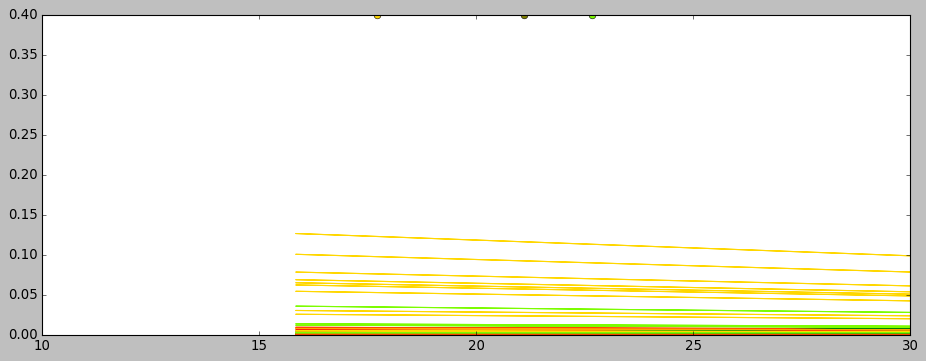

Number Correct:  200
Possible Number of Matches:  268

Event 117: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  90.29850746268657 %


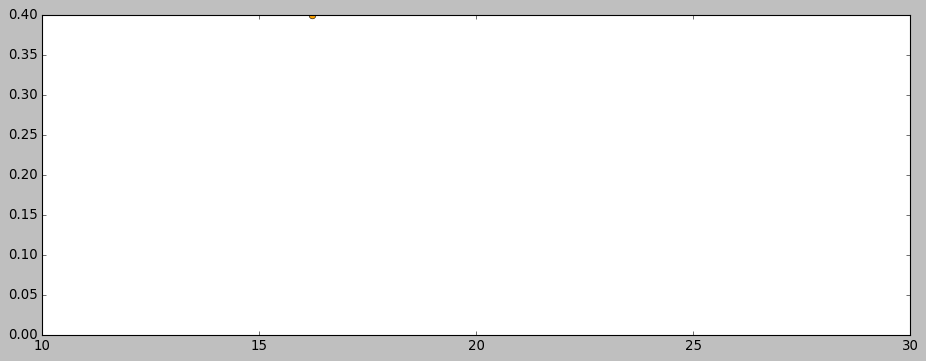

Number Correct:  112
Possible Number of Matches:  116

Event 118: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  82.65895953757226 %


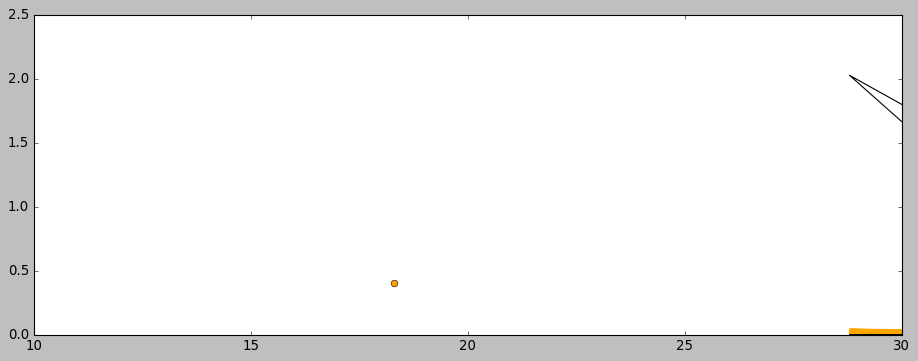

Number Correct:  135
Possible Number of Matches:  142

Event 119: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  79.34782608695652 %


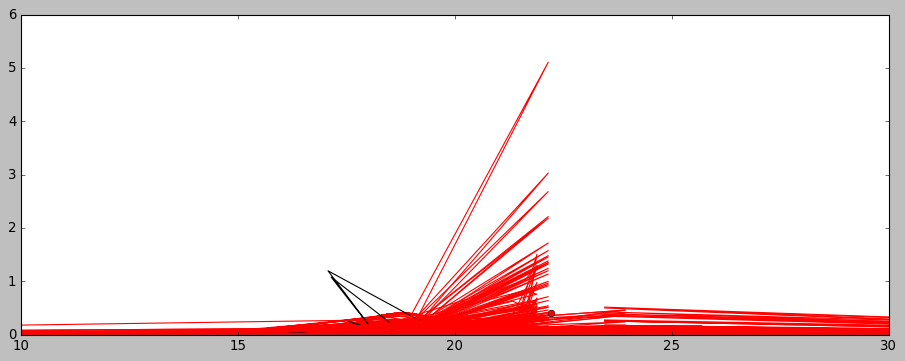

Number Correct:  138
Possible Number of Matches:  147

Event 120: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  89.25619834710744 %


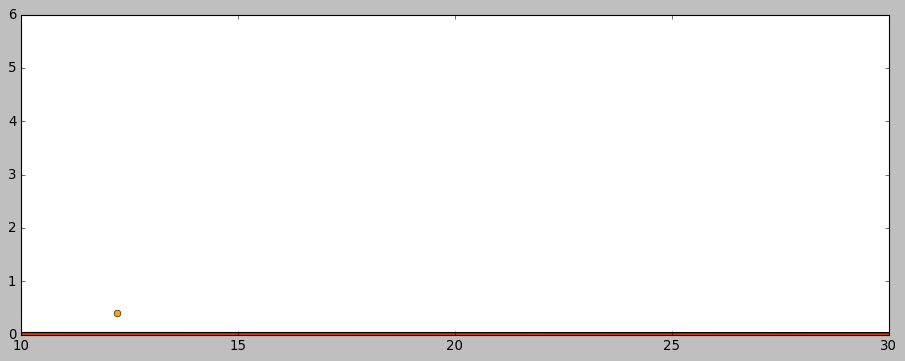

Number Correct:  168
Possible Number of Matches:  189

Event 121: Found 10 of 10, added 0 (eff 100.00%)
Percentage Matched =  84.24908424908425 %


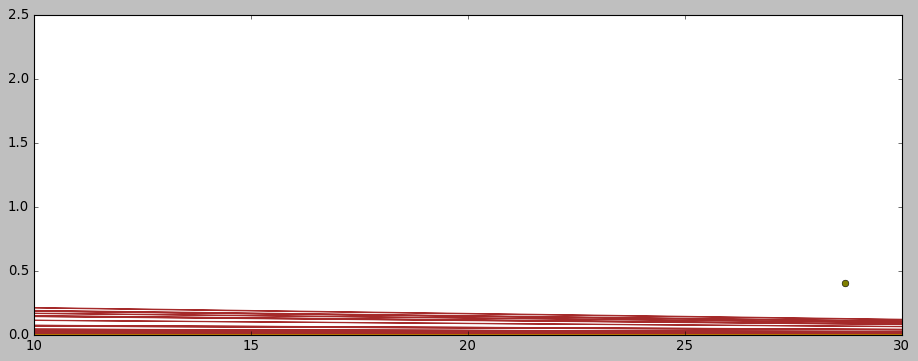

Number Correct:  192
Possible Number of Matches:  227

Event 122: Found 2 of 2, added 1 (eff 100.00%)
Percentage Matched =  86.15384615384616 %


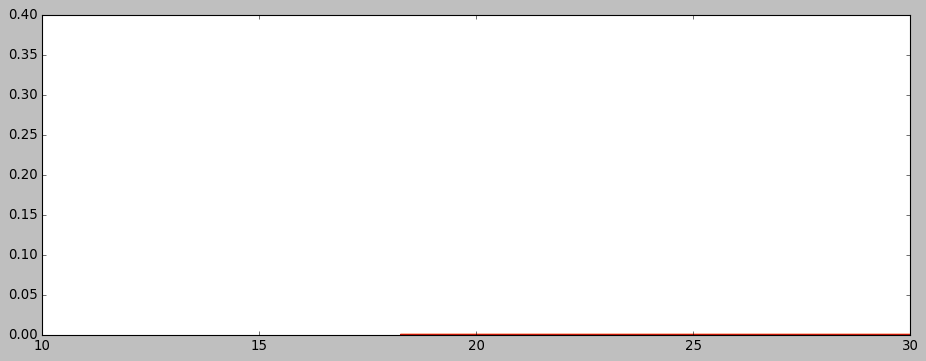

Number Correct:  109
Possible Number of Matches:  191

Event 123: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  72.46376811594203 %


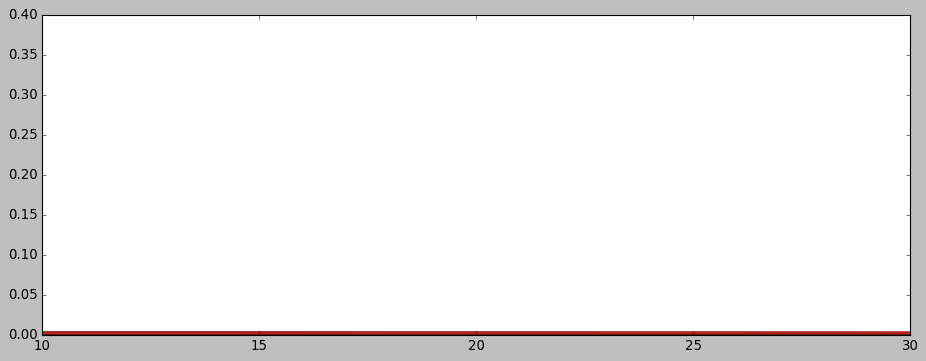

Number Correct:  147
Possible Number of Matches:  152

Event 124: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  83.11688311688312 %


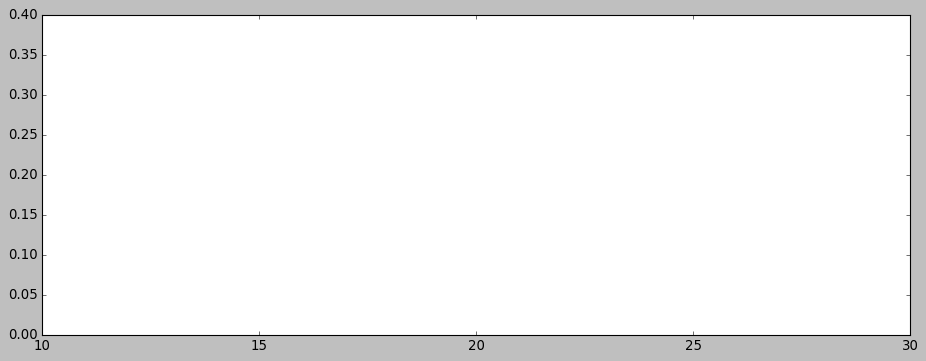

Number Correct:  126
Possible Number of Matches:  130

Event 125: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  89.23611111111111 %


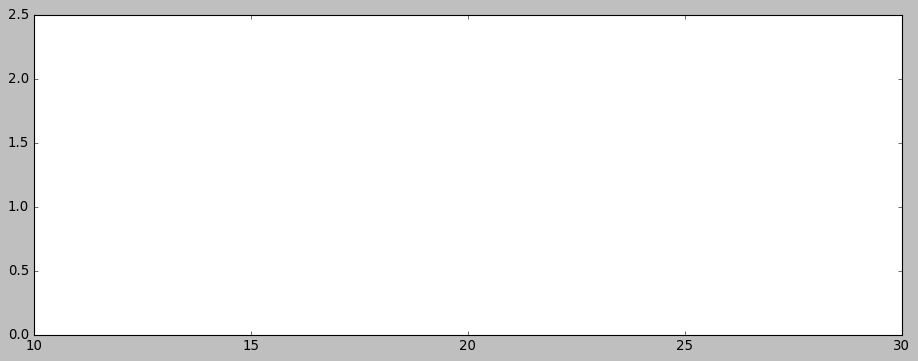

Number Correct:  246
Possible Number of Matches:  323

Event 126: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  91.33858267716535 %


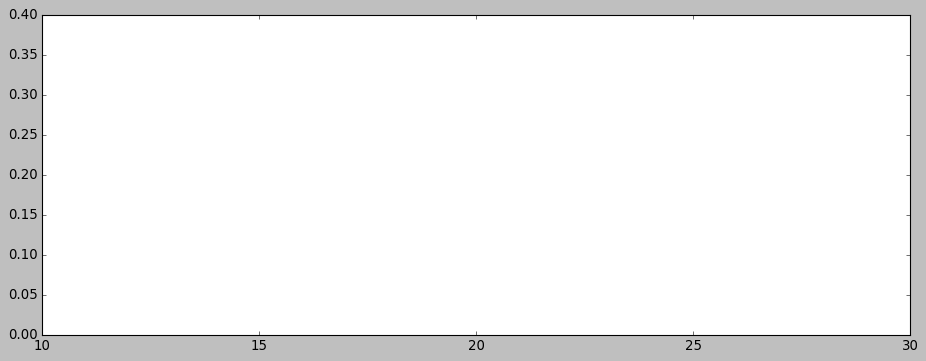

Number Correct:  104
Possible Number of Matches:  109

Event 127: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  49.831649831649834 %


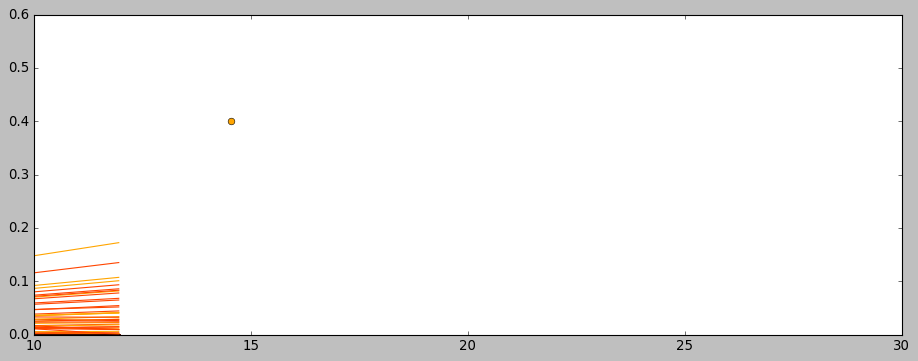

Number Correct:  135
Possible Number of Matches:  153

Event 128: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  39.688715953307394 %


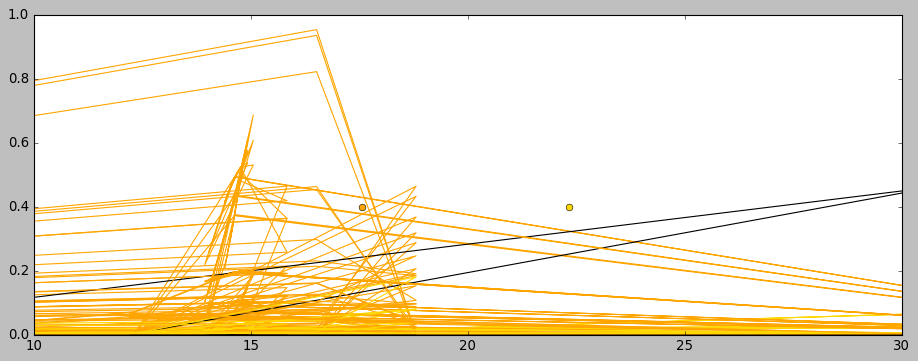

Number Correct:  90
Possible Number of Matches:  102

Event 129: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  90.35714285714286 %


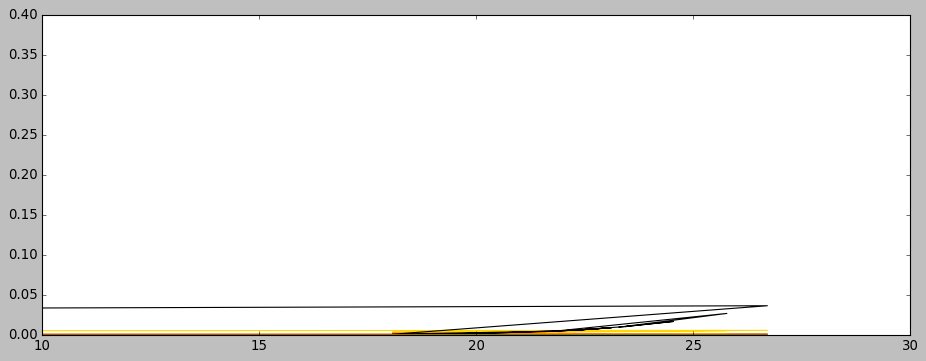

Number Correct:  229
Possible Number of Matches:  255

Event 130: Found 6 of 6, added 1 (eff 100.00%)
Percentage Matched =  78.35820895522389 %


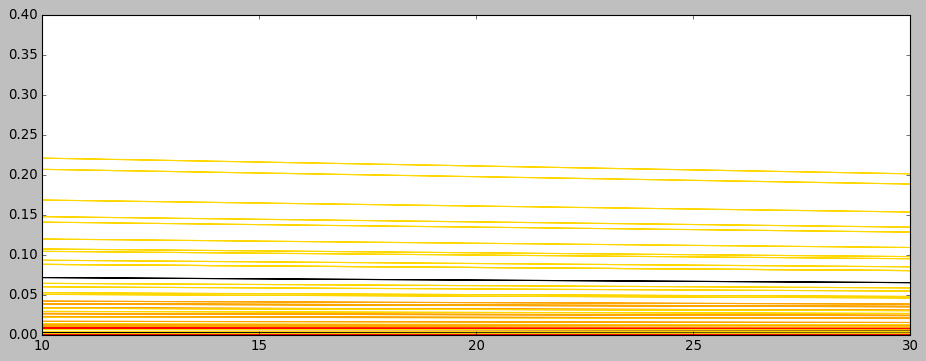

Number Correct:  190
Possible Number of Matches:  255

Event 131: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  89.05775075987842 %


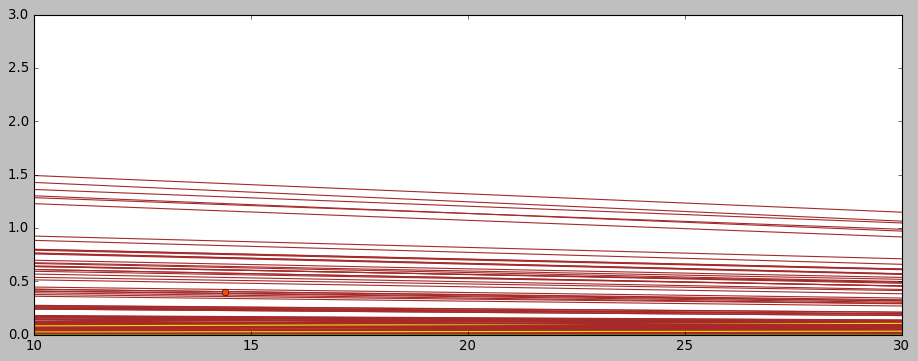

Number Correct:  283
Possible Number of Matches:  303

Event 132: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  88.97058823529412 %


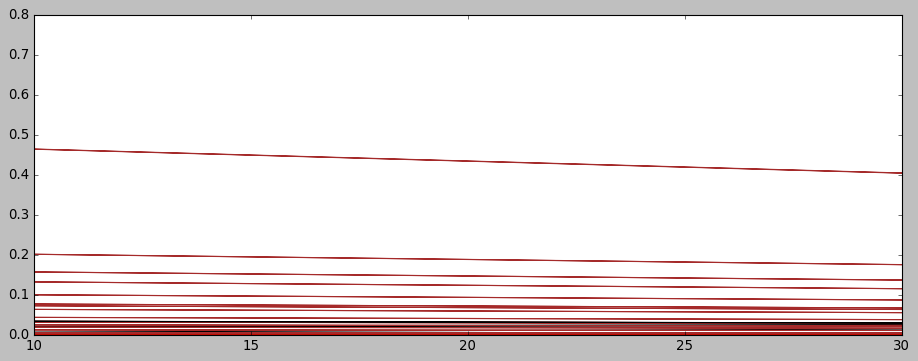

Number Correct:  119
Possible Number of Matches:  123

Event 133: Found 6 of 6, added 1 (eff 100.00%)
Percentage Matched =  85.46712802768167 %


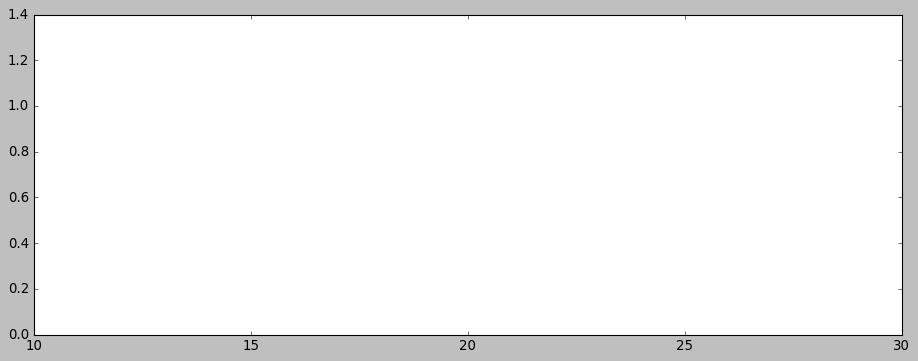

Number Correct:  230
Possible Number of Matches:  263

Event 134: Found 4 of 4, added 3 (eff 100.00%)
Percentage Matched =  88.88888888888889 %


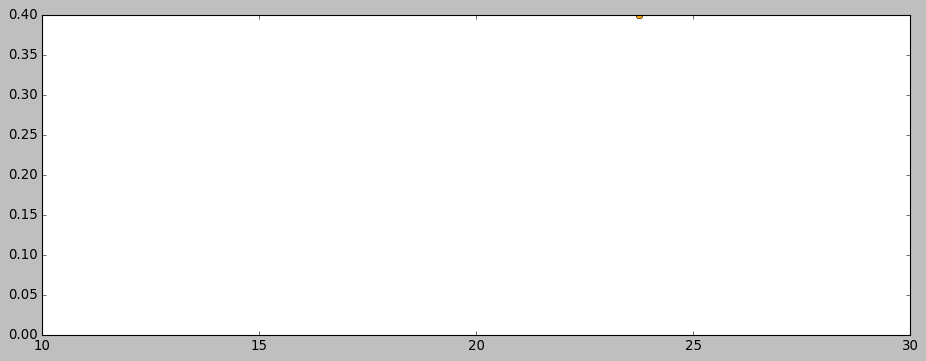

Number Correct:  207
Possible Number of Matches:  333

Event 135: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  91.76470588235294 %


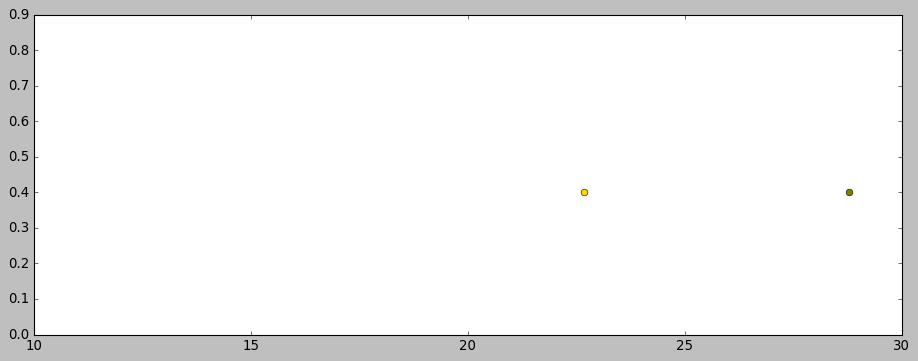

Number Correct:  135
Possible Number of Matches:  168

Event 136: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  93.05019305019304 %


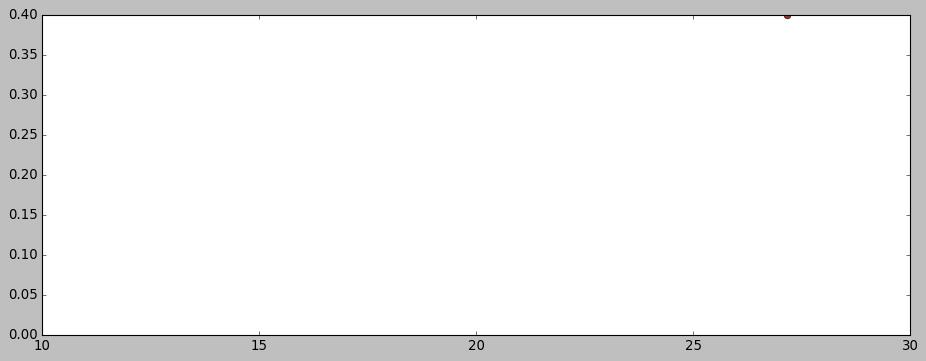

Number Correct:  216
Possible Number of Matches:  245

Event 137: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  86.80203045685279 %


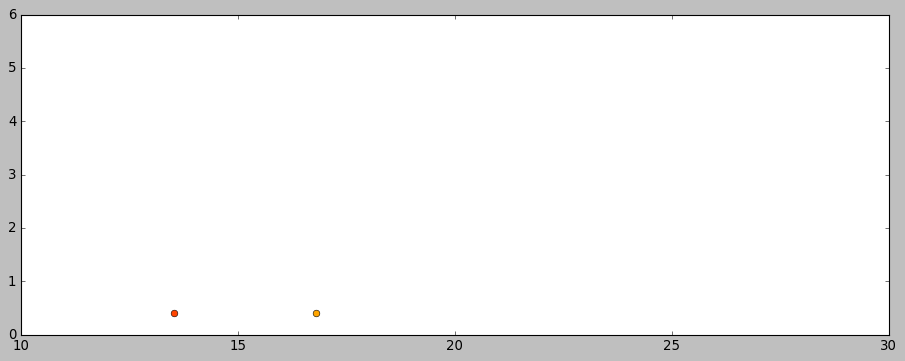

Number Correct:  159
Possible Number of Matches:  173

Event 138: Found 5 of 6, added 1 (eff 83.33%)
Percentage Matched =  92.5 %


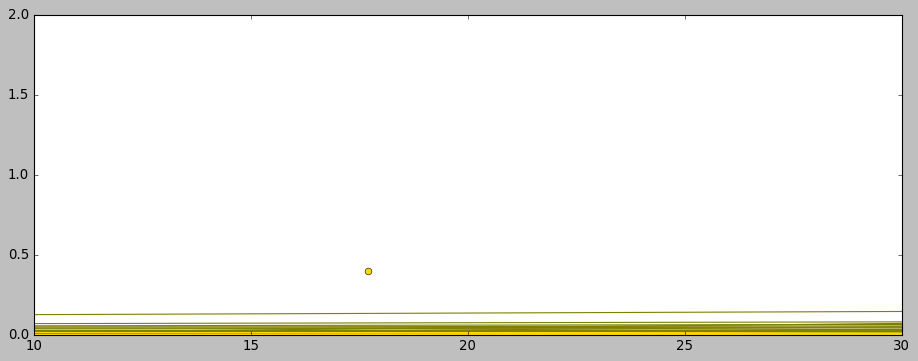

Number Correct:  95
Possible Number of Matches:  106

Event 139: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  88.30188679245283 %


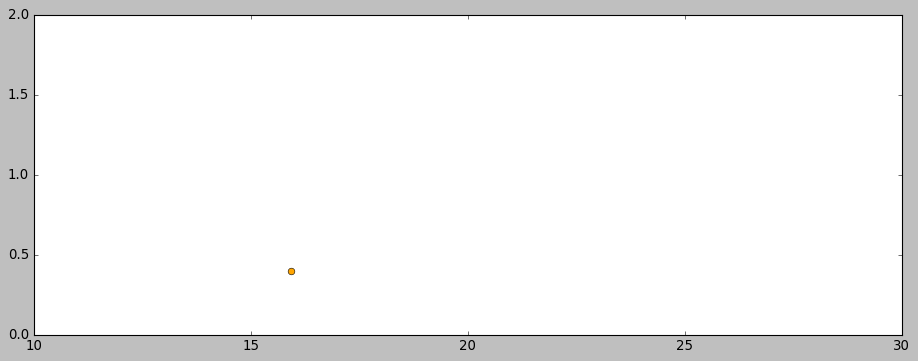

Number Correct:  182
Possible Number of Matches:  191

Event 140: Found 3 of 4, added 0 (eff 75.00%)
Percentage Matched =  78.23529411764706 %


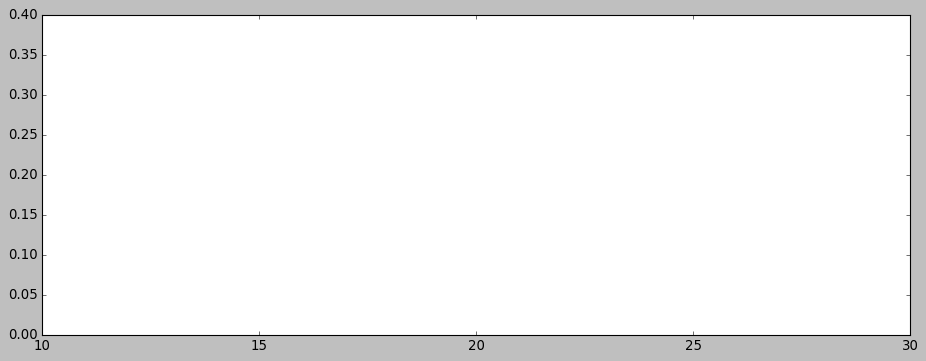

Number Correct:  63
Possible Number of Matches:  71

Event 141: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.20224719101124 %


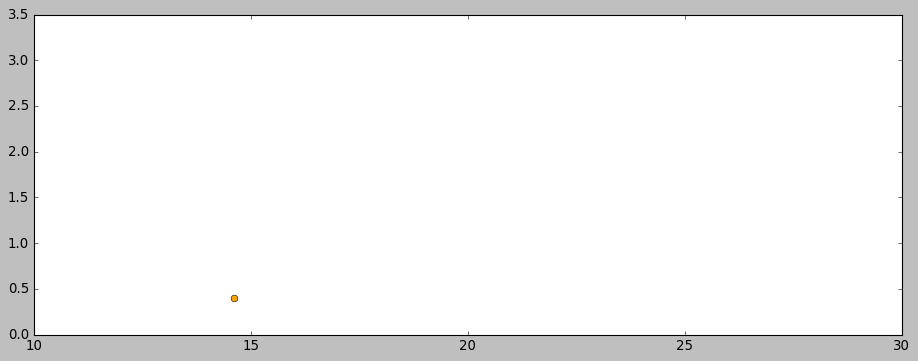

Number Correct:  153
Possible Number of Matches:  159

Event 142: Found 9 of 10, added 0 (eff 90.00%)
Percentage Matched =  70.09345794392523 %


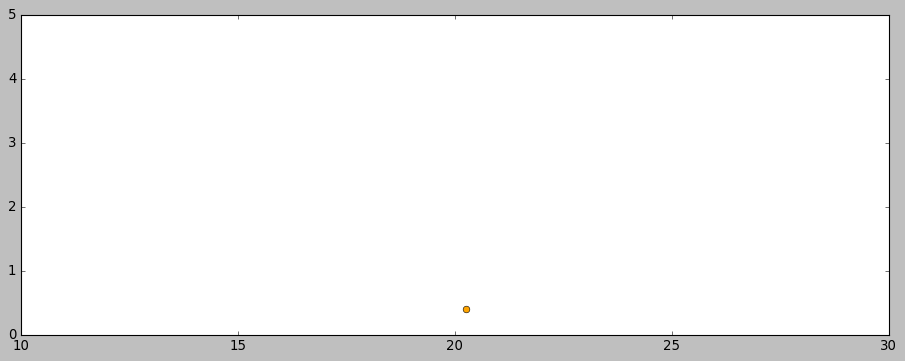

Number Correct:  194
Possible Number of Matches:  204

Event 143: Found 9 of 10, added 1 (eff 90.00%)
Percentage Matched =  92.52525252525253 %


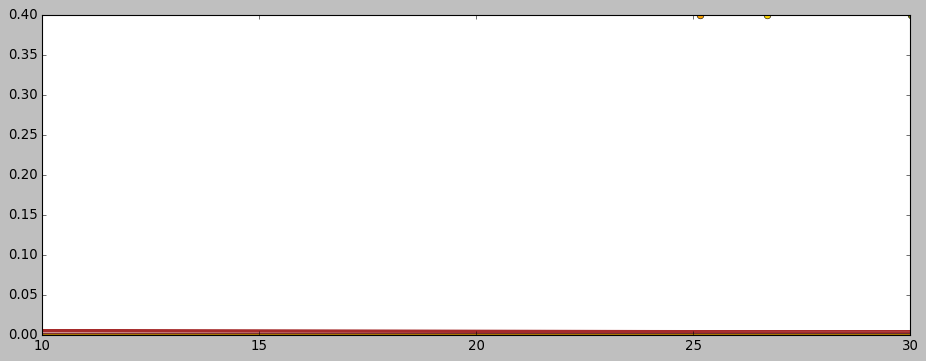

Number Correct:  383
Possible Number of Matches:  460

Event 144: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.58865248226951 %


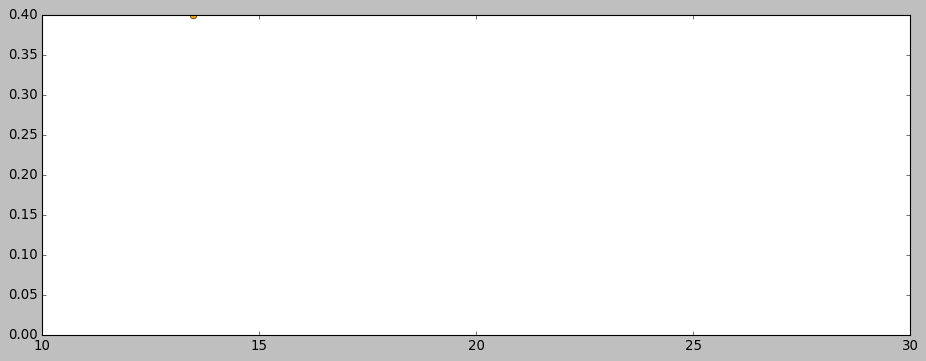

Number Correct:  239
Possible Number of Matches:  249

Event 145: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  93.44262295081967 %


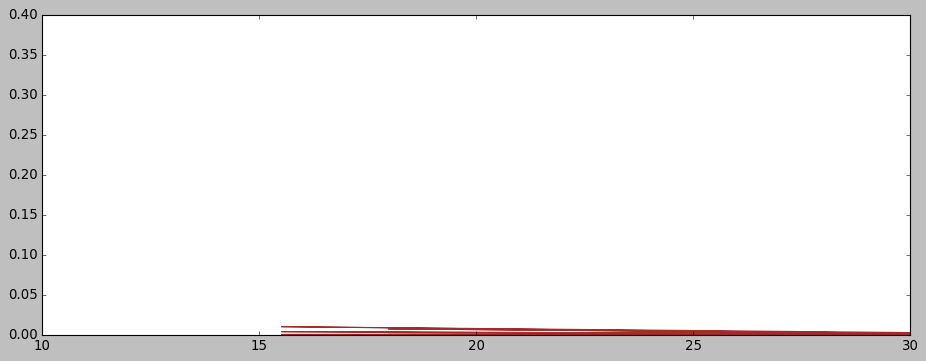

Number Correct:  57
Possible Number of Matches:  57

Event 146: Found 2 of 2, added 1 (eff 100.00%)
Percentage Matched =  95.38461538461539 %


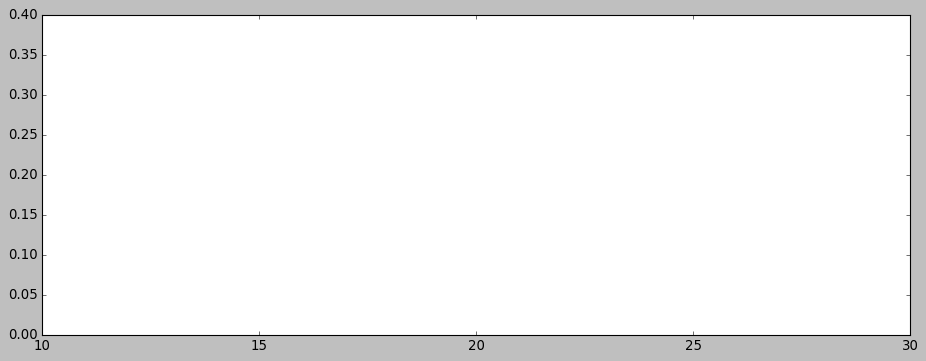

Number Correct:  173
Possible Number of Matches:  180

Event 147: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.93617021276596 %


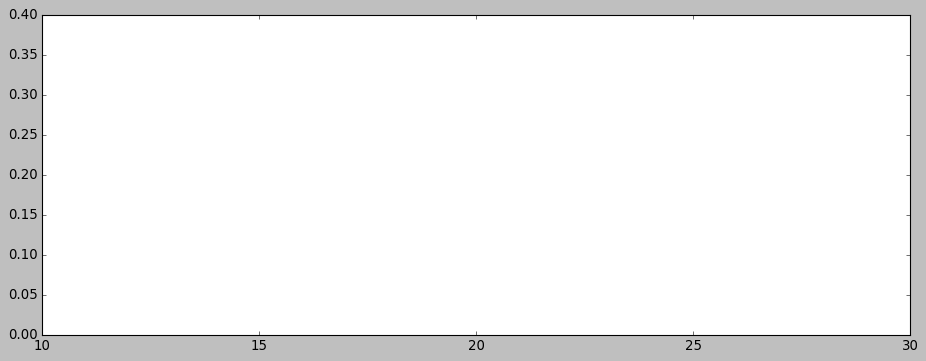

Number Correct:  185
Possible Number of Matches:  213

Event 148: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  88.44884488448845 %


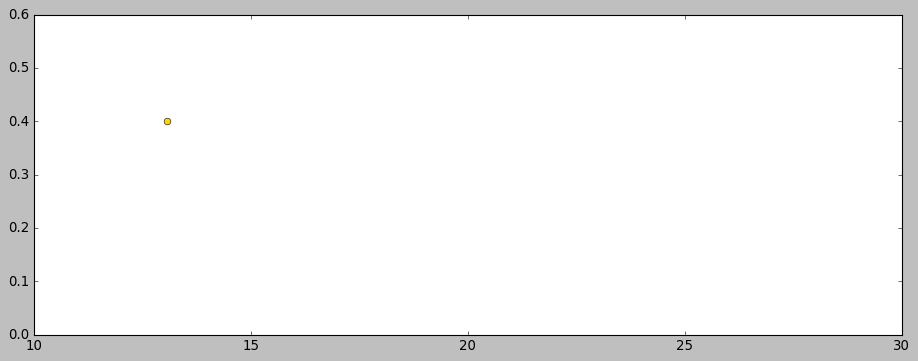

Number Correct:  227
Possible Number of Matches:  258

Event 149: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  93.7007874015748 %


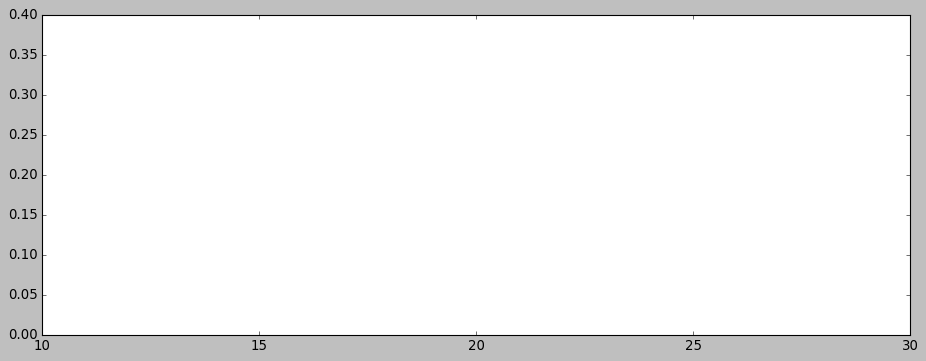

Number Correct:  112
Possible Number of Matches:  118

Event 150: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  82.03125 %


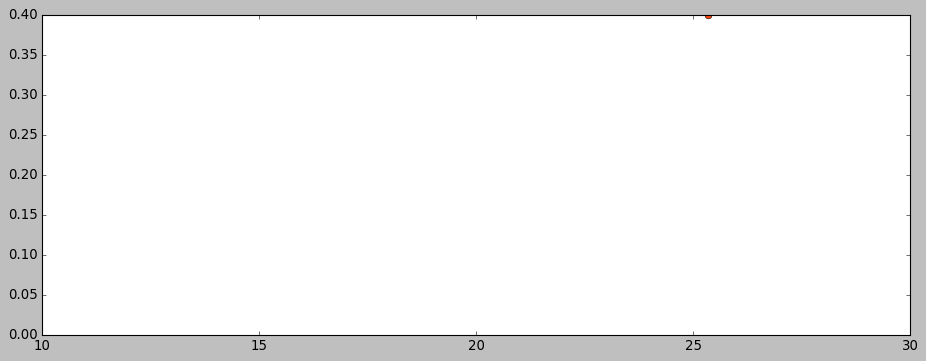

Number Correct:  101
Possible Number of Matches:  103

Event 151: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  88.8 %


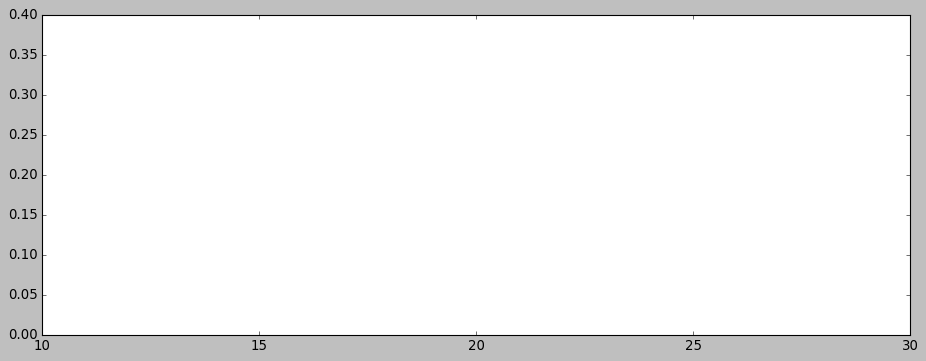

Number Correct:  106
Possible Number of Matches:  109

Event 152: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  72.06477732793522 %


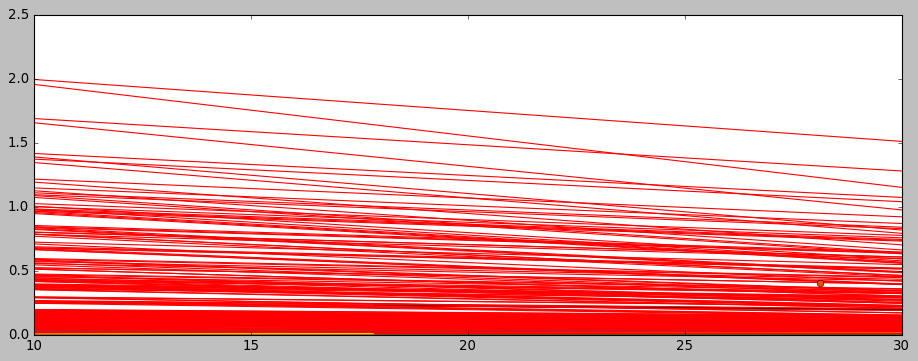

Number Correct:  339
Possible Number of Matches:  364

Event 153: Found 1 of 1, added 0 (eff 100.00%)
Percentage Matched =  88.88888888888889 %


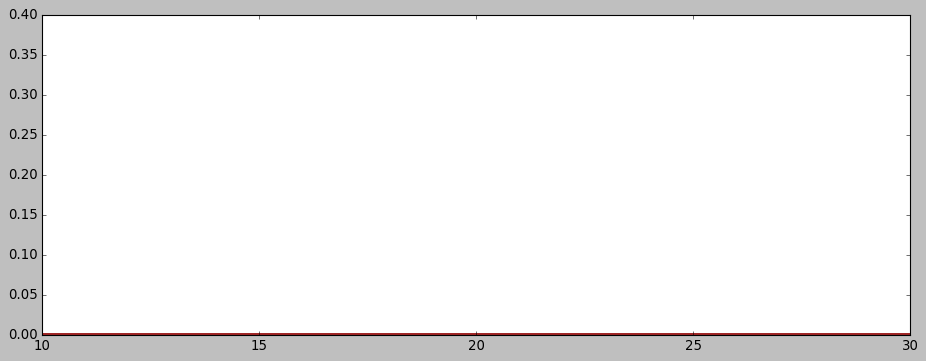

Number Correct:  64
Possible Number of Matches:  66

Event 154: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  91.41414141414141 %


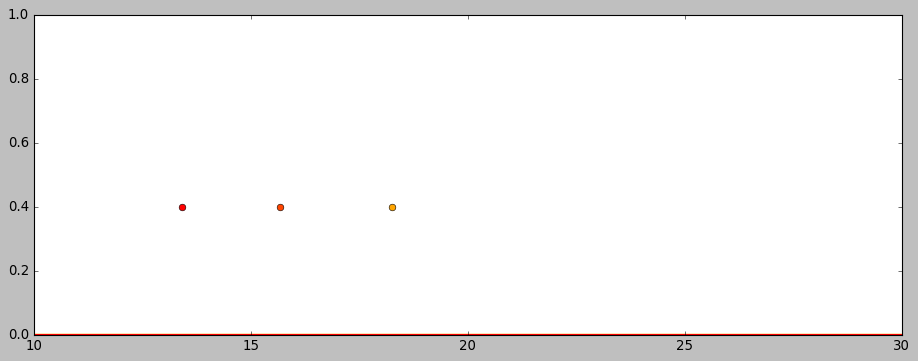

Number Correct:  164
Possible Number of Matches:  199

Event 155: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  85.13011152416357 %


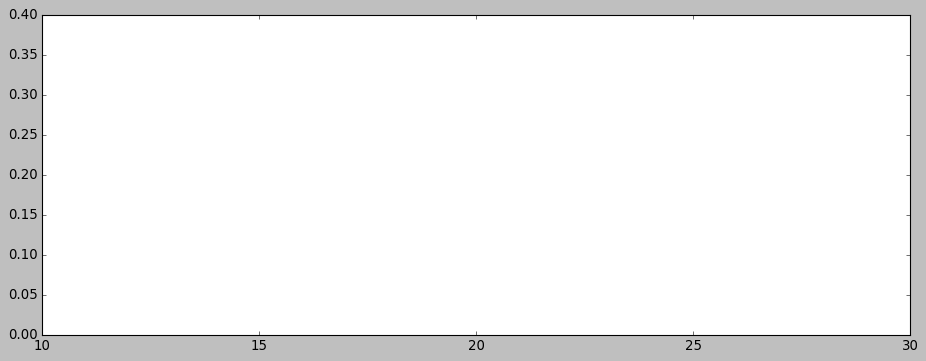

Number Correct:  198
Possible Number of Matches:  234

Event 156: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  86.9281045751634 %


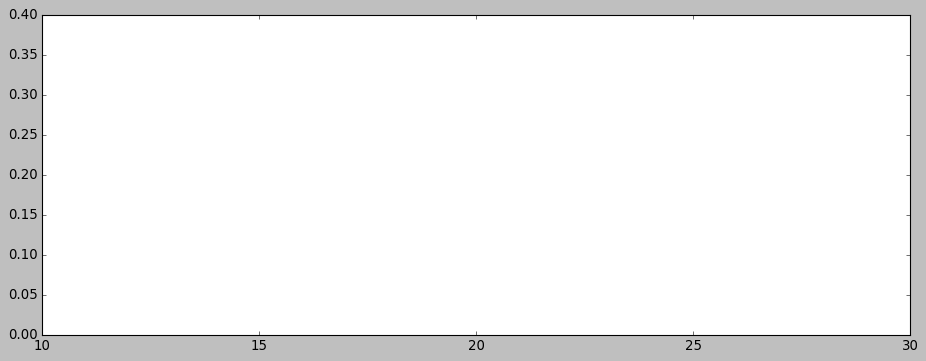

Number Correct:  132
Possible Number of Matches:  137

Event 157: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  51.0548523206751 %


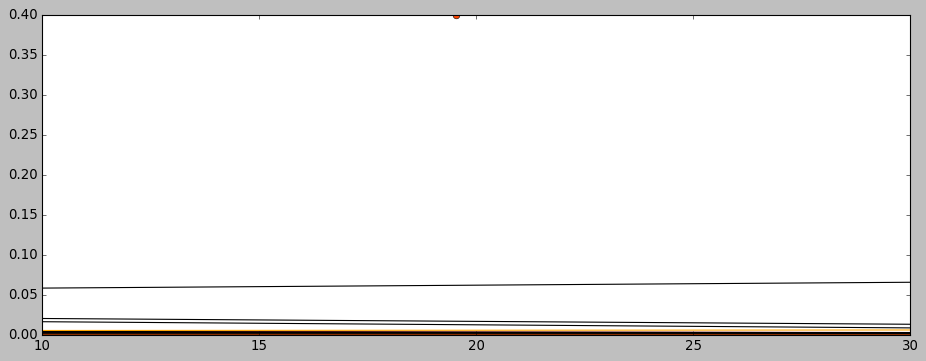

Number Correct:  107
Possible Number of Matches:  117

Event 158: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  81.27340823970037 %


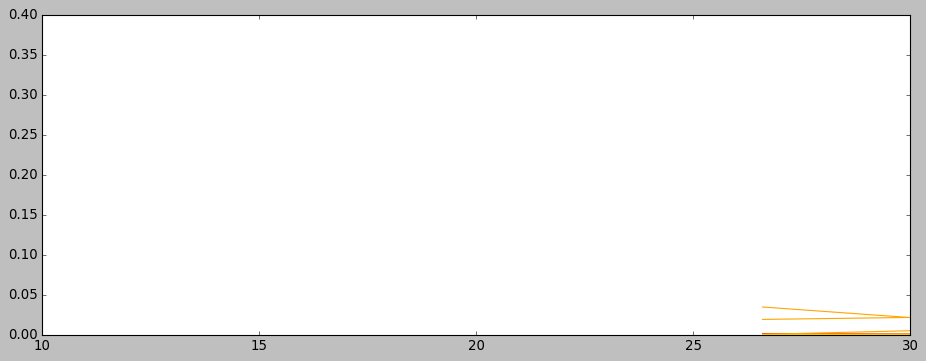

Number Correct:  198
Possible Number of Matches:  216

Event 159: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.54448398576513 %


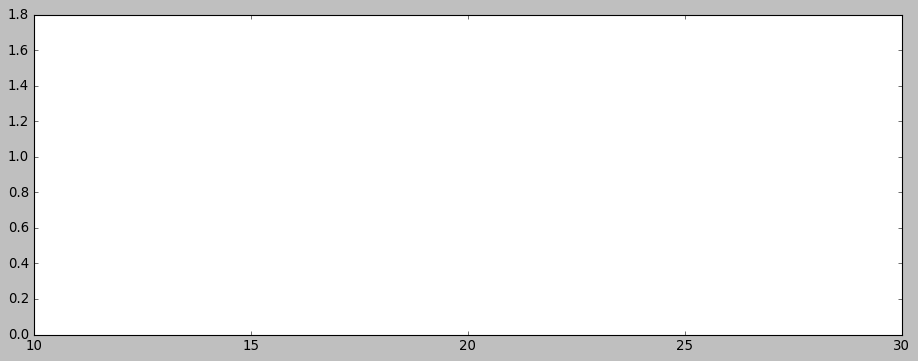

Number Correct:  224
Possible Number of Matches:  251

Event 160: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  86.60714285714286 %


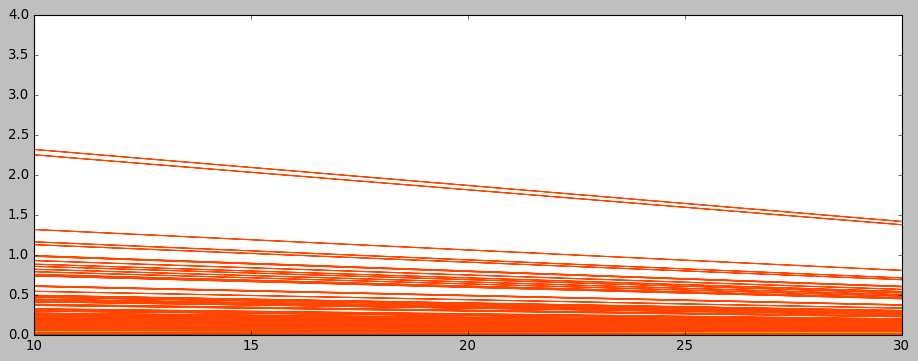

Number Correct:  271
Possible Number of Matches:  291

Event 161: Found 6 of 7, added 2 (eff 85.71%)
Percentage Matched =  86.61710037174721 %


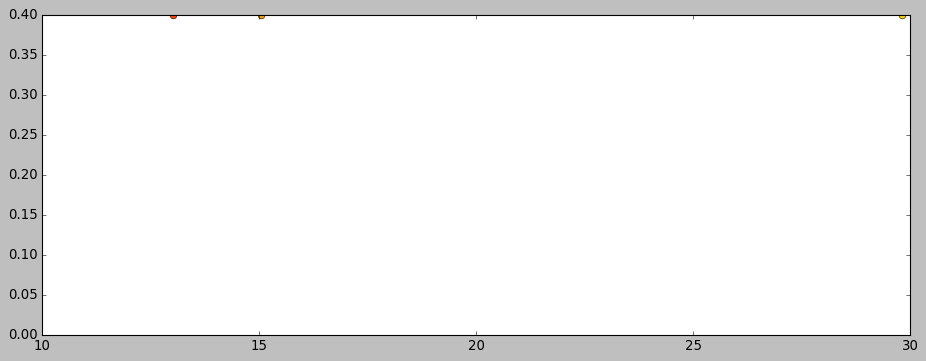

Number Correct:  215
Possible Number of Matches:  280

Event 162: Found 3 of 4, added 0 (eff 75.00%)
Percentage Matched =  77.35849056603773 %


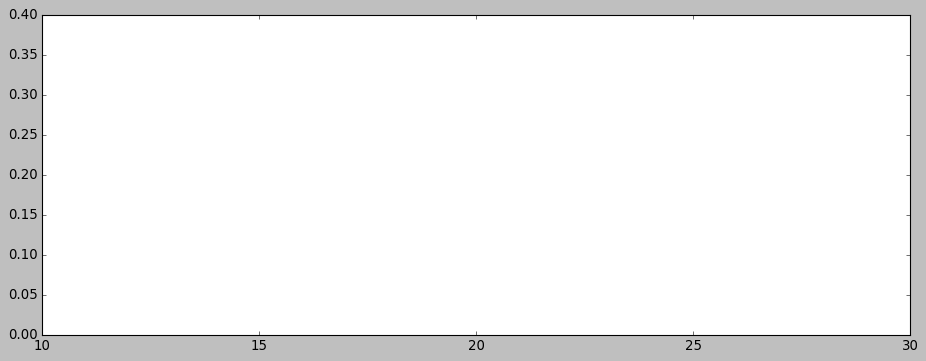

Number Correct:  59
Possible Number of Matches:  77

Event 163: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  58.306188925081436 %


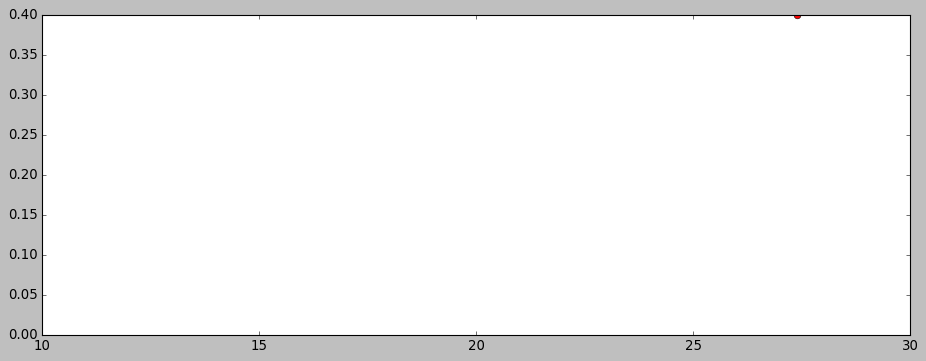

Number Correct:  159
Possible Number of Matches:  168

Event 164: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  86.08695652173913 %


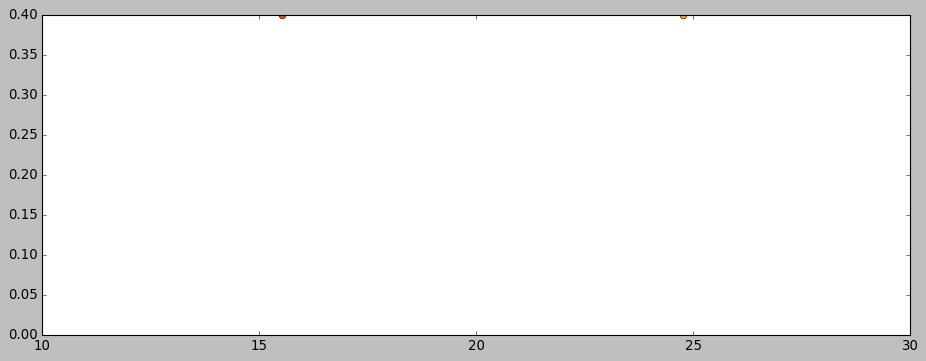

Number Correct:  171
Possible Number of Matches:  193

Event 165: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  85.85526315789474 %


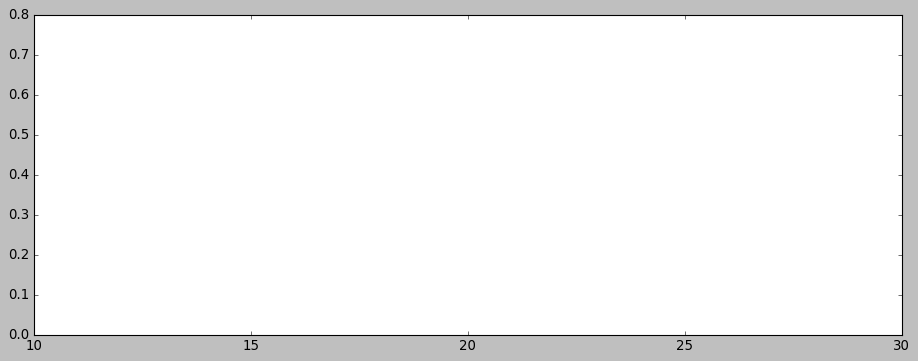

Number Correct:  247
Possible Number of Matches:  264

Event 166: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  75.93984962406014 %


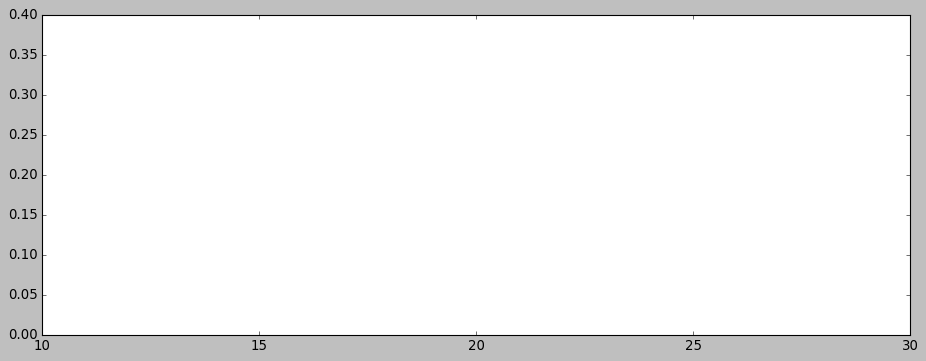

Number Correct:  99
Possible Number of Matches:  105

Event 167: Found 10 of 10, added 1 (eff 100.00%)
Percentage Matched =  94.4636678200692 %


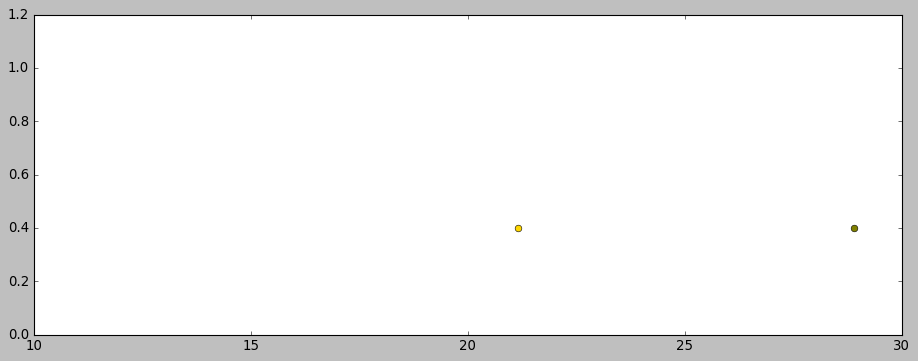

Number Correct:  243
Possible Number of Matches:  274

Event 168: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  88.88888888888889 %


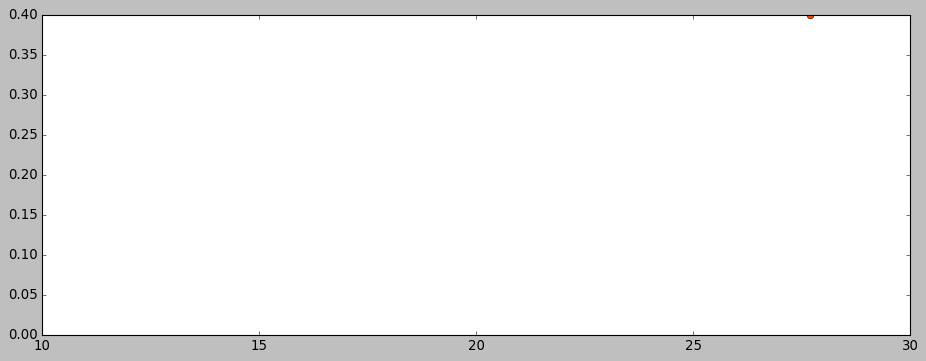

Number Correct:  39
Possible Number of Matches:  39

Event 169: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  81.21212121212122 %


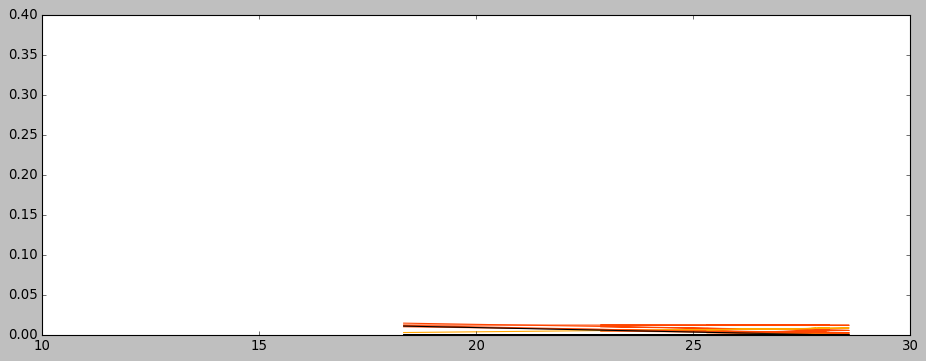

Number Correct:  128
Possible Number of Matches:  138

Event 170: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  82.57575757575758 %


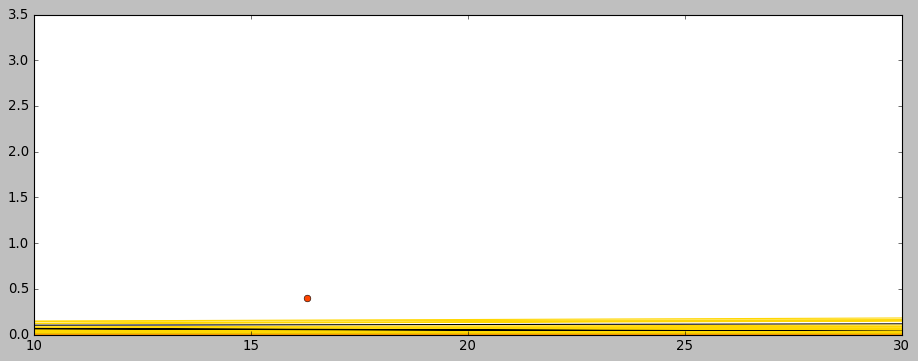

Number Correct:  202
Possible Number of Matches:  213

Event 171: Found 5 of 6, added 1 (eff 83.33%)
Percentage Matched =  94.79166666666667 %


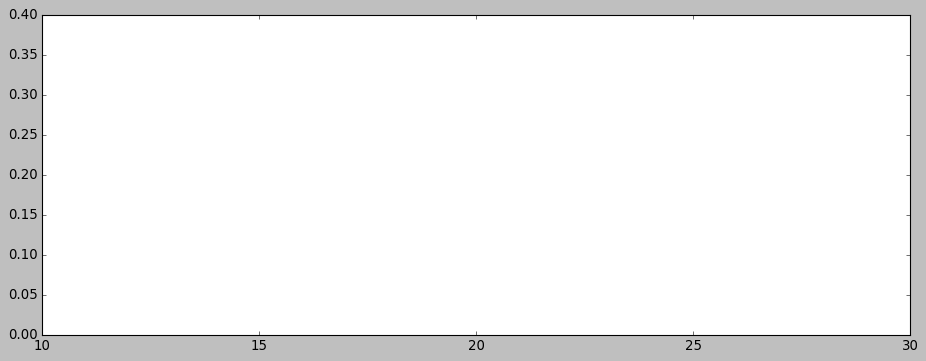

Number Correct:  89
Possible Number of Matches:  91

Event 172: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  79.33884297520662 %


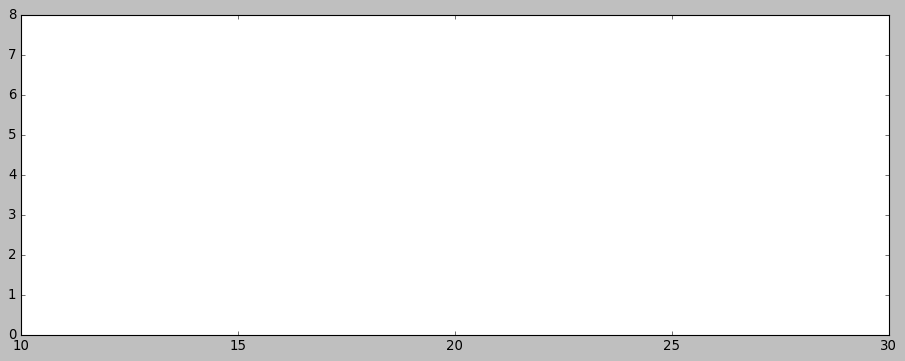

Number Correct:  95
Possible Number of Matches:  100

Event 173: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  86.70520231213872 %


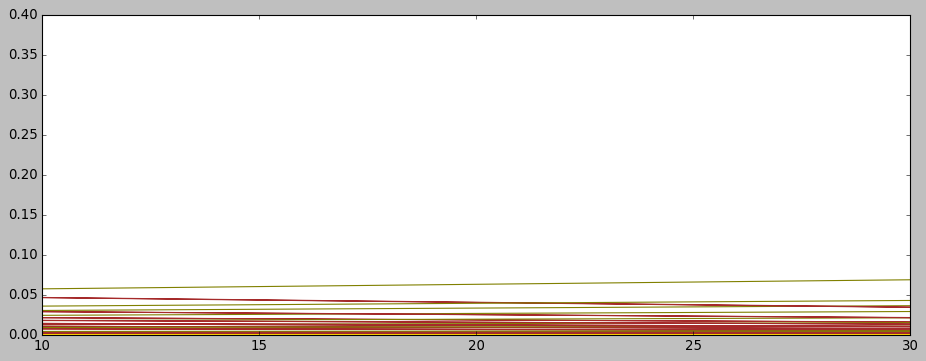

Number Correct:  141
Possible Number of Matches:  151

Event 174: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  83.16831683168317 %


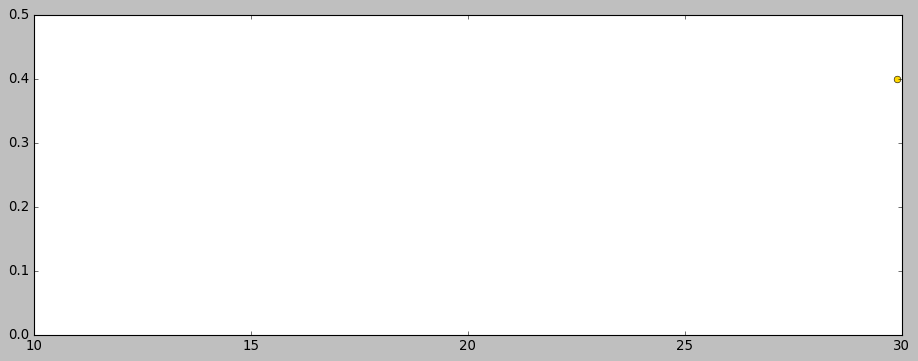

Number Correct:  145
Possible Number of Matches:  167

Event 175: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  83.62369337979094 %


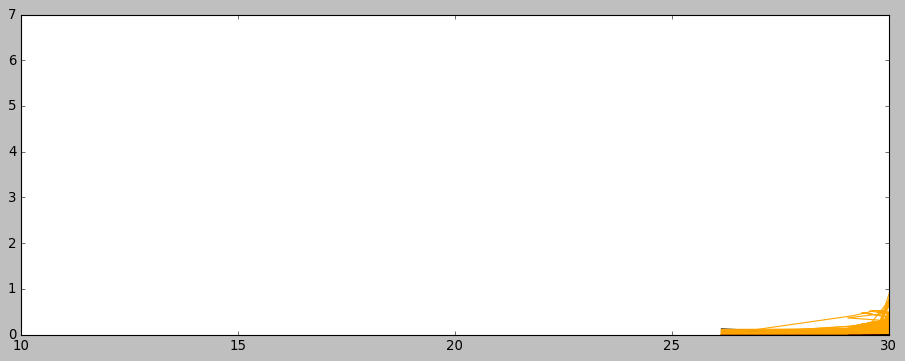

Number Correct:  235
Possible Number of Matches:  248

Event 176: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  89.45578231292517 %


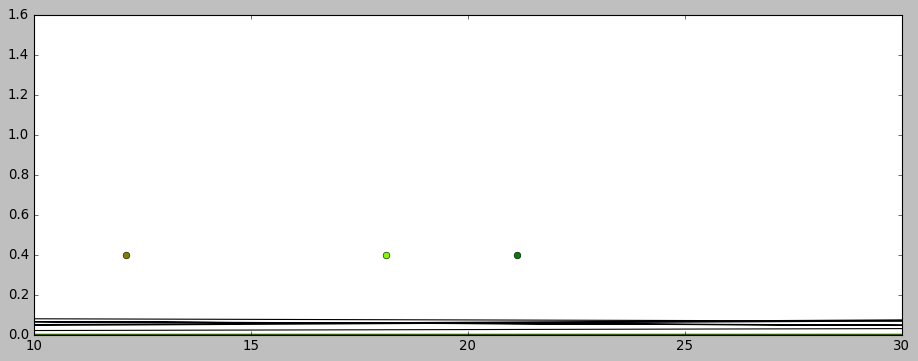

Number Correct:  235
Possible Number of Matches:  265

Event 177: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  87.71929824561404 %


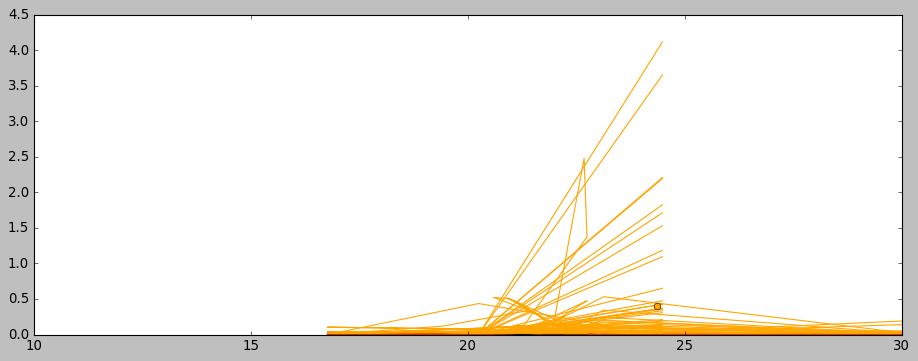

Number Correct:  189
Possible Number of Matches:  203

Event 178: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  88.19188191881919 %


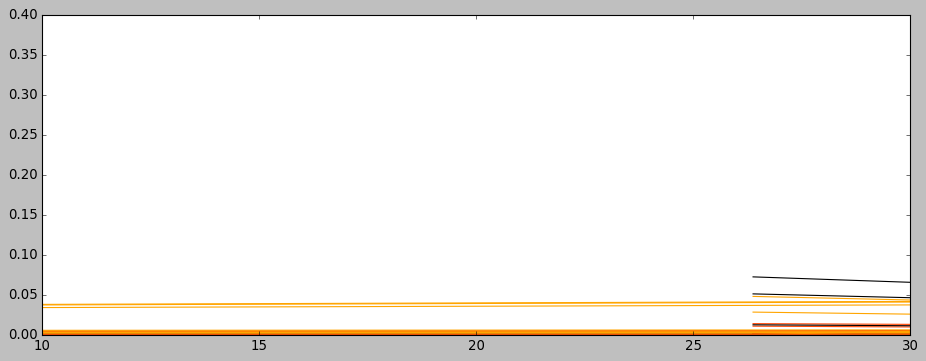

Number Correct:  220
Possible Number of Matches:  231

Event 179: Found 8 of 10, added 1 (eff 80.00%)
Percentage Matched =  89.30232558139535 %


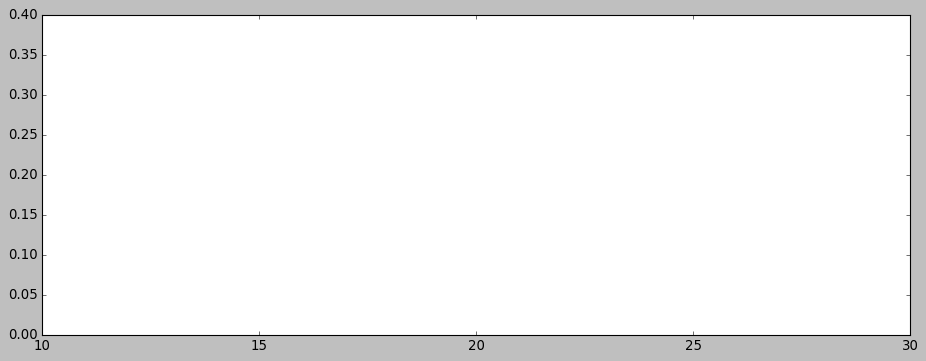

Number Correct:  329
Possible Number of Matches:  380

Event 180: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  79.20792079207921 %


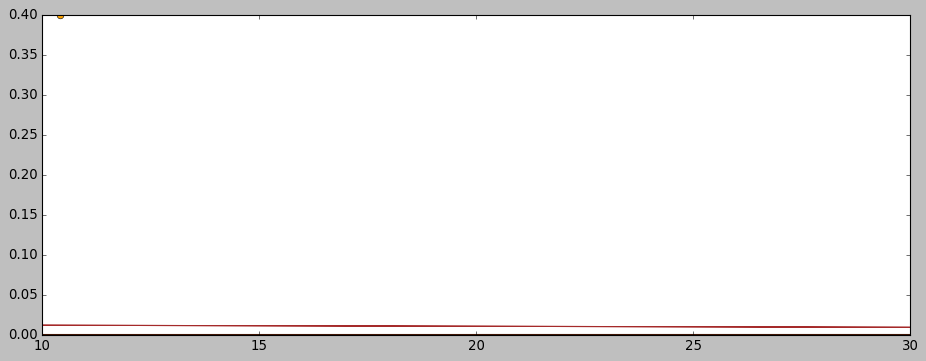

Number Correct:  149
Possible Number of Matches:  165

Event 181: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  84.7926267281106 %


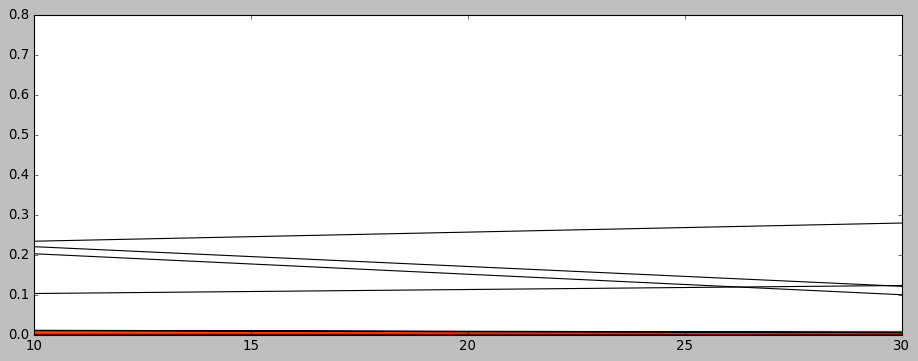

Number Correct:  180
Possible Number of Matches:  186

Event 182: Found 2 of 2, added 1 (eff 100.00%)
Percentage Matched =  68.29268292682927 %


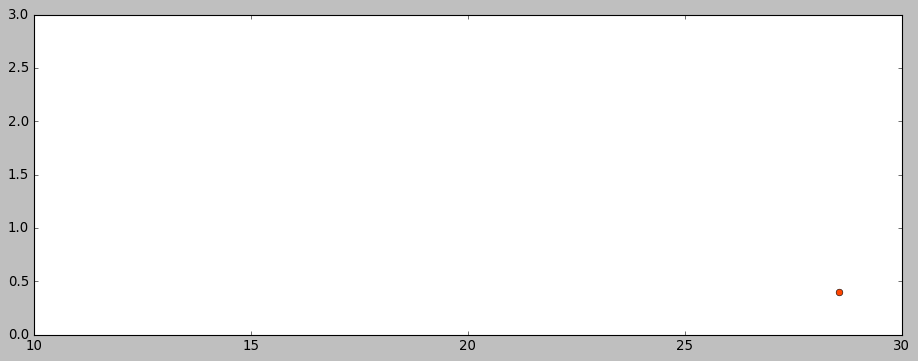

Number Correct:  213
Possible Number of Matches:  229

Event 183: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  89.88095238095238 %


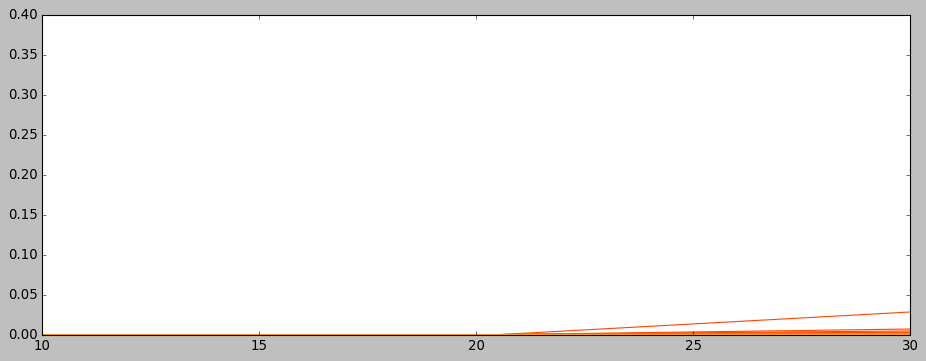

Number Correct:  147
Possible Number of Matches:  209

Event 184: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.67123287671232 %


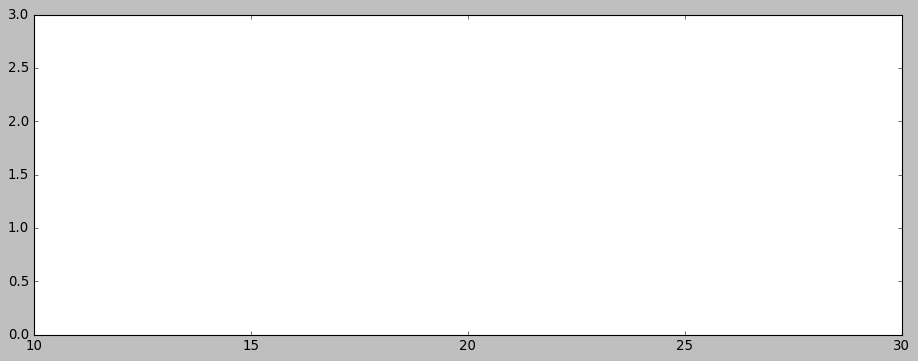

Number Correct:  124
Possible Number of Matches:  130

Event 185: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  81.48148148148148 %


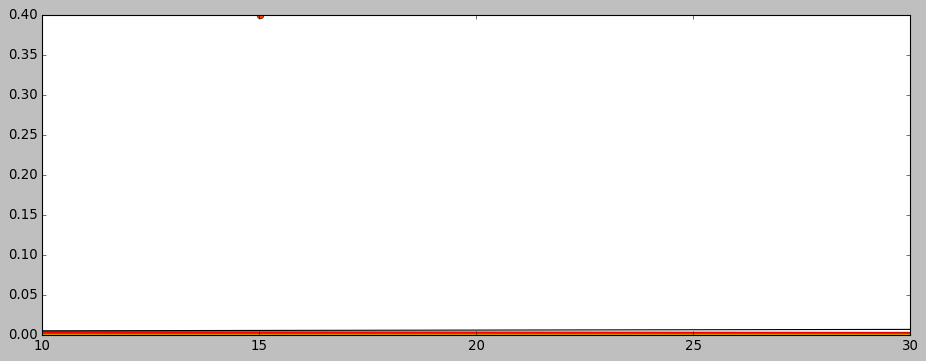

Number Correct:  187
Possible Number of Matches:  201

Event 186: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  86.54708520179372 %


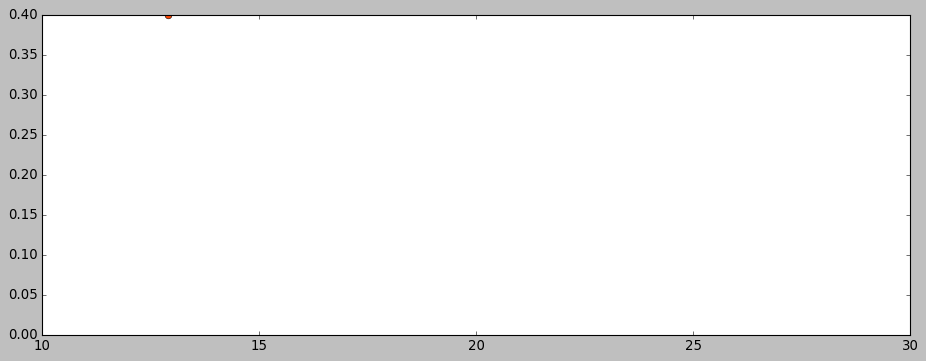

Number Correct:  189
Possible Number of Matches:  194

Event 187: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  92.77566539923954 %


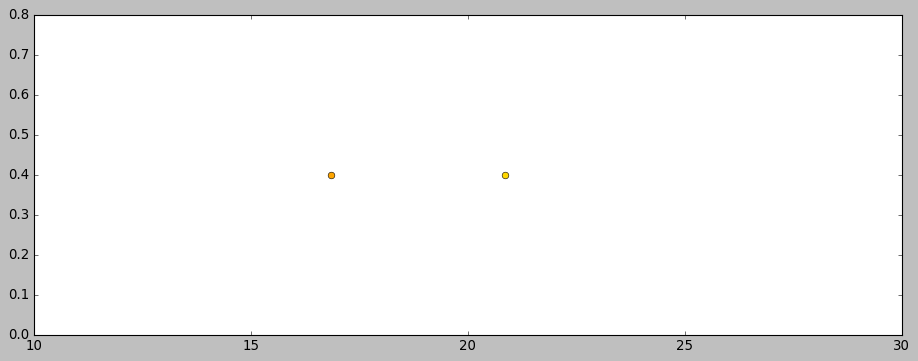

Number Correct:  221
Possible Number of Matches:  245

Event 188: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  88.95027624309392 %


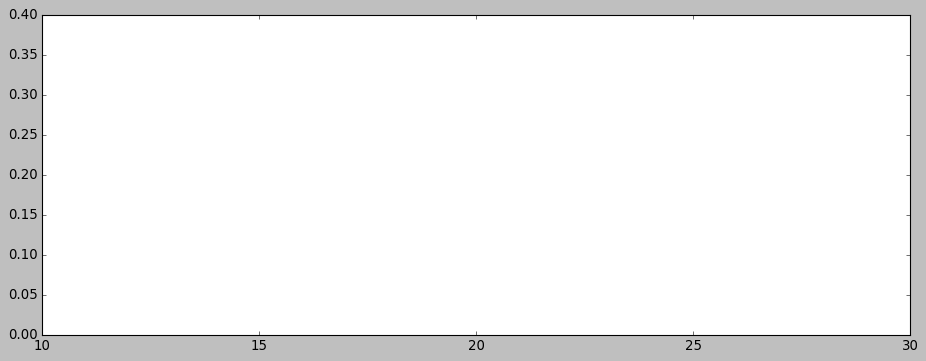

Number Correct:  152
Possible Number of Matches:  156

Event 189: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.26174496644295 %


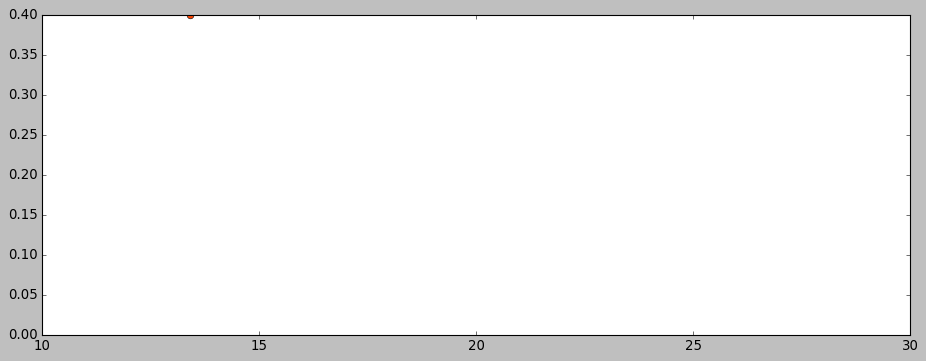

Number Correct:  131
Possible Number of Matches:  134

Event 190: Found 7 of 8, added 1 (eff 87.50%)
Percentage Matched =  74.52631578947368 %


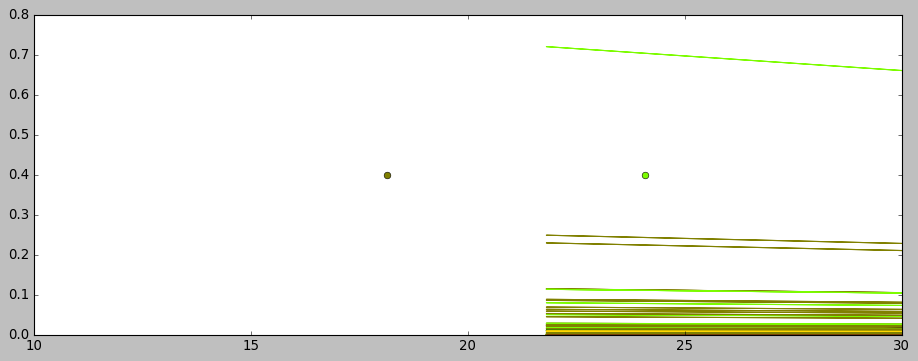

Number Correct:  304
Possible Number of Matches:  338

Event 191: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  48.611111111111114 %


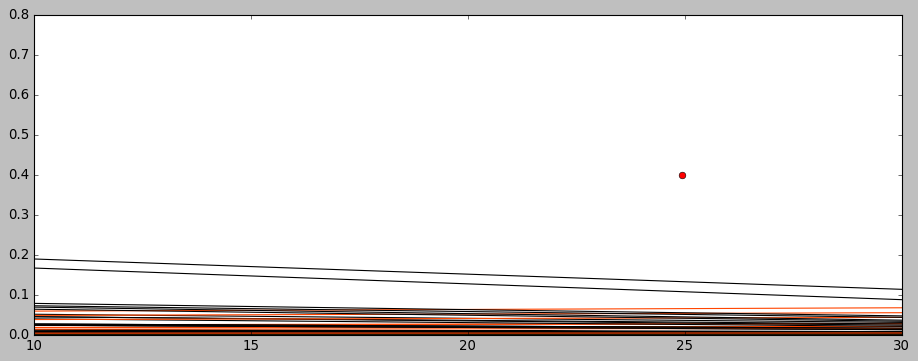

Number Correct:  98
Possible Number of Matches:  106

Event 192: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.26174496644295 %


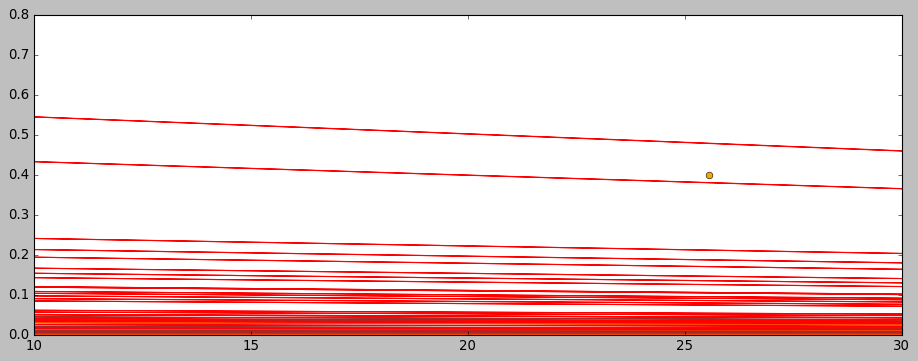

Number Correct:  121
Possible Number of Matches:  132

Event 193: Found 3 of 4, added 1 (eff 75.00%)
Percentage Matched =  81.33971291866028 %


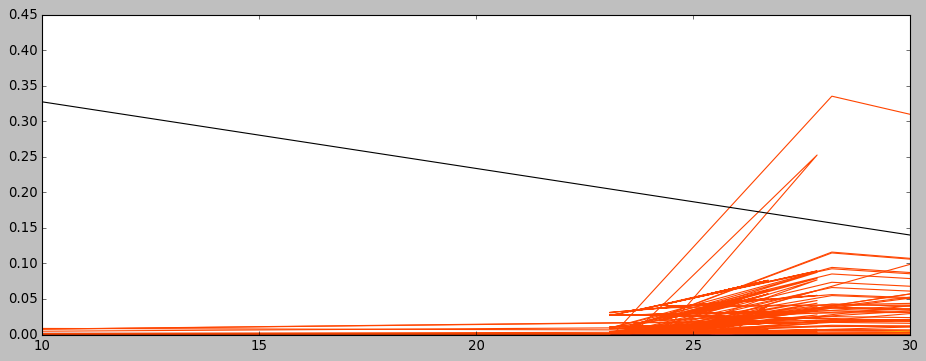

Number Correct:  150
Possible Number of Matches:  156

Event 194: Found 6 of 7, added 2 (eff 85.71%)
Percentage Matched =  83.95989974937343 %


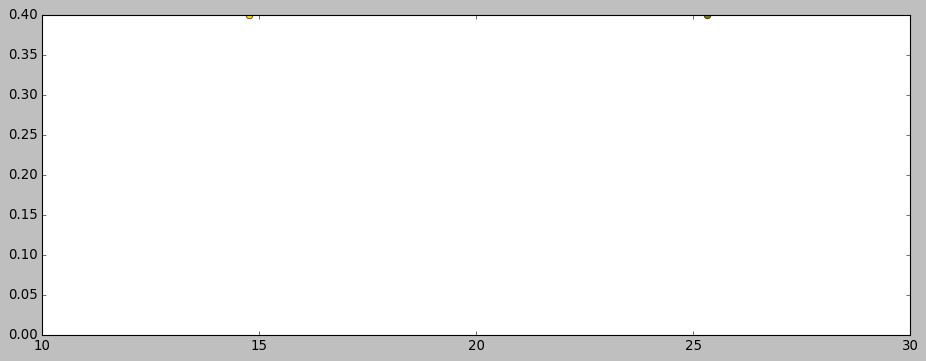

Number Correct:  313
Possible Number of Matches:  343

Event 195: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  85.29411764705883 %


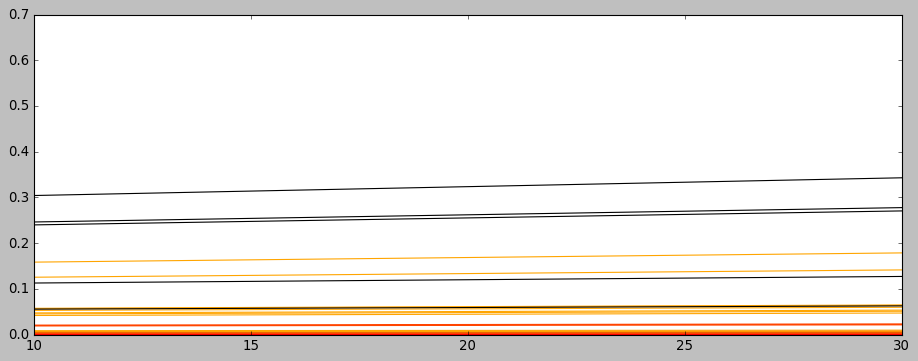

Number Correct:  78
Possible Number of Matches:  87

Event 196: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  88.96551724137932 %


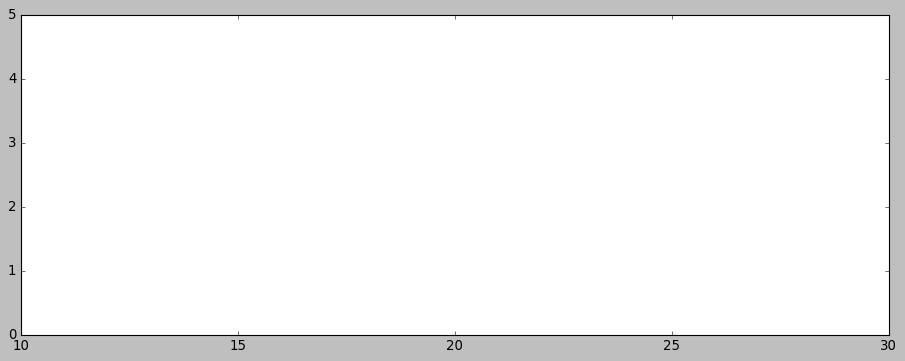

Number Correct:  99
Possible Number of Matches:  102

Event 197: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  92.04545454545455 %


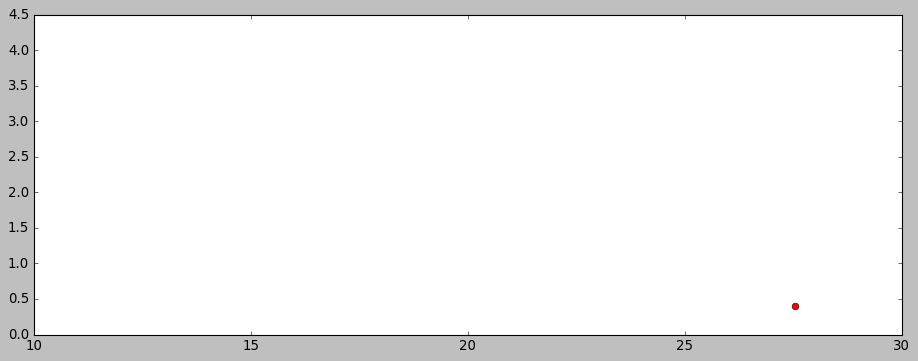

Number Correct:  158
Possible Number of Matches:  164

Event 198: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  89.44954128440367 %


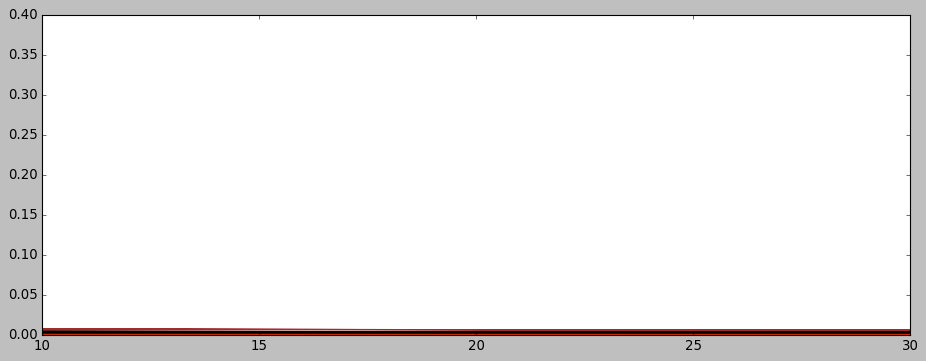

Number Correct:  175
Possible Number of Matches:  190

Event 199: Found 2 of 2, added 2 (eff 100.00%)
Percentage Matched =  89.68481375358166 %


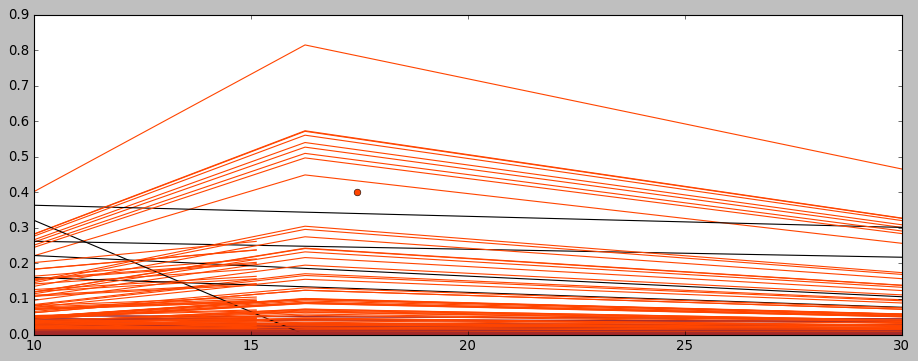

Number Correct:  282
Possible Number of Matches:  299

Event 200: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  91.5 %


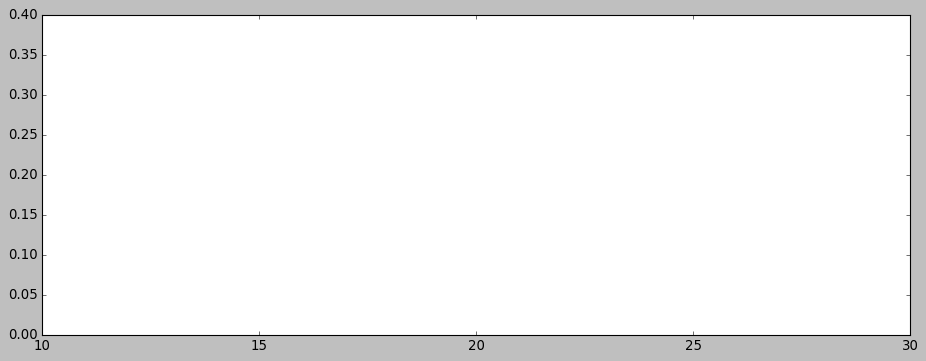

Number Correct:  175
Possible Number of Matches:  180

Event 201: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  61.111111111111114 %


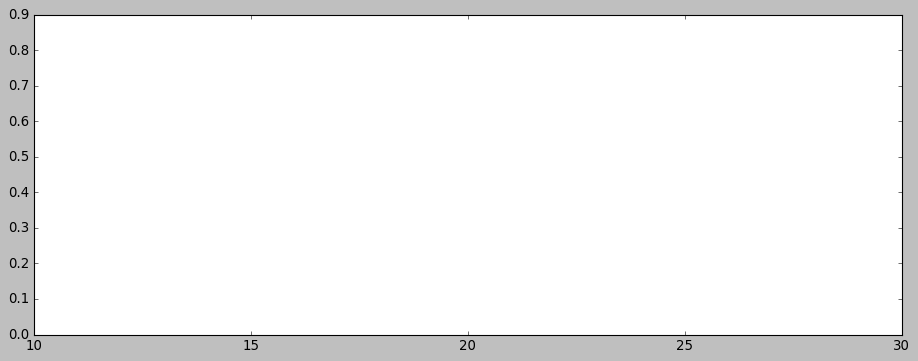

Number Correct:  109
Possible Number of Matches:  120

Event 202: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  90.51094890510949 %


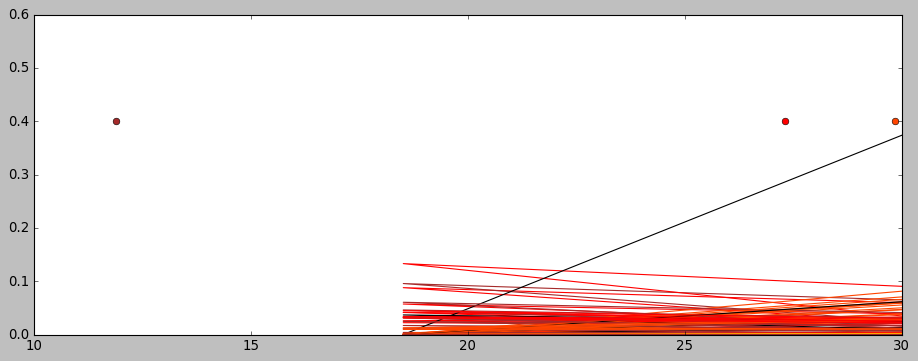

Number Correct:  168
Possible Number of Matches:  200

Event 203: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  87.23404255319149 %


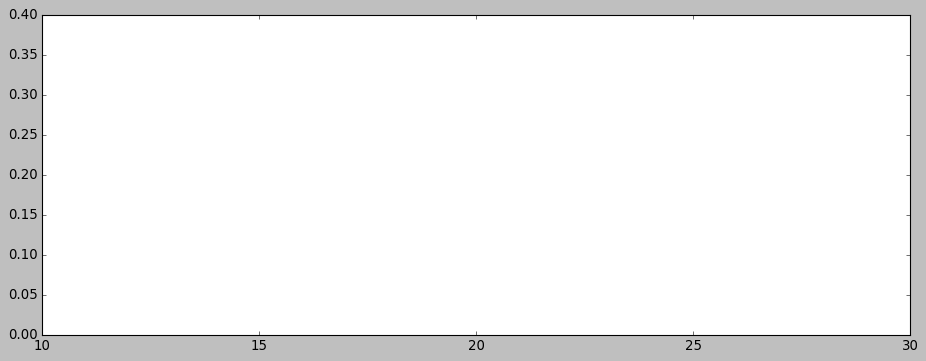

Number Correct:  157
Possible Number of Matches:  163

Event 204: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  88.04347826086956 %


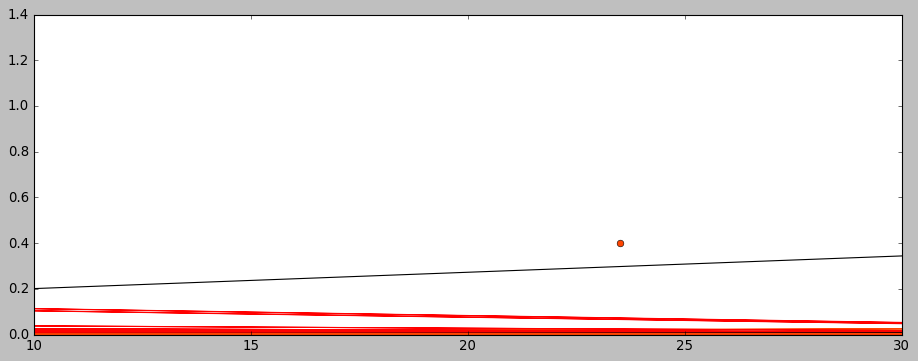

Number Correct:  159
Possible Number of Matches:  164

Event 205: Found 10 of 11, added 3 (eff 90.91%)
Percentage Matched =  90.33018867924528 %


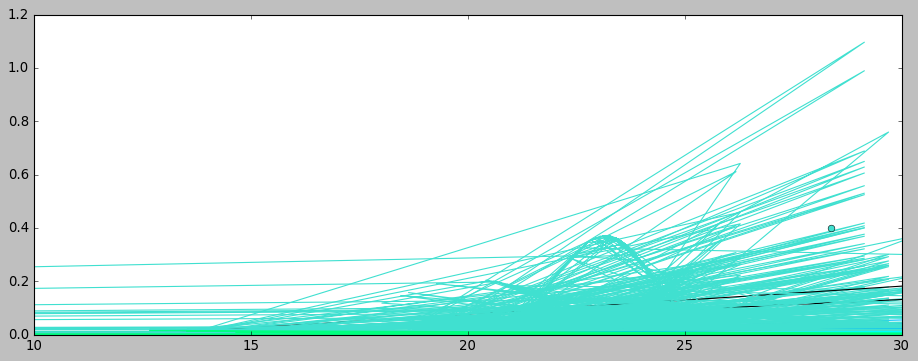

Number Correct:  348
Possible Number of Matches:  488

Event 206: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  90.72847682119205 %


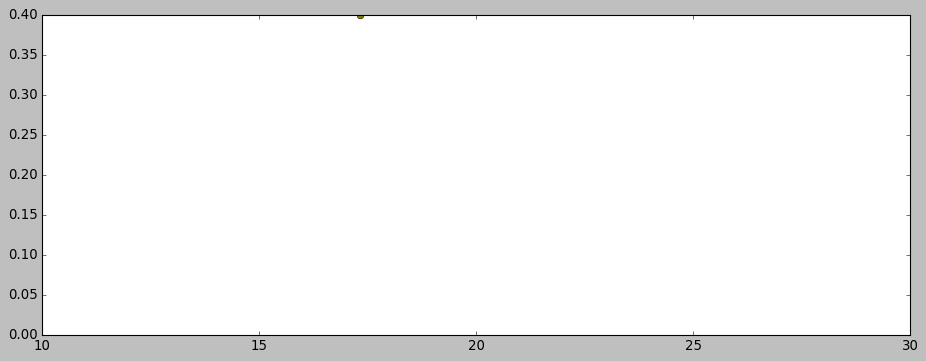

Number Correct:  109
Possible Number of Matches:  133

Event 207: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  82.84671532846716 %


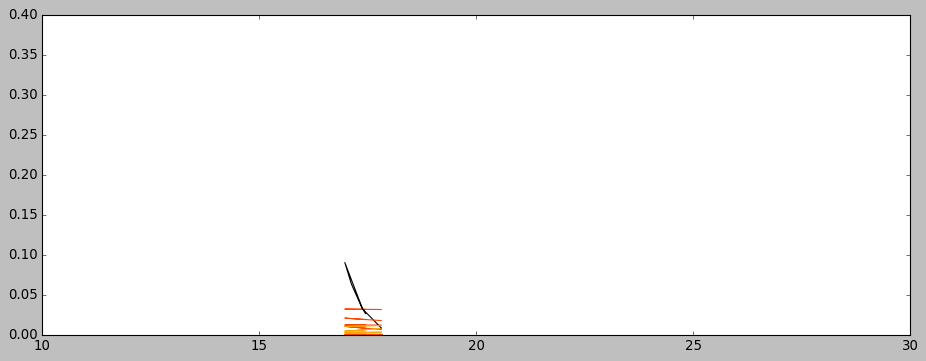

Number Correct:  214
Possible Number of Matches:  222

Event 208: Found 5 of 6, added 1 (eff 83.33%)
Percentage Matched =  70.31963470319634 %


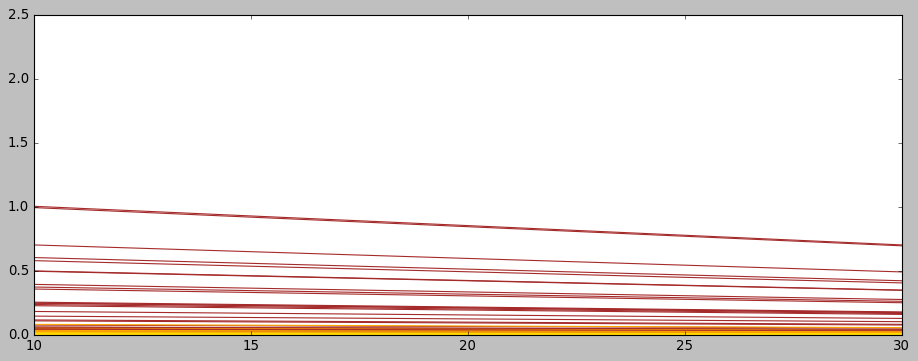

Number Correct:  108
Possible Number of Matches:  120

Event 209: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  87.01298701298701 %


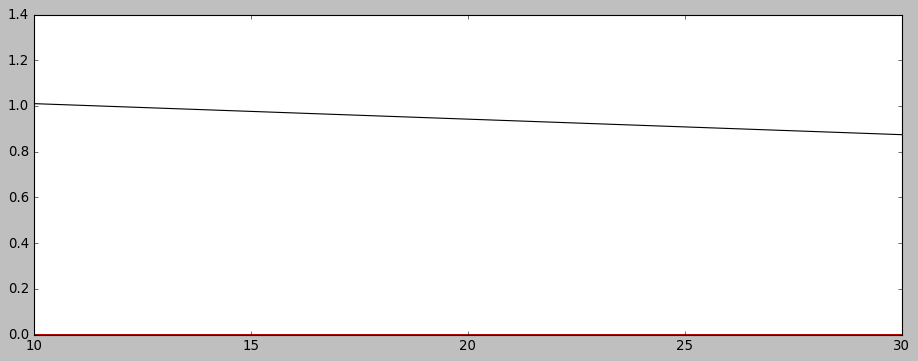

Number Correct:  67
Possible Number of Matches:  69

Event 210: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  78.28282828282828 %


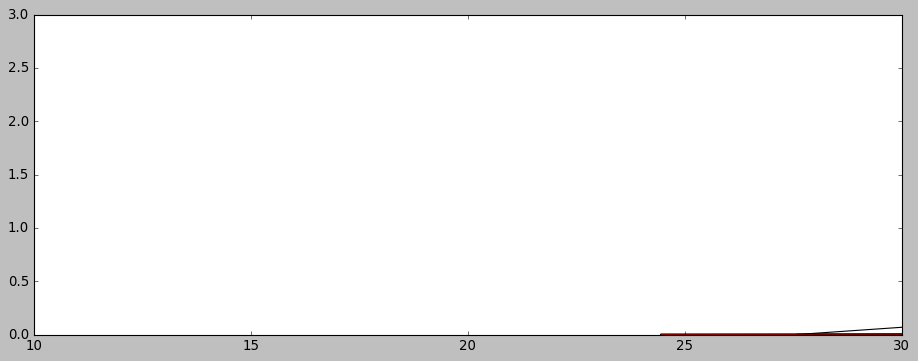

Number Correct:  152
Possible Number of Matches:  162

Event 211: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  89.14728682170542 %


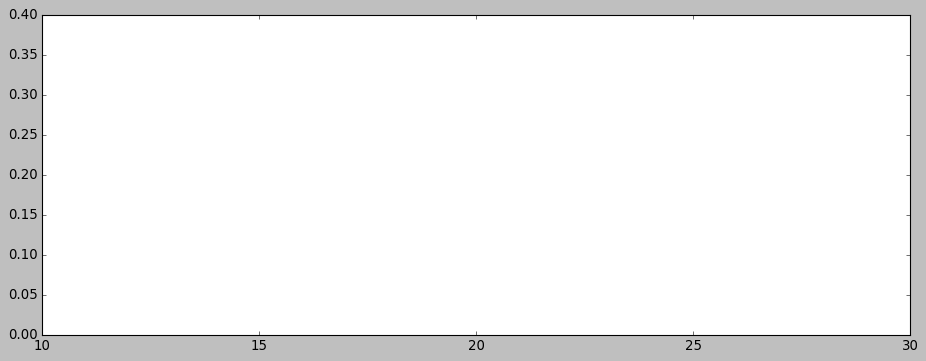

Number Correct:  107
Possible Number of Matches:  119

Event 212: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  90.95890410958904 %


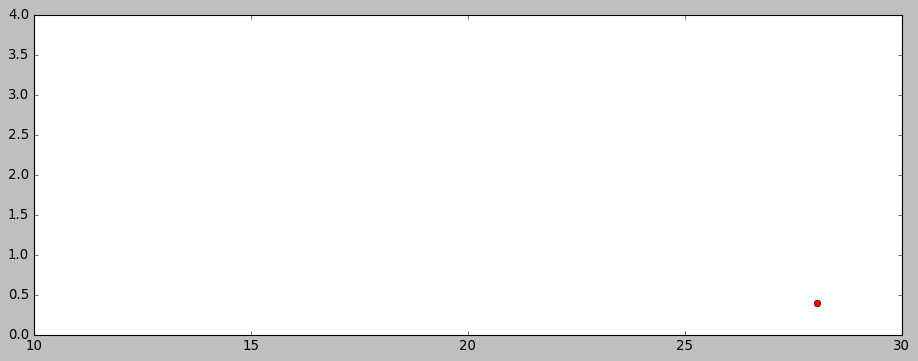

Number Correct:  287
Possible Number of Matches:  330

Event 213: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  68.65671641791045 %


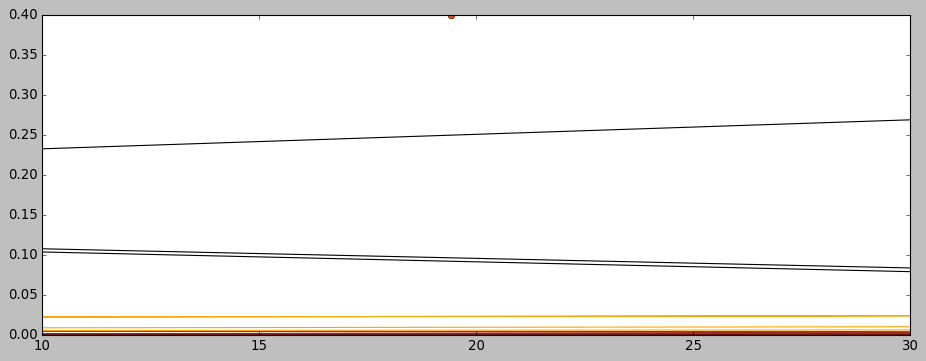

Number Correct:  87
Possible Number of Matches:  89

Event 214: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  92.5 %


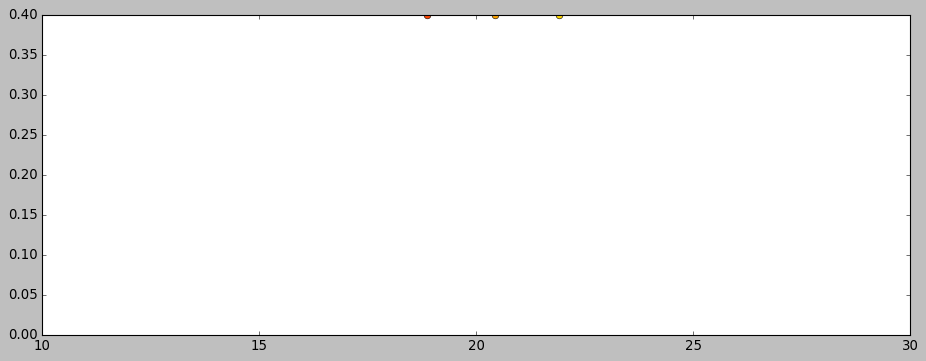

Number Correct:  219
Possible Number of Matches:  337

Event 215: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  74.02985074626865 %


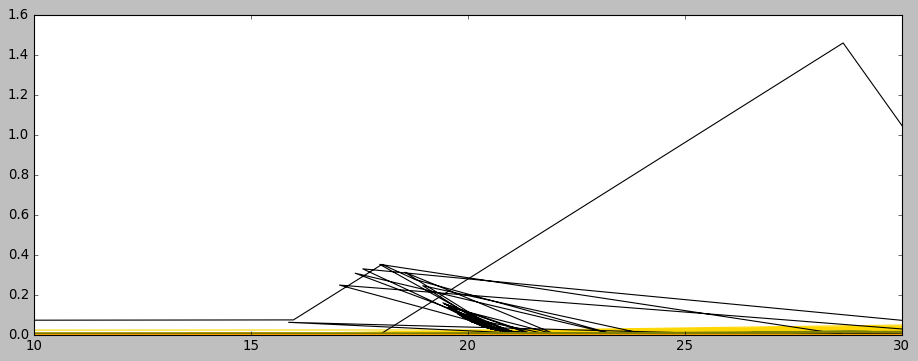

Number Correct:  208
Possible Number of Matches:  251

Event 216: Found 2 of 3, added 1 (eff 66.67%)
Percentage Matched =  89.1025641025641 %


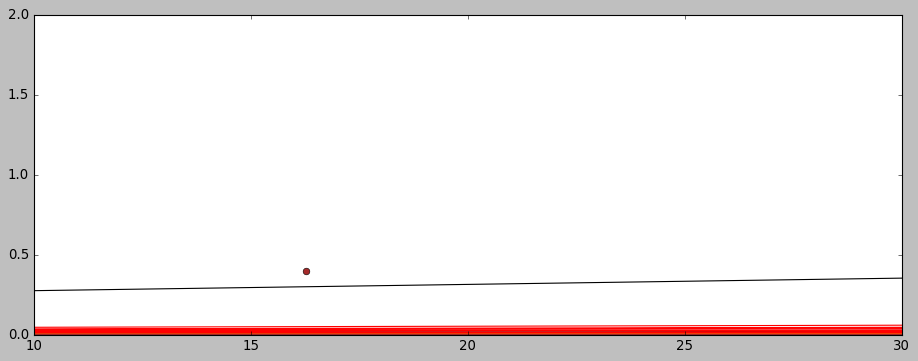

Number Correct:  121
Possible Number of Matches:  140

Event 217: Found 6 of 7, added 1 (eff 85.71%)
Percentage Matched =  93.11926605504587 %


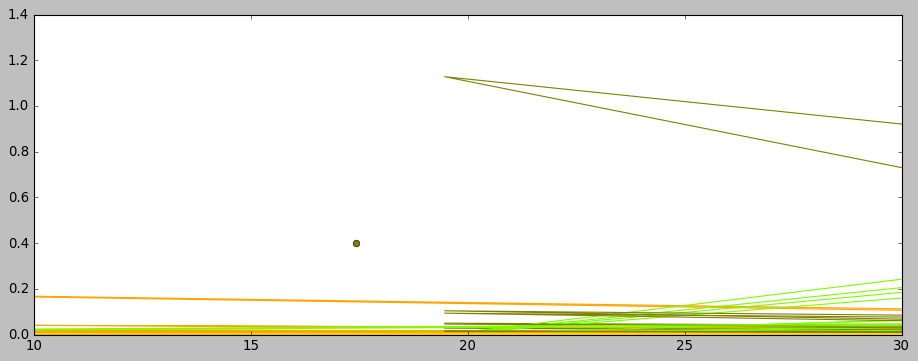

Number Correct:  178
Possible Number of Matches:  192

Event 218: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  87.71331058020478 %


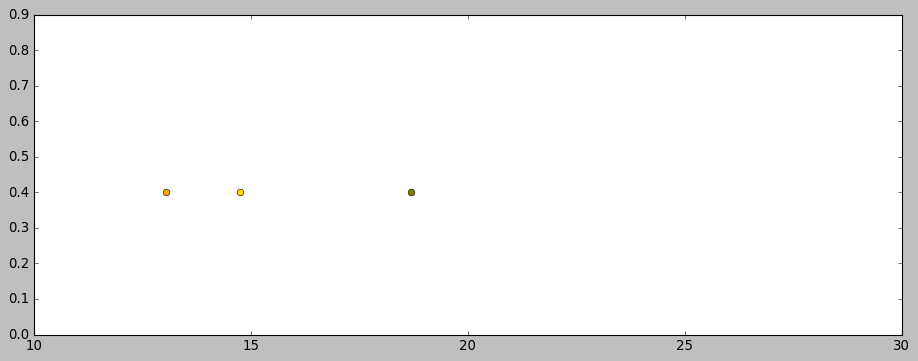

Number Correct:  224
Possible Number of Matches:  260

Event 219: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  85.16746411483254 %


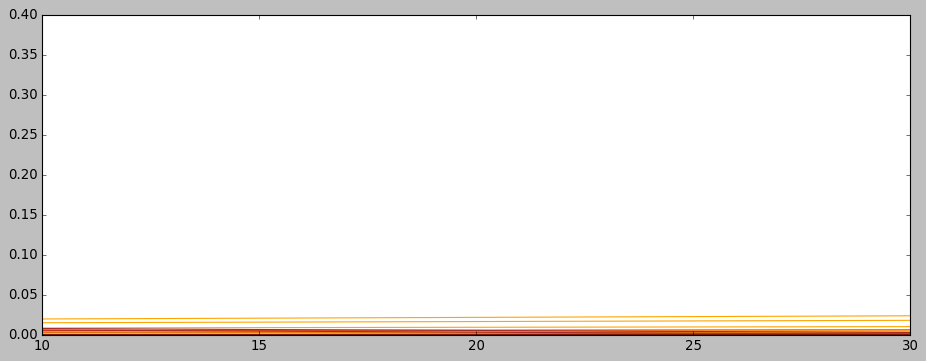

Number Correct:  157
Possible Number of Matches:  172

Event 220: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  89.24731182795699 %


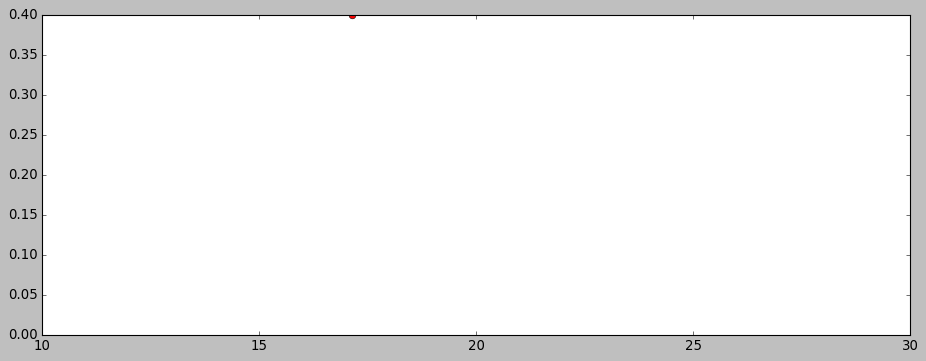

Number Correct:  78
Possible Number of Matches:  82

Event 221: Found 8 of 8, added 2 (eff 100.00%)
Percentage Matched =  92.26932668329177 %


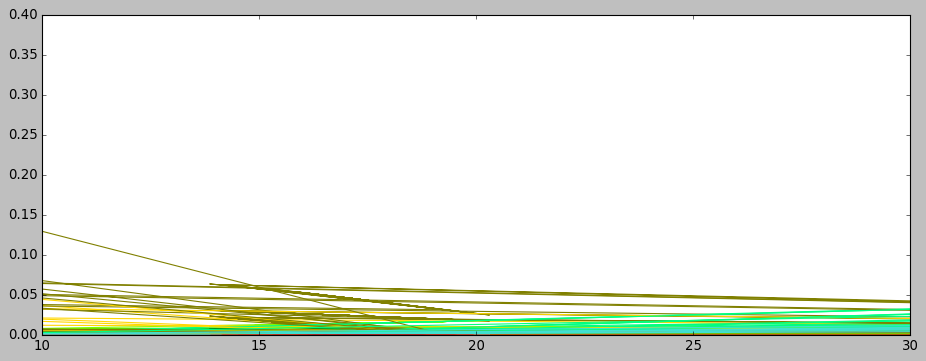

Number Correct:  338
Possible Number of Matches:  448

Event 222: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  86.02150537634408 %


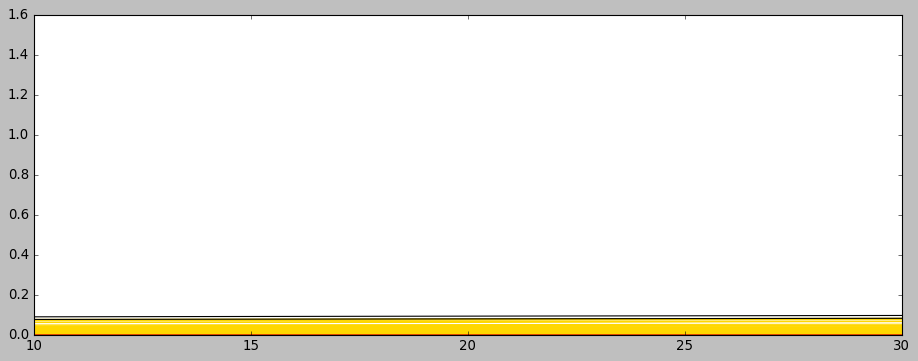

Number Correct:  211
Possible Number of Matches:  232

Event 223: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  75.67567567567568 %


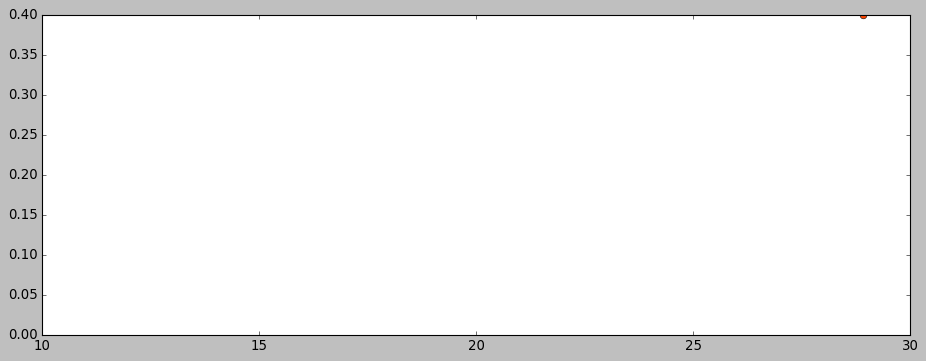

Number Correct:  105
Possible Number of Matches:  107

Event 224: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.5776397515528 %


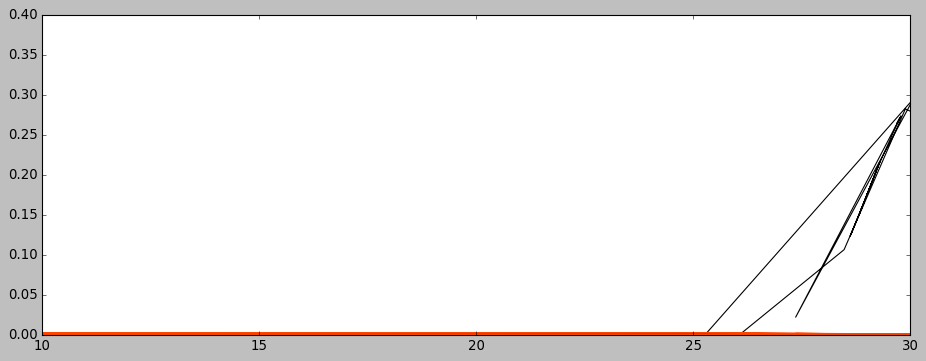

Number Correct:  137
Possible Number of Matches:  142

Event 225: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  84.7107438016529 %


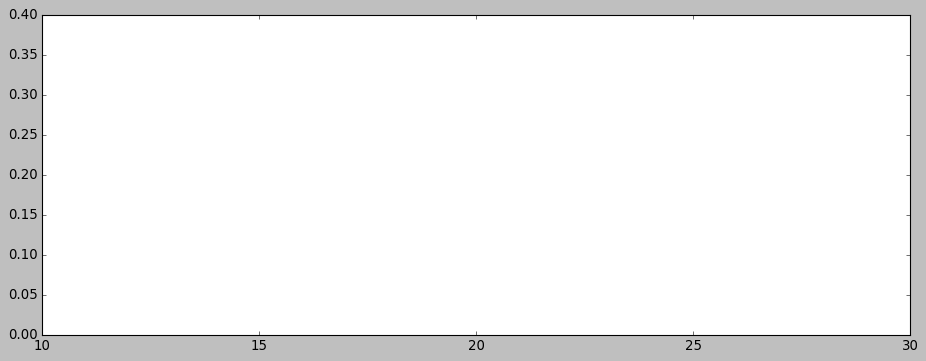

Number Correct:  195
Possible Number of Matches:  206

Event 226: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  88.69047619047619 %


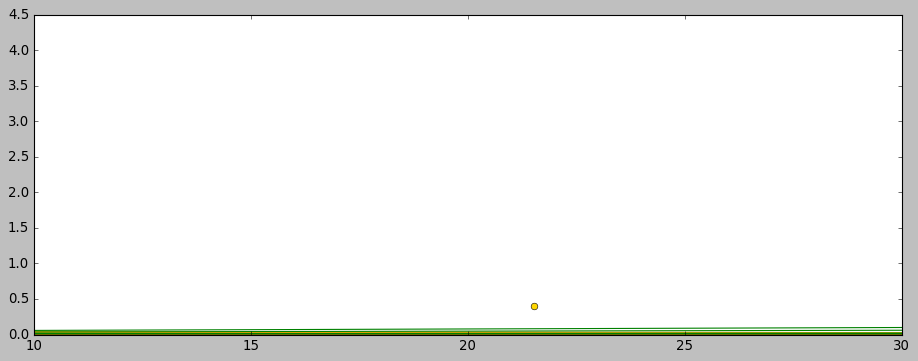

Number Correct:  258
Possible Number of Matches:  300

Event 227: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  50.37593984962406 %


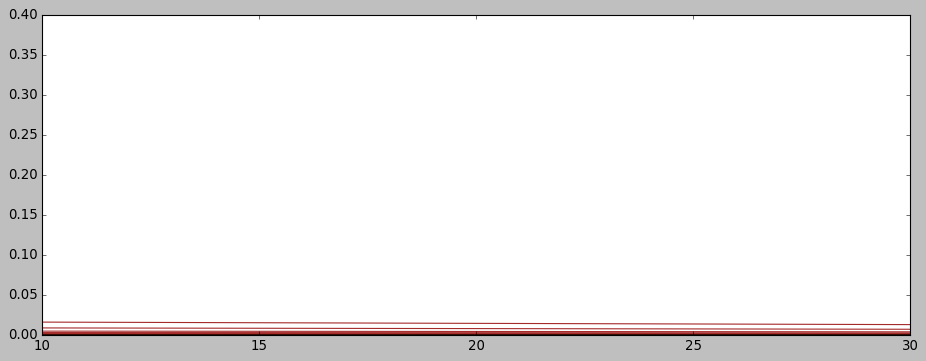

Number Correct:  39
Possible Number of Matches:  45

Event 228: Found 6 of 7, added 1 (eff 85.71%)
Percentage Matched =  94.09594095940959 %


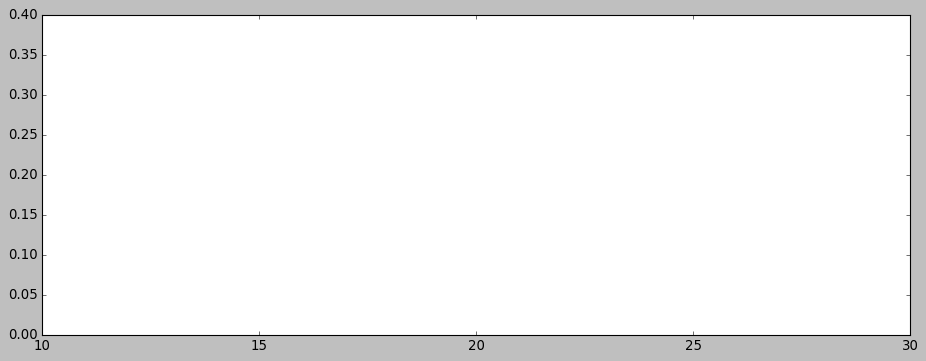

Number Correct:  185
Possible Number of Matches:  271

Event 229: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  88.73239436619718 %


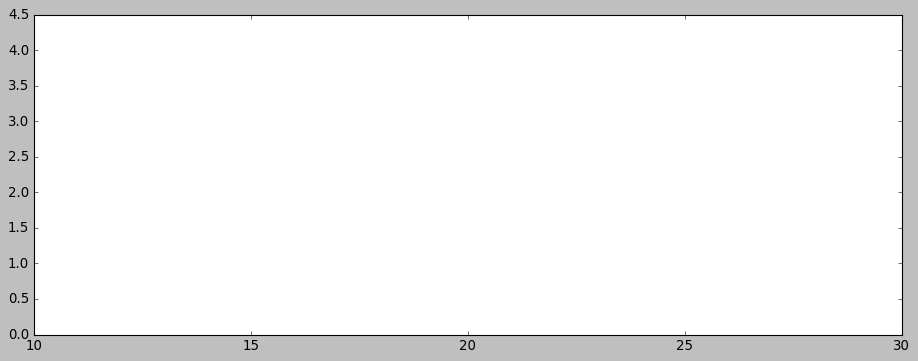

Number Correct:  107
Possible Number of Matches:  116

Event 230: Found 3 of 4, added 0 (eff 75.00%)
Percentage Matched =  85.8695652173913 %


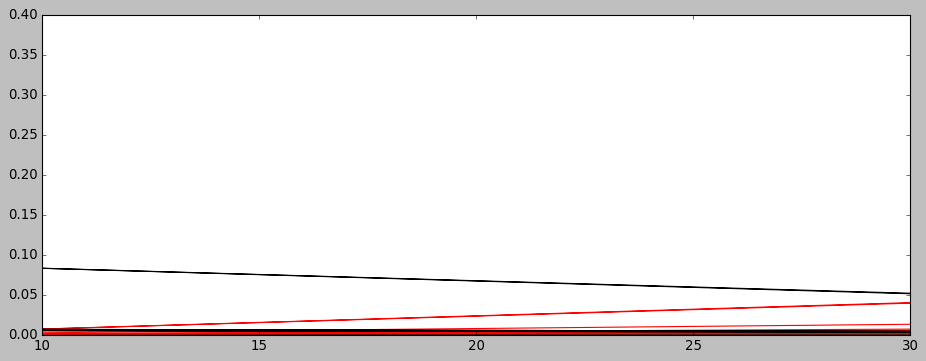

Number Correct:  79
Possible Number of Matches:  79

Event 231: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  89.70588235294117 %


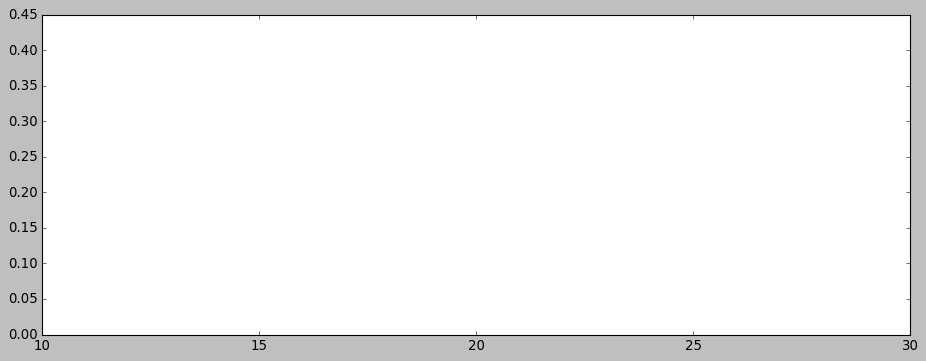

Number Correct:  56
Possible Number of Matches:  58

Event 232: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  72.01492537313433 %


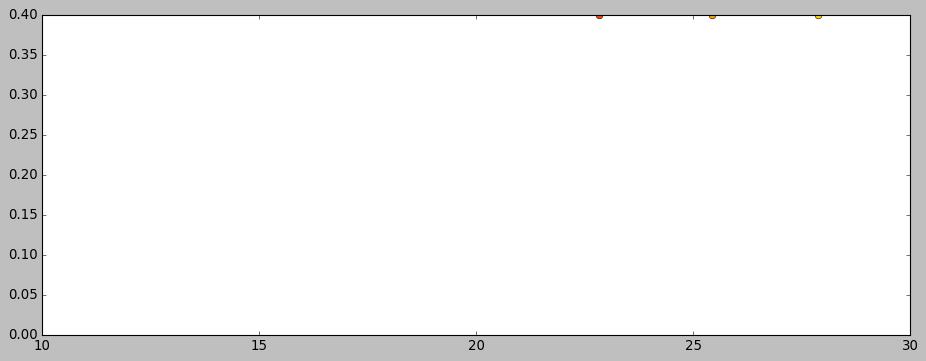

Number Correct:  174
Possible Number of Matches:  196

Event 233: Found 5 of 6, added 0 (eff 83.33%)
Percentage Matched =  88.58858858858859 %


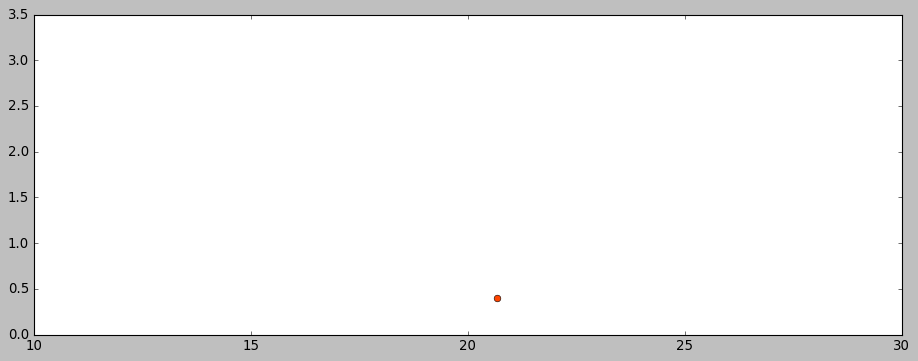

Number Correct:  230
Possible Number of Matches:  244

Event 234: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  81.12449799196787 %


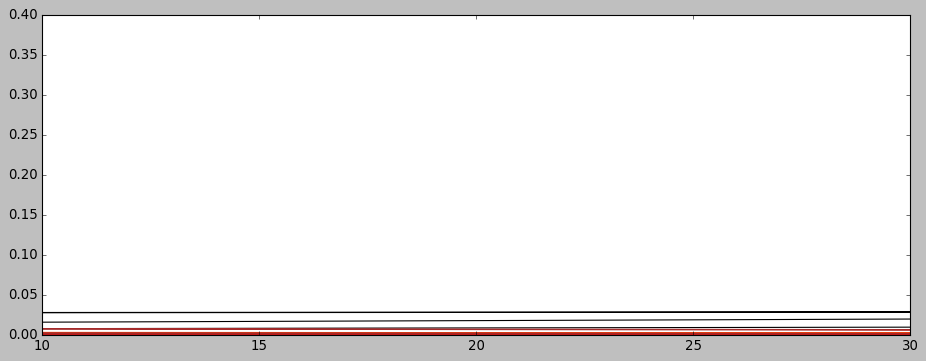

Number Correct:  162
Possible Number of Matches:  196

Event 235: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  84.89208633093526 %


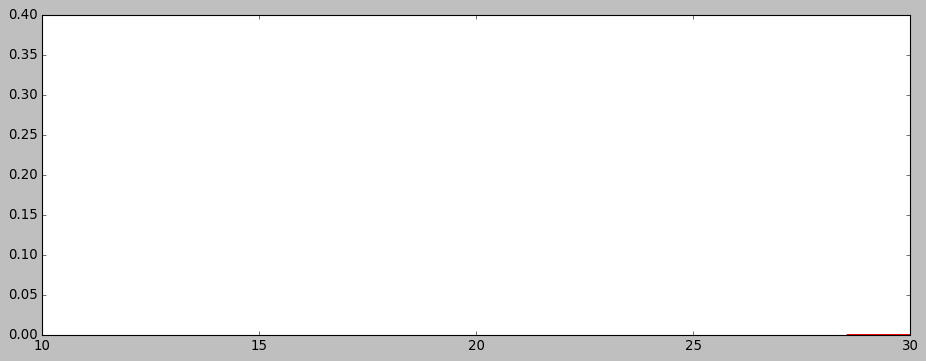

Number Correct:  113
Possible Number of Matches:  117

Event 236: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  80.1418439716312 %


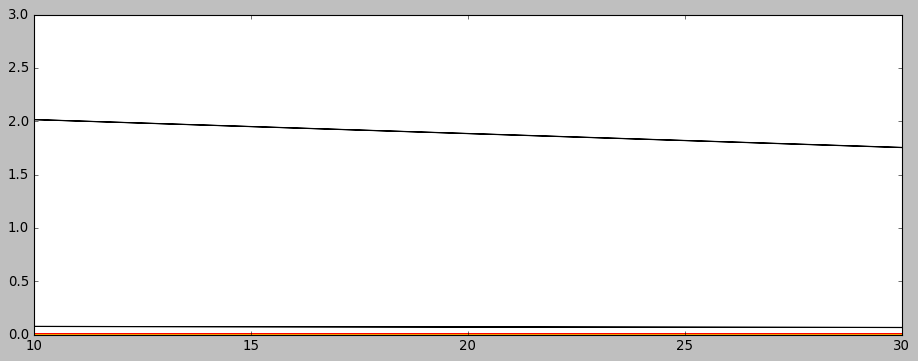

Number Correct:  195
Possible Number of Matches:  233

Event 237: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  90.76086956521739 %


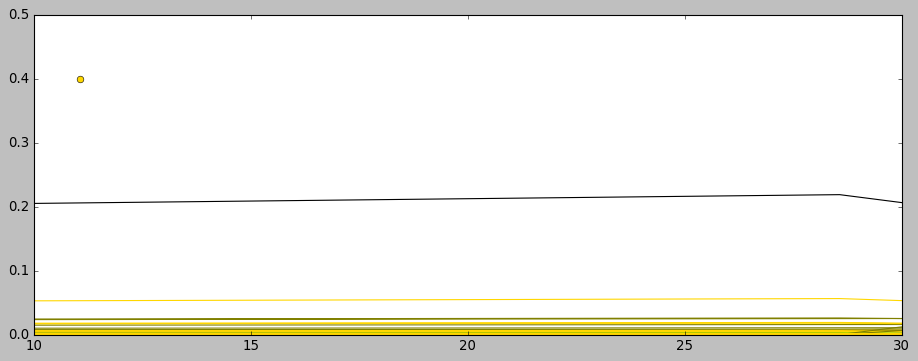

Number Correct:  313
Possible Number of Matches:  335

Event 238: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  80.3030303030303 %


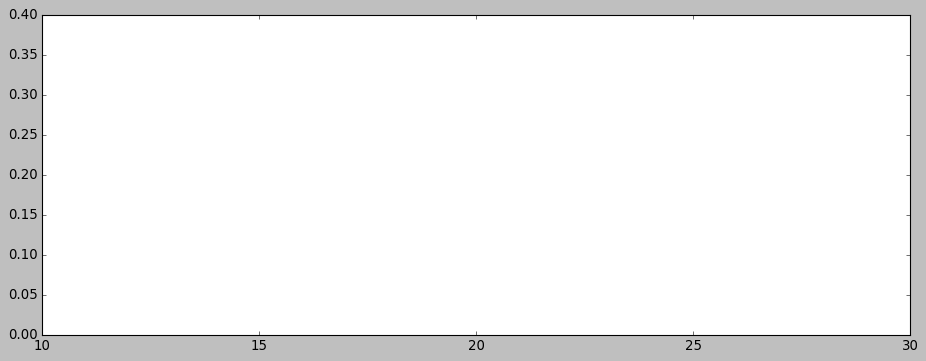

Number Correct:  144
Possible Number of Matches:  151

Event 239: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  95.45454545454545 %


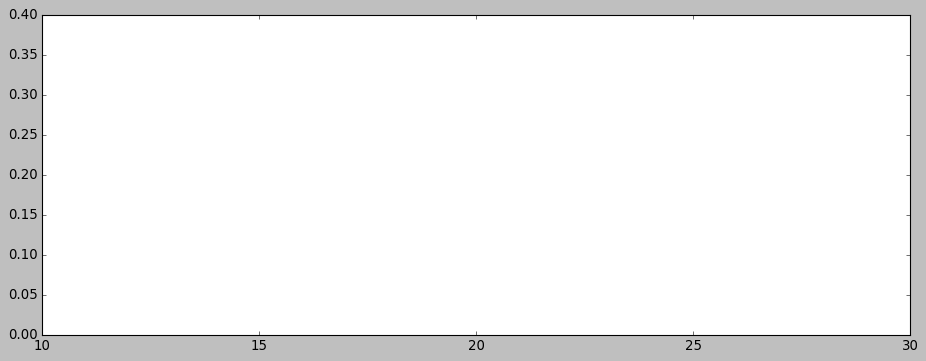

Number Correct:  63
Possible Number of Matches:  82

Event 240: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  90.99526066350711 %


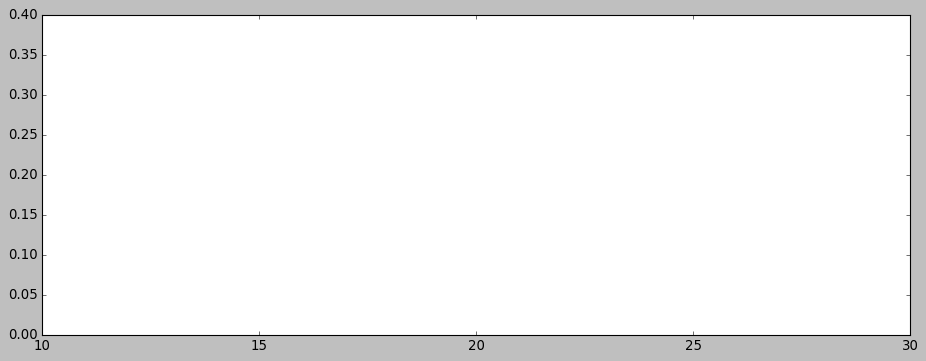

Number Correct:  174
Possible Number of Matches:  183

Event 241: Found 2 of 3, added 2 (eff 66.67%)
Percentage Matched =  92.60700389105058 %


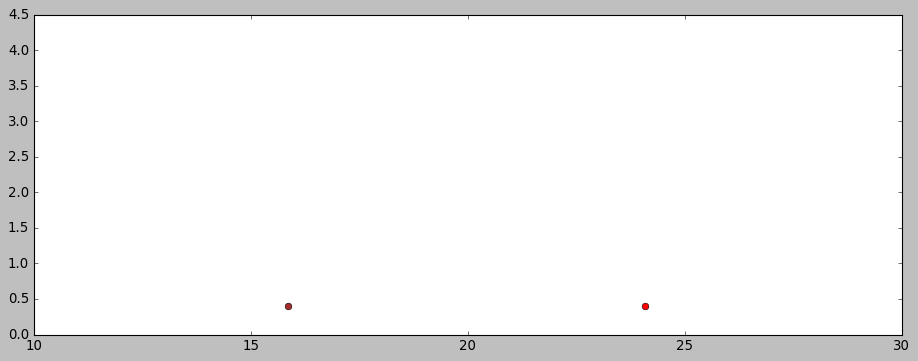

Number Correct:  224
Possible Number of Matches:  231

Event 242: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  86.34538152610442 %


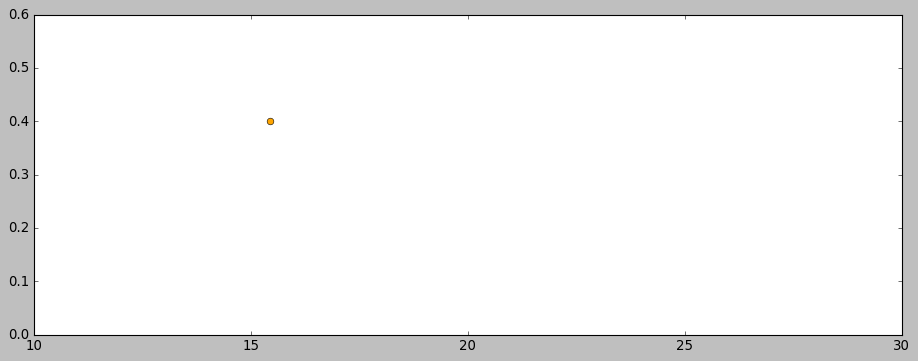

Number Correct:  133
Possible Number of Matches:  146

Event 243: Found 5 of 6, added 2 (eff 83.33%)
Percentage Matched =  92.02453987730061 %


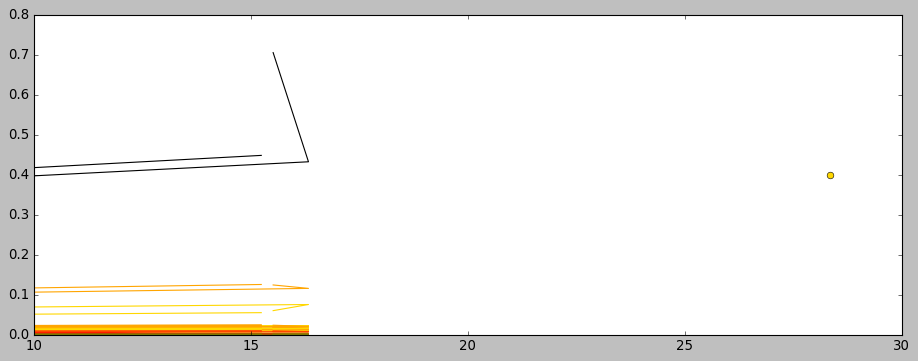

Number Correct:  275
Possible Number of Matches:  293

Event 244: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  67.85714285714286 %


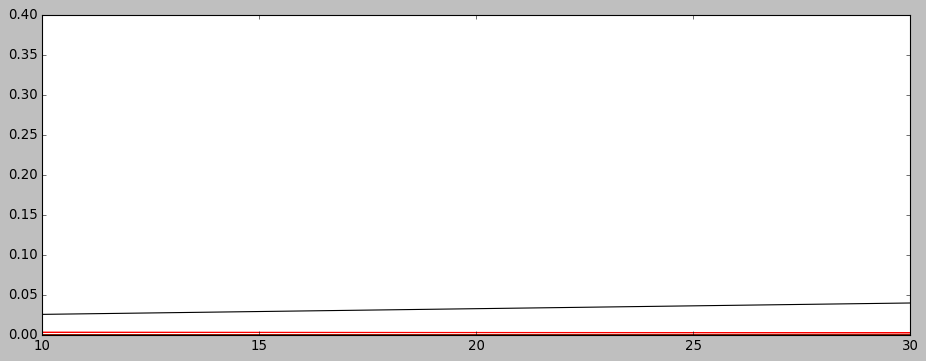

Number Correct:  111
Possible Number of Matches:  114

Event 245: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  68.29268292682927 %


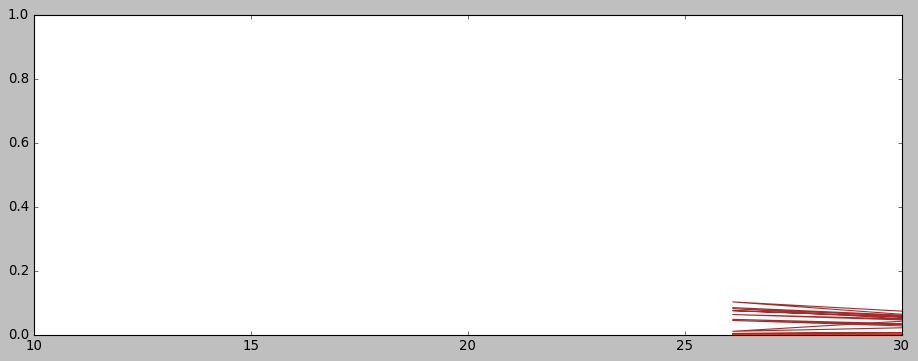

Number Correct:  106
Possible Number of Matches:  114

Event 246: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  85.38461538461539 %


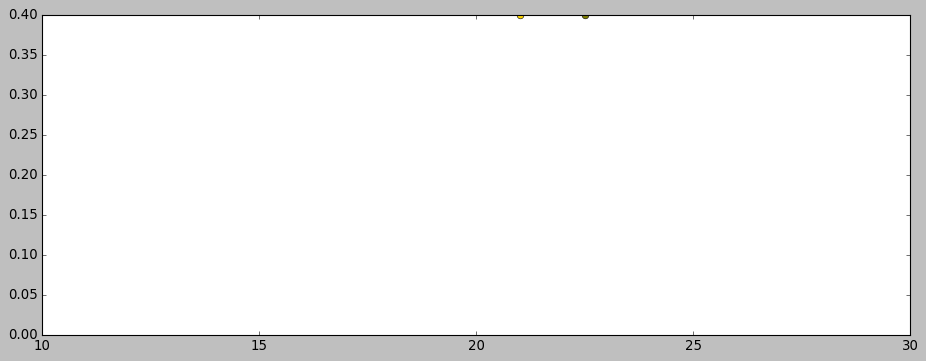

Number Correct:  179
Possible Number of Matches:  203

Event 247: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  87.41721854304636 %


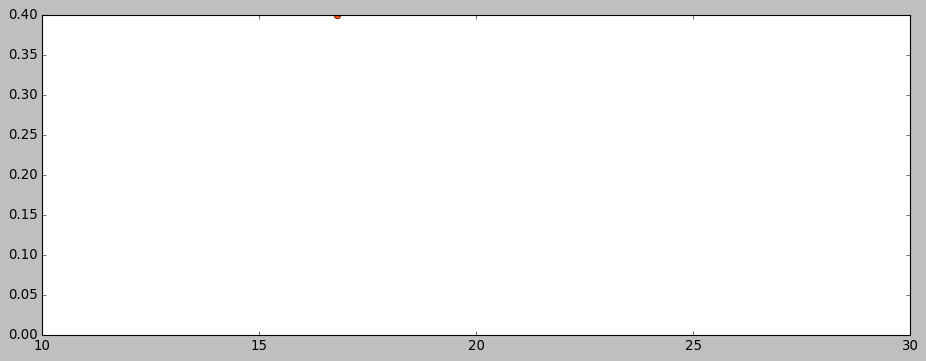

Number Correct:  127
Possible Number of Matches:  175

Event 248: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  59.84848484848485 %


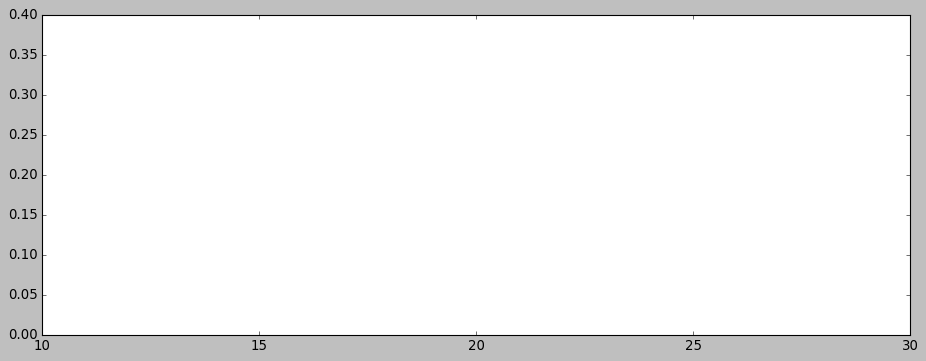

Number Correct:  67
Possible Number of Matches:  75

Event 249: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  92.95154185022027 %


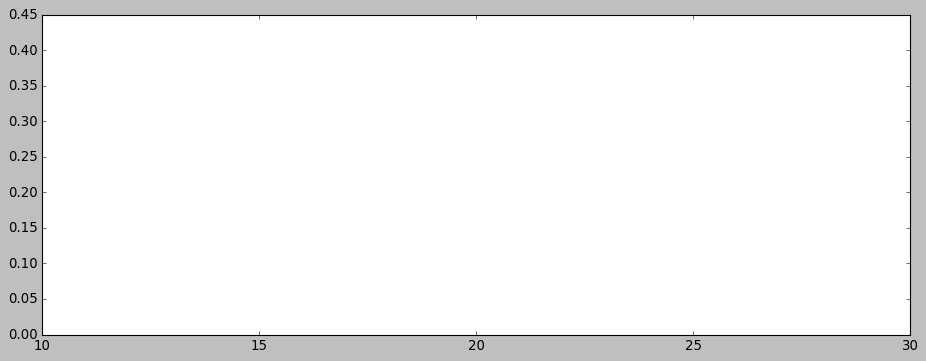

Number Correct:  194
Possible Number of Matches:  205

Event 250: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  86.42857142857143 %


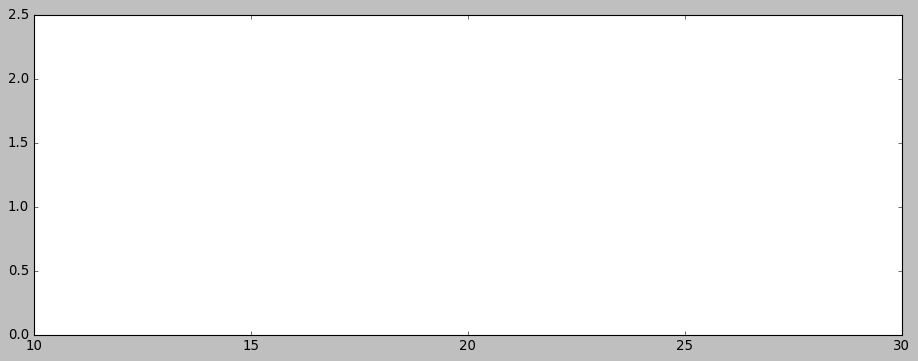

Number Correct:  232
Possible Number of Matches:  249

Event 251: Found 4 of 5, added 0 (eff 80.00%)
Percentage Matched =  83.46456692913385 %


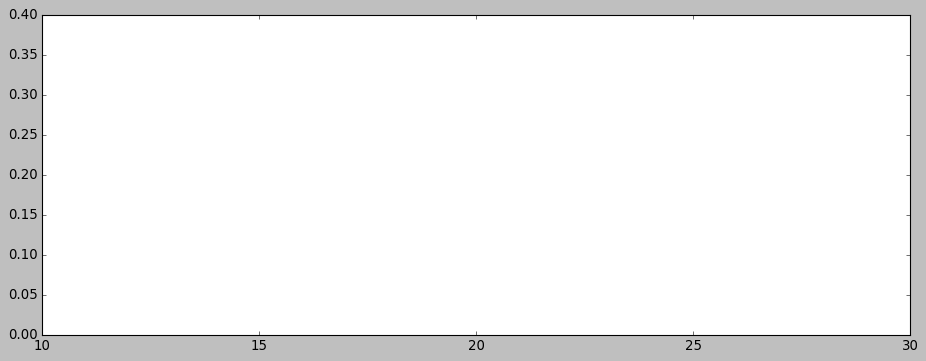

Number Correct:  97
Possible Number of Matches:  99

Event 252: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  83.79446640316206 %


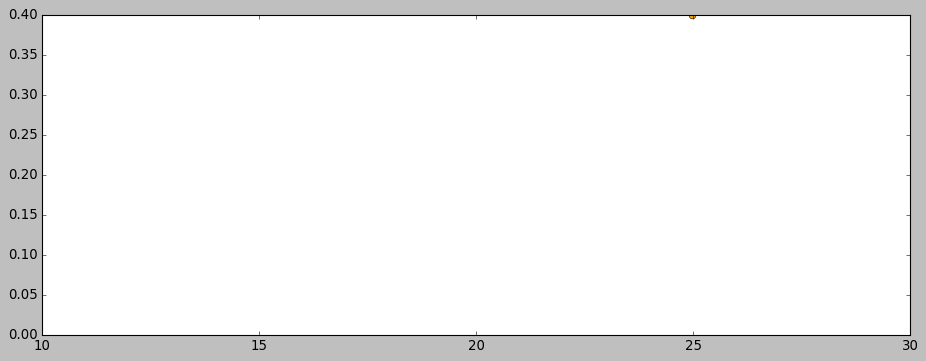

Number Correct:  204
Possible Number of Matches:  213

Event 253: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  90.38461538461539 %


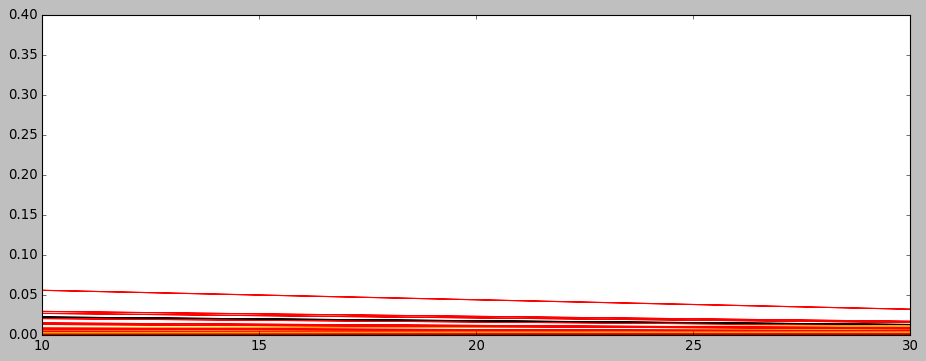

Number Correct:  129
Possible Number of Matches:  133

Event 254: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  86.23853211009174 %


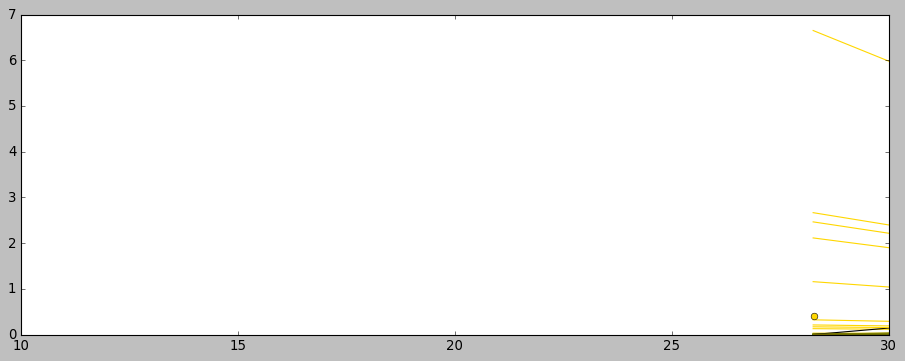

Number Correct:  343
Possible Number of Matches:  383

Event 255: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  77.66497461928934 %


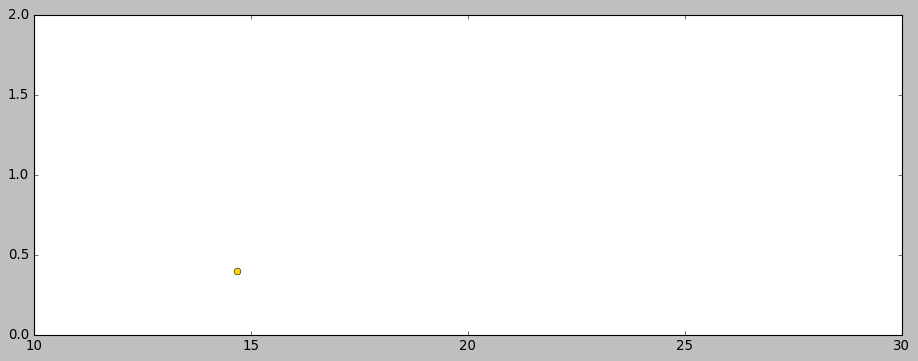

Number Correct:  145
Possible Number of Matches:  183

Event 256: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  86.92307692307692 %


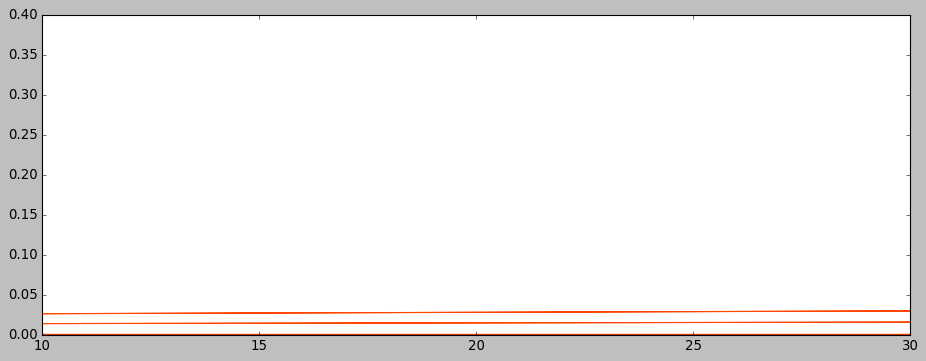

Number Correct:  88
Possible Number of Matches:  113

Event 257: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  55.12820512820513 %


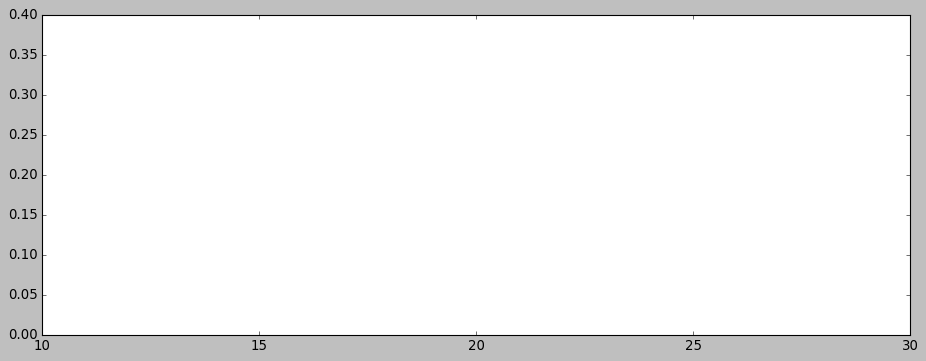

Number Correct:  83
Possible Number of Matches:  83

Event 258: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  89.87854251012146 %


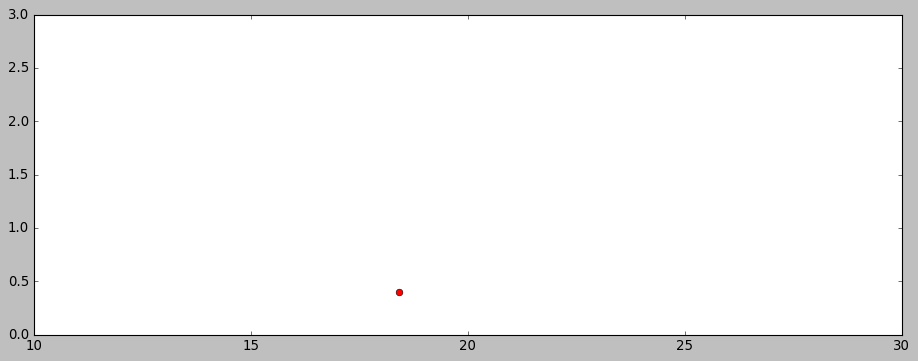

Number Correct:  206
Possible Number of Matches:  225

Event 259: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  83.56164383561644 %


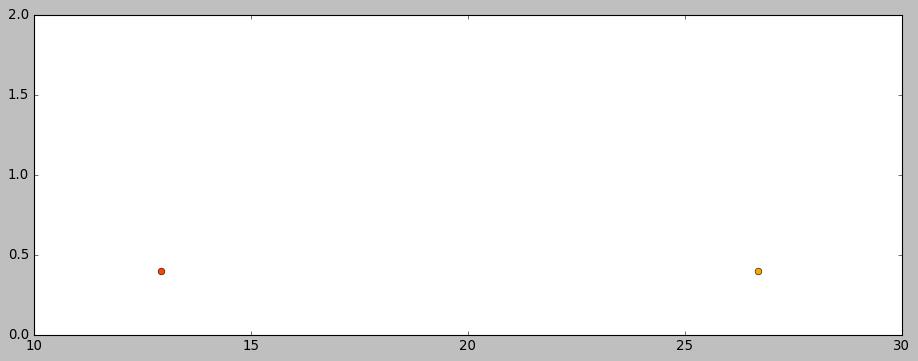

Number Correct:  174
Possible Number of Matches:  187

Event 260: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  80.84415584415585 %


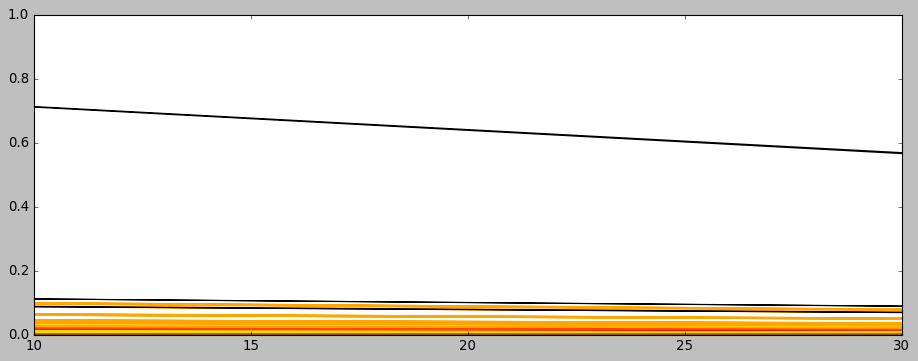

Number Correct:  185
Possible Number of Matches:  203

Event 261: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  56.578947368421055 %


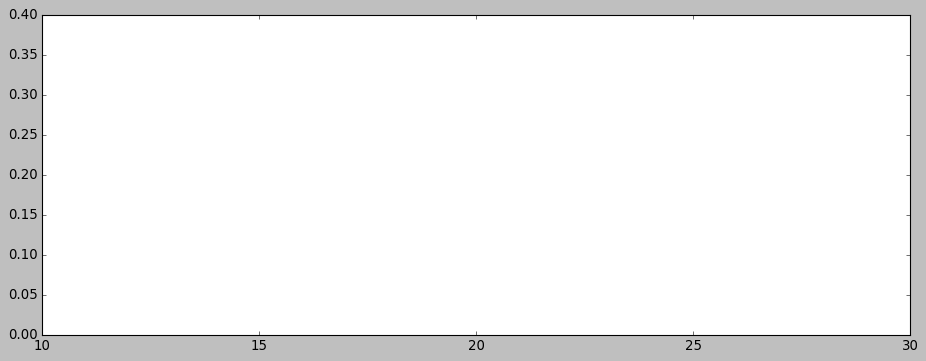

Number Correct:  119
Possible Number of Matches:  128

Event 262: Found 3 of 4, added 0 (eff 75.00%)
Percentage Matched =  89.51612903225806 %


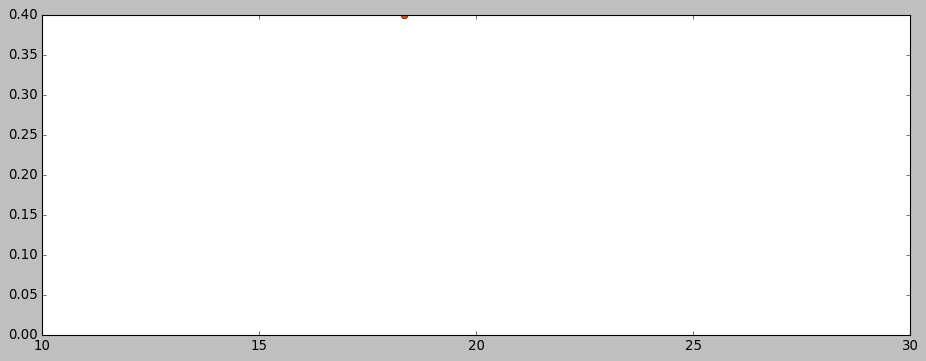

Number Correct:  93
Possible Number of Matches:  99

Event 263: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  87.87878787878788 %


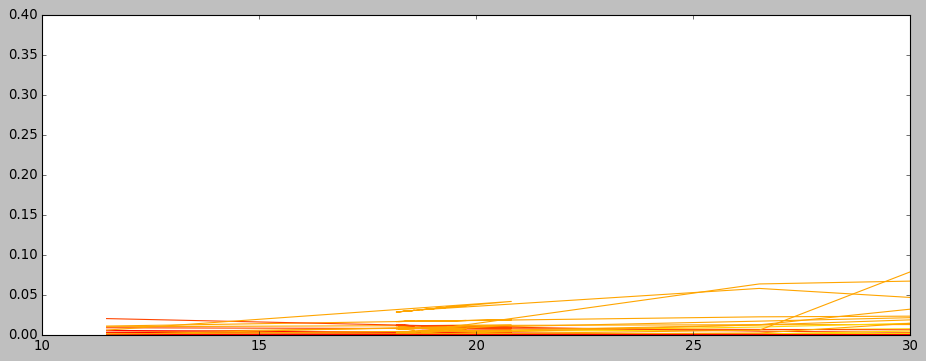

Number Correct:  190
Possible Number of Matches:  201

Event 264: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  94.77611940298507 %


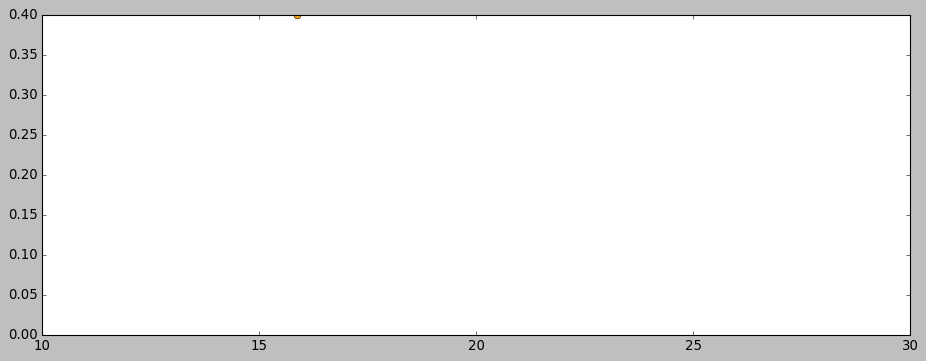

Number Correct:  120
Possible Number of Matches:  124

Event 265: Found 4 of 6, added 2 (eff 66.67%)
Percentage Matched =  82.4390243902439 %


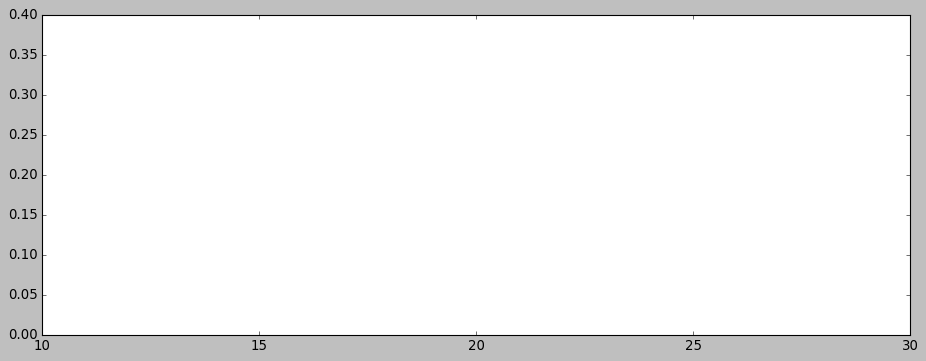

Number Correct:  145
Possible Number of Matches:  226

Event 266: Found 6 of 7, added 0 (eff 85.71%)
Percentage Matched =  89.24731182795699 %


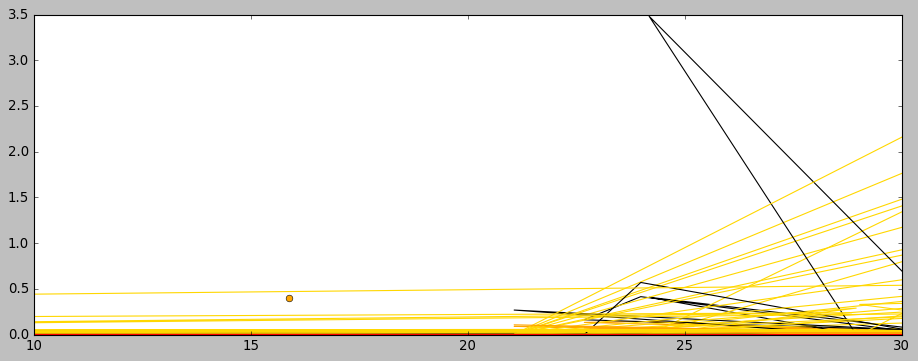

Number Correct:  223
Possible Number of Matches:  241

Event 267: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  90.9090909090909 %


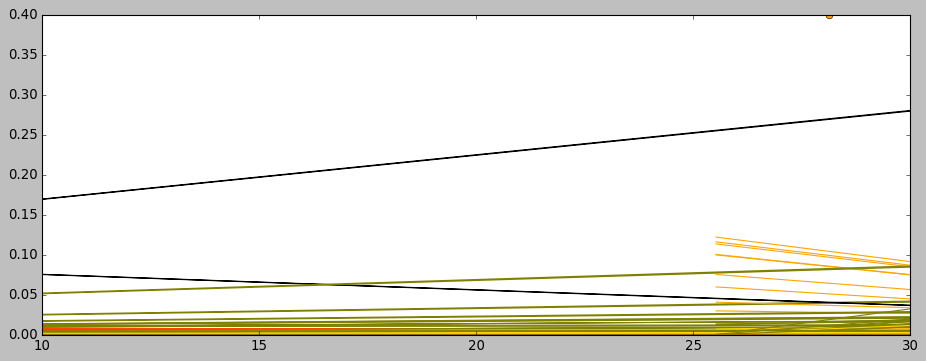

Number Correct:  174
Possible Number of Matches:  240

Event 268: Found 10 of 10, added 1 (eff 100.00%)
Percentage Matched =  93.06666666666666 %


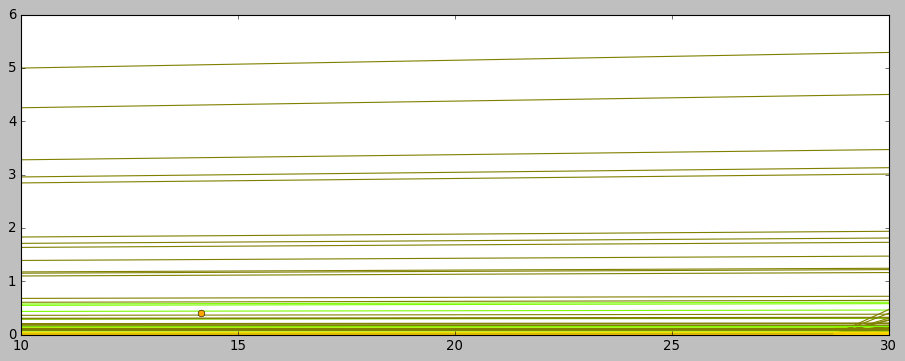

Number Correct:  320
Possible Number of Matches:  447

Event 269: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  89.1304347826087 %


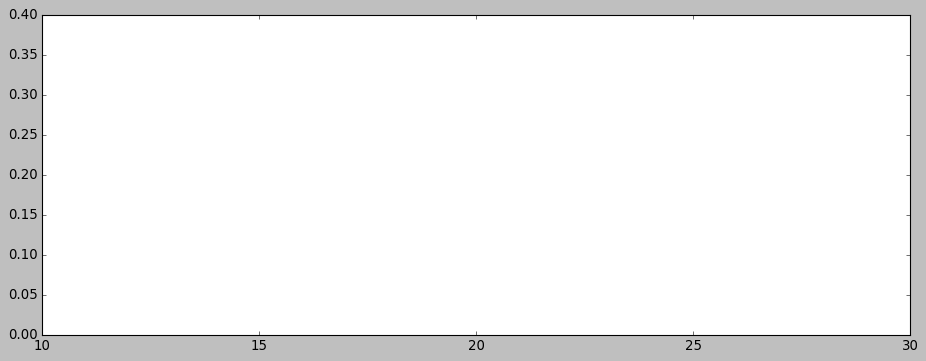

Number Correct:  82
Possible Number of Matches:  84

Event 270: Found 3 of 4, added 2 (eff 75.00%)
Percentage Matched =  85.77981651376147 %


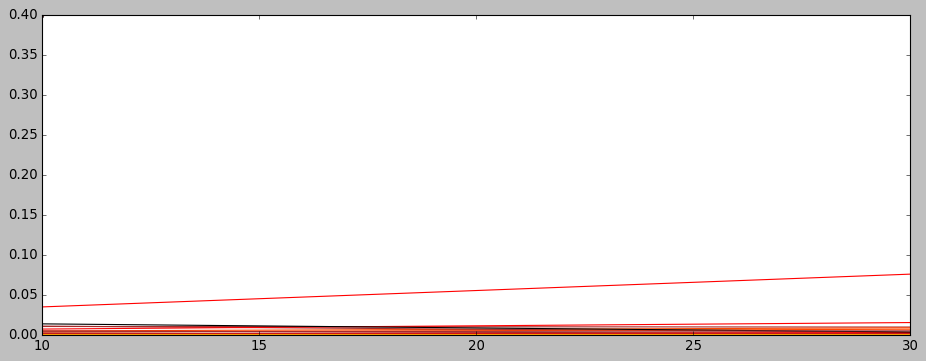

Number Correct:  166
Possible Number of Matches:  255

Event 271: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  86.6120218579235 %


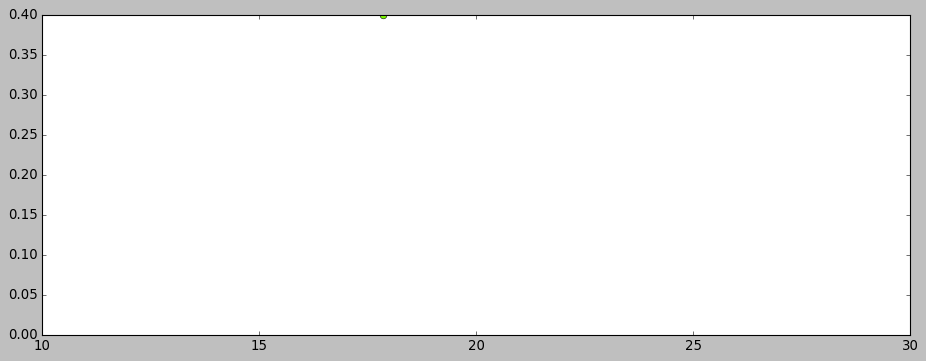

Number Correct:  294
Possible Number of Matches:  324

Event 272: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.29268292682927 %


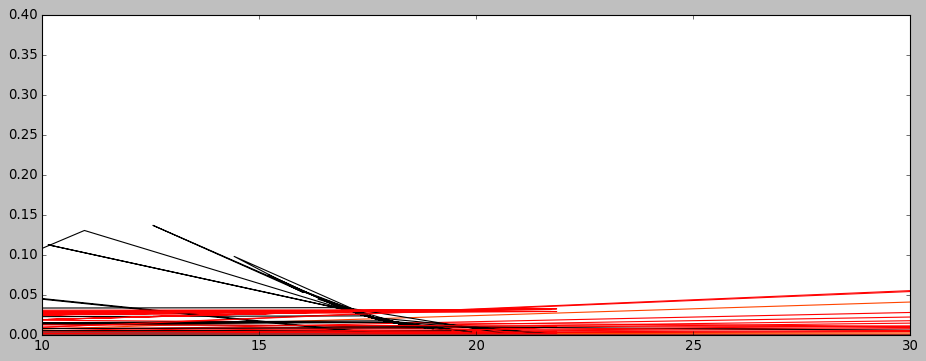

Number Correct:  173
Possible Number of Matches:  179

Event 273: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  81.19658119658119 %


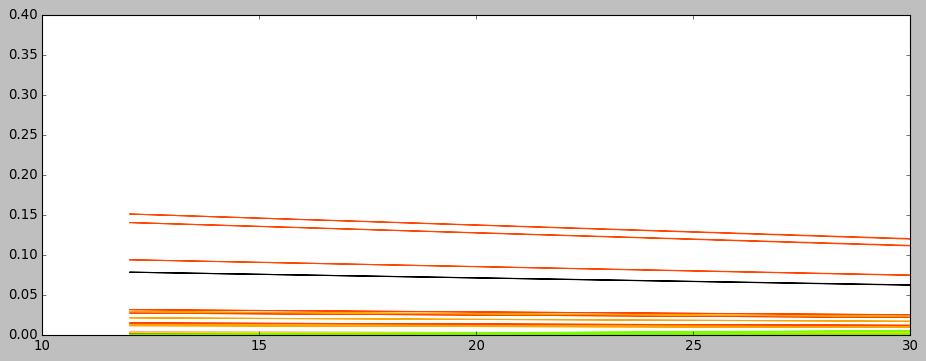

Number Correct:  258
Possible Number of Matches:  286

Event 274: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.50574712643679 %


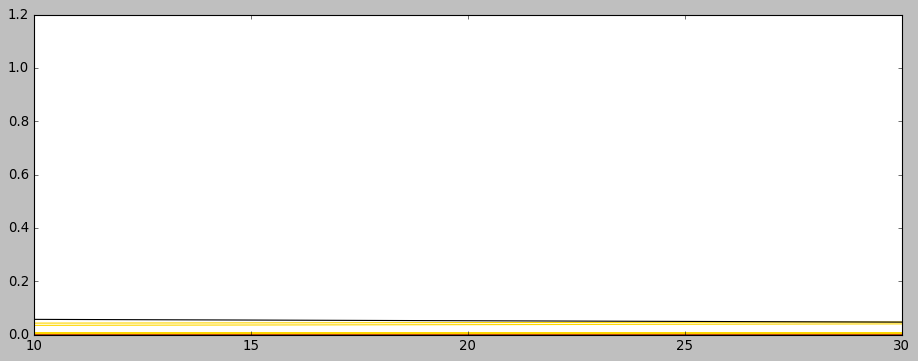

Number Correct:  144
Possible Number of Matches:  152

Event 275: Found 3 of 3, added 2 (eff 100.00%)
Percentage Matched =  86.27450980392157 %


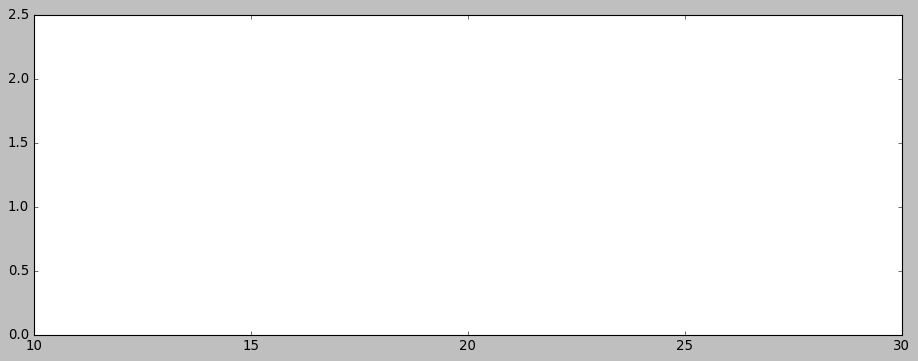

Number Correct:  78
Possible Number of Matches:  170

Event 276: Found 10 of 10, added 1 (eff 100.00%)
Percentage Matched =  92.28295819935691 %


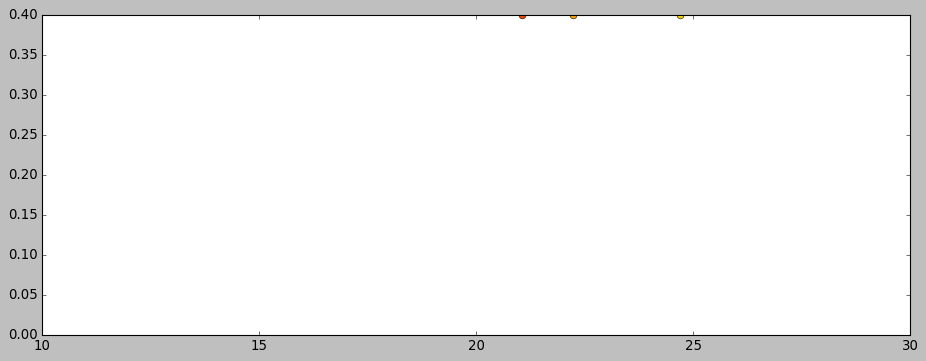

Number Correct:  221
Possible Number of Matches:  347

Event 277: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  80.23715415019763 %


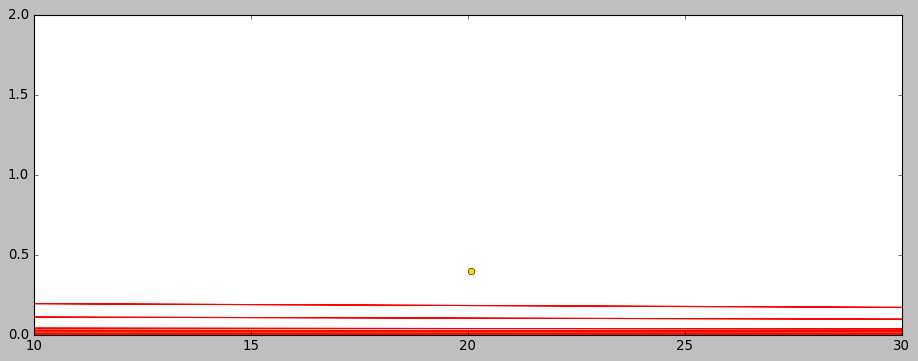

Number Correct:  179
Possible Number of Matches:  200

Event 278: Found 1 of 1, added 0 (eff 100.00%)
Percentage Matched =  78.43137254901961 %


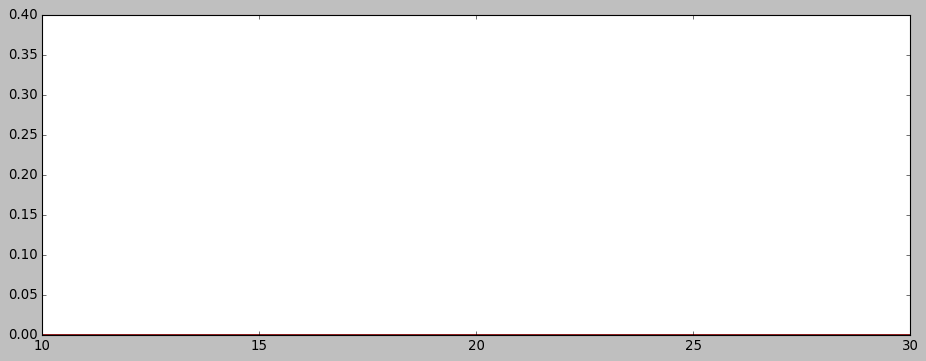

Number Correct:  40
Possible Number of Matches:  43

Event 279: Found 2 of 3, added 0 (eff 66.67%)
Percentage Matched =  80.20833333333333 %


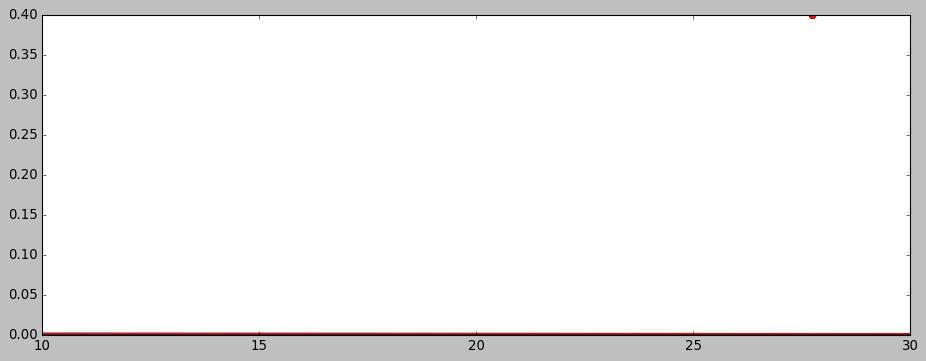

Number Correct:  75
Possible Number of Matches:  79

Event 280: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  89.14473684210526 %


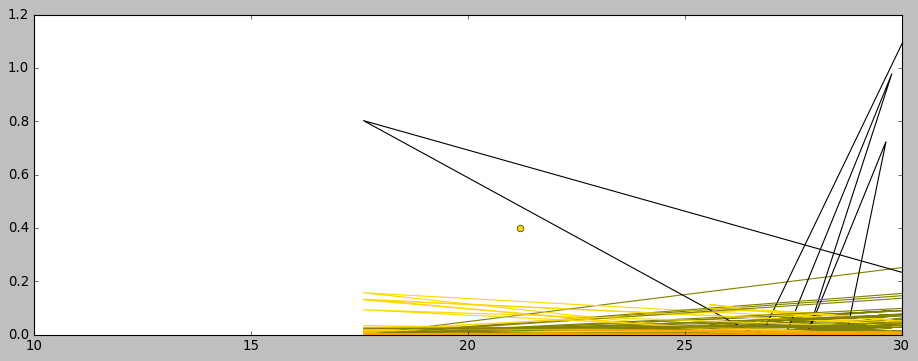

Number Correct:  228
Possible Number of Matches:  250

Event 281: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  84.42622950819673 %


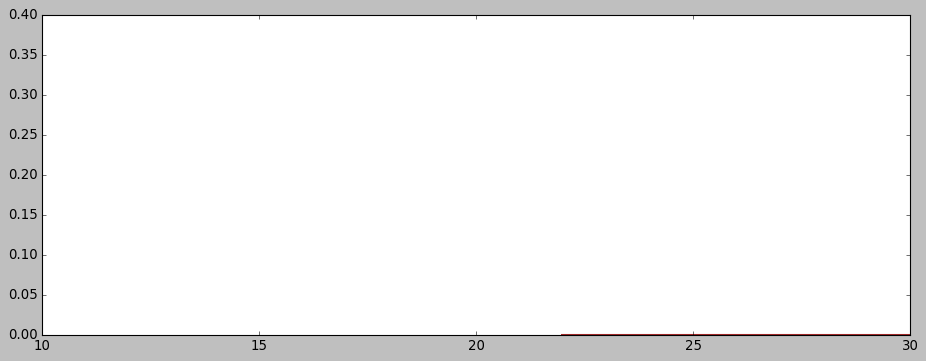

Number Correct:  87
Possible Number of Matches:  106

Event 282: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  36.8421052631579 %


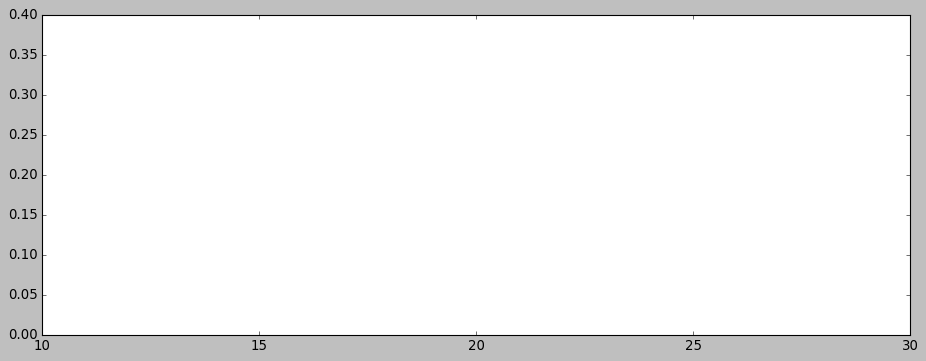

Number Correct:  47
Possible Number of Matches:  47

Event 283: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  85.51724137931035 %


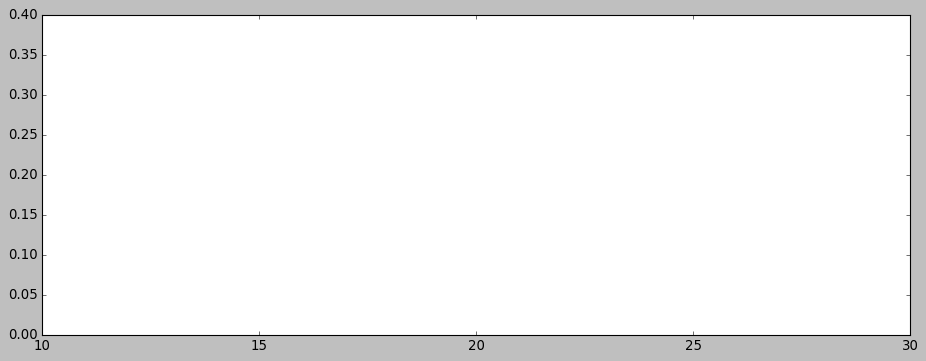

Number Correct:  226
Possible Number of Matches:  242

Event 284: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  88.38526912181302 %


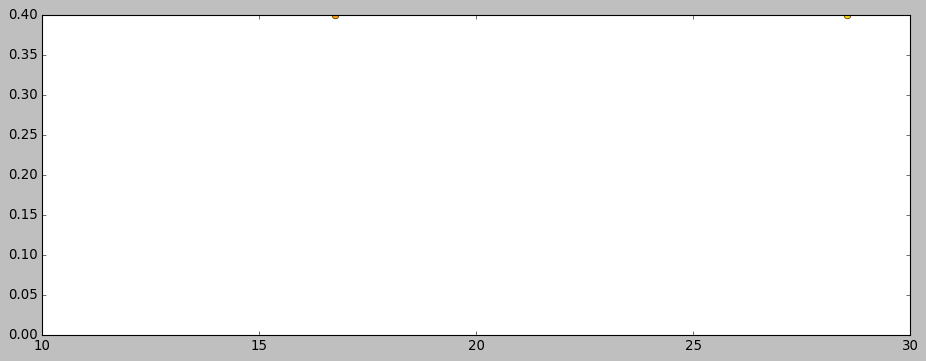

Number Correct:  300
Possible Number of Matches:  323

Event 285: Found 3 of 4, added 0 (eff 75.00%)
Percentage Matched =  90.06622516556291 %


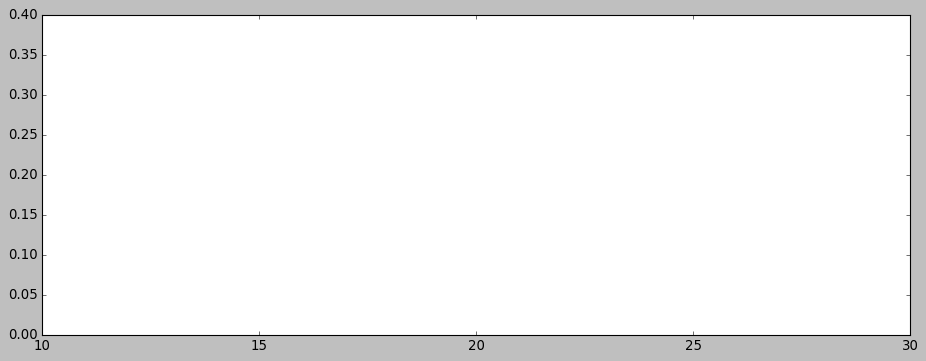

Number Correct:  130
Possible Number of Matches:  133

Event 286: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  89.94413407821229 %


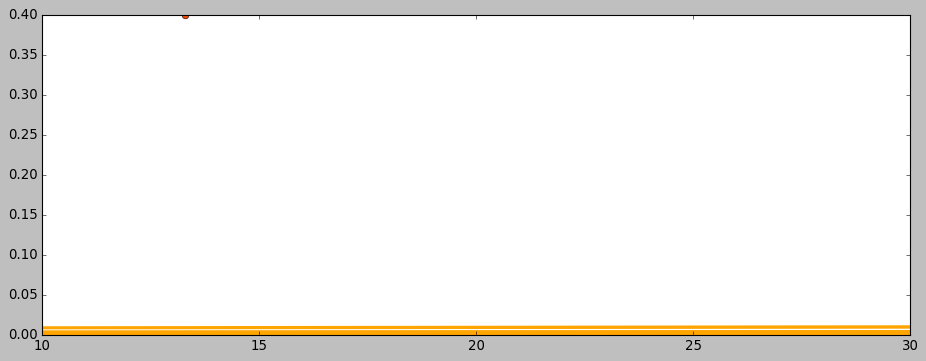

Number Correct:  155
Possible Number of Matches:  158

Event 287: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  81.20805369127517 %


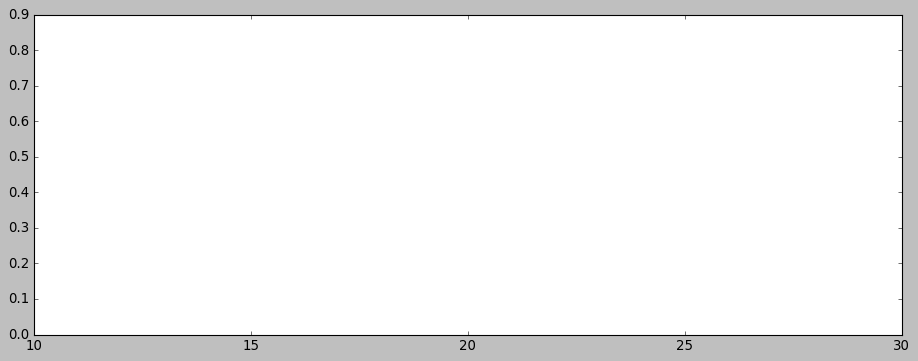

Number Correct:  222
Possible Number of Matches:  241

Event 288: Found 3 of 4, added 1 (eff 75.00%)
Percentage Matched =  70.7182320441989 %


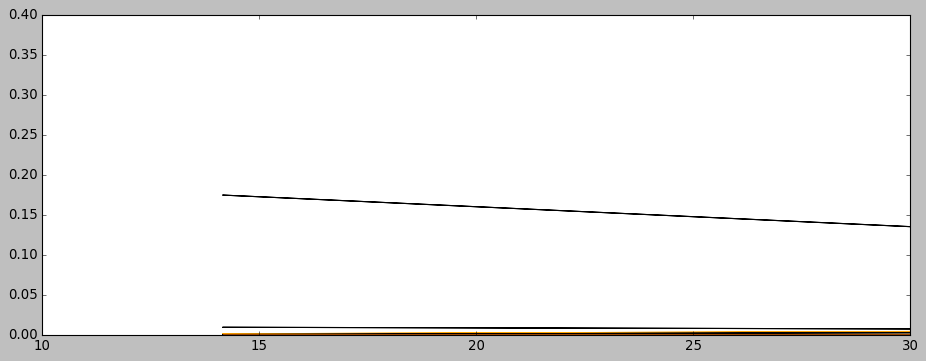

Number Correct:  118
Possible Number of Matches:  199

Event 289: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  87.65432098765432 %


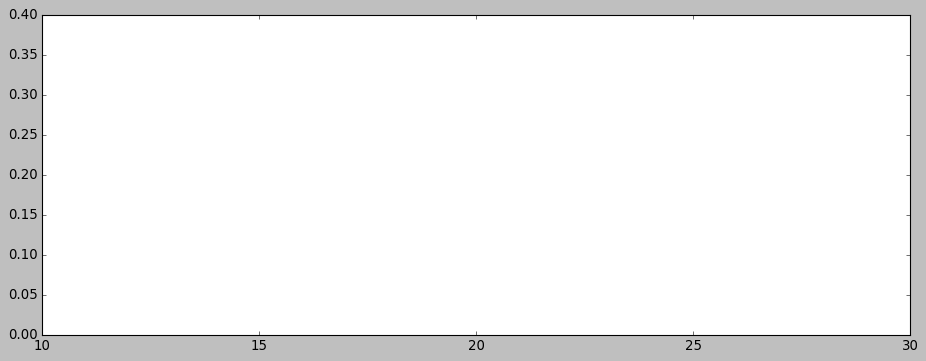

Number Correct:  127
Possible Number of Matches:  135

Event 290: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  92.27642276422765 %


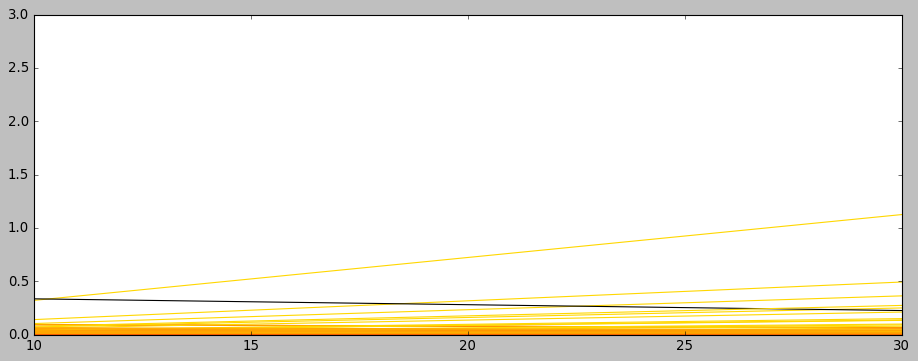

Number Correct:  214
Possible Number of Matches:  227

Event 291: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  88.59934853420195 %


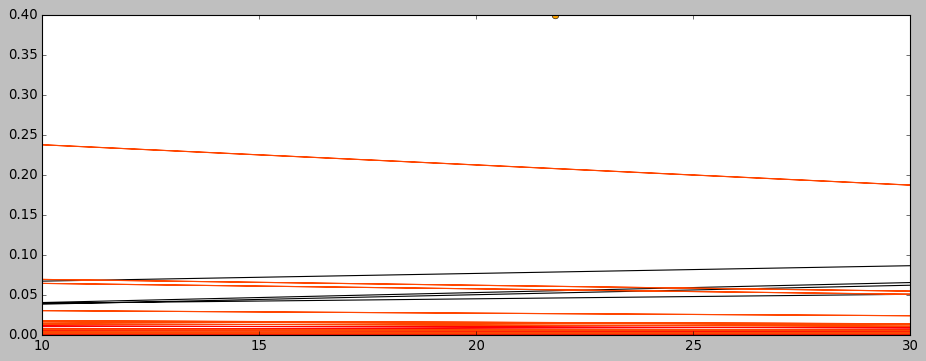

Number Correct:  241
Possible Number of Matches:  272

Event 292: Found 4 of 4, added 1 (eff 100.00%)
Percentage Matched =  80.23715415019763 %


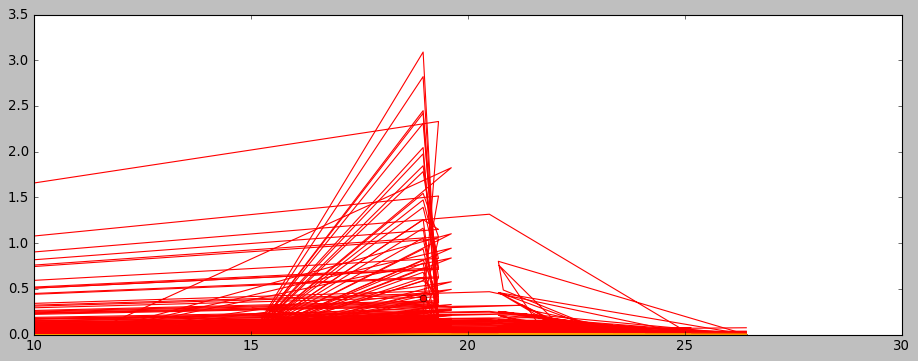

Number Correct:  187
Possible Number of Matches:  227

Event 293: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  89.50276243093923 %


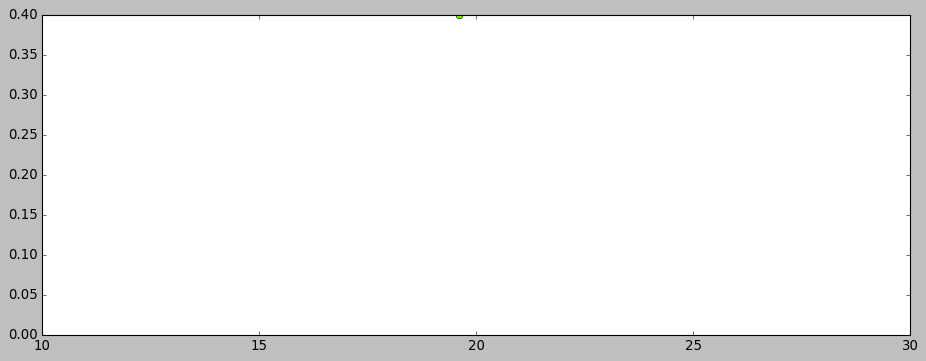

Number Correct:  135
Possible Number of Matches:  150

Event 294: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  63.23529411764706 %


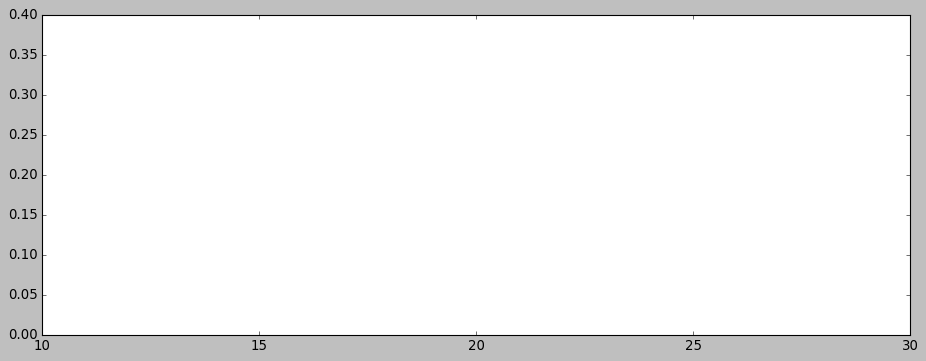

Number Correct:  151
Possible Number of Matches:  165

Event 295: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  92.13483146067416 %


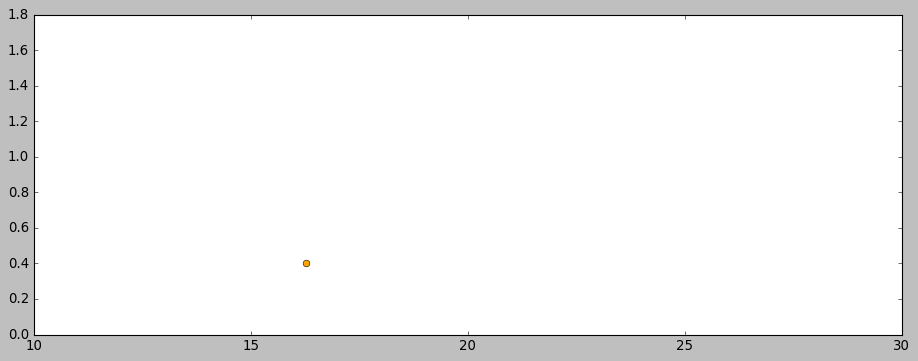

Number Correct:  157
Possible Number of Matches:  178

Event 296: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  74.83296213808464 %


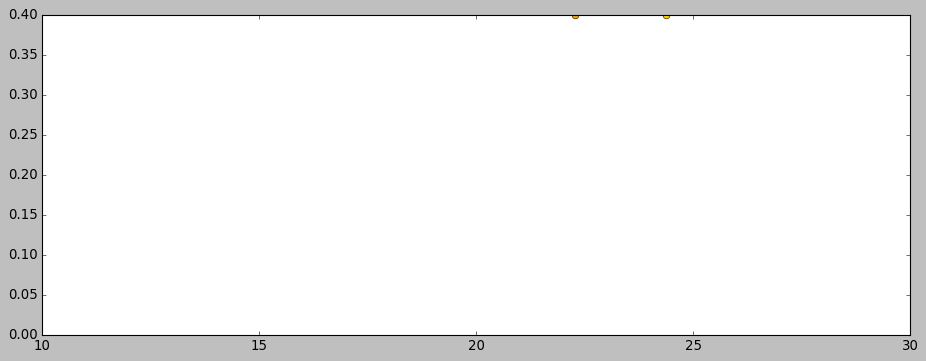

Number Correct:  276
Possible Number of Matches:  341

Event 297: Found 10 of 10, added 0 (eff 100.00%)
Percentage Matched =  87.03703703703704 %


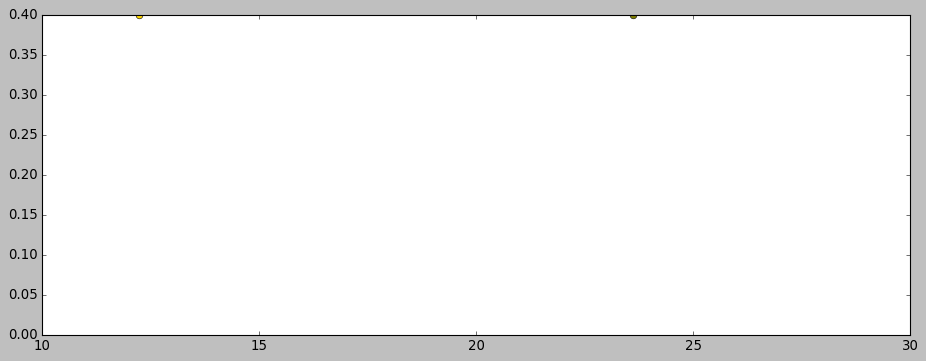

Number Correct:  247
Possible Number of Matches:  284

Event 298: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  75.64766839378238 %


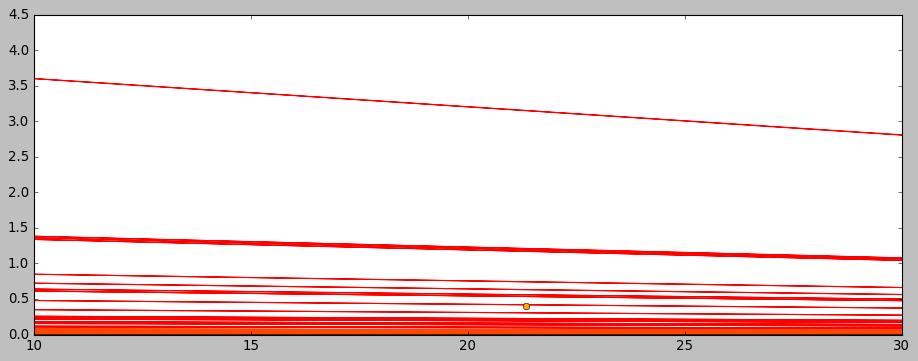

Number Correct:  131
Possible Number of Matches:  141

Event 299: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  88.31168831168831 %


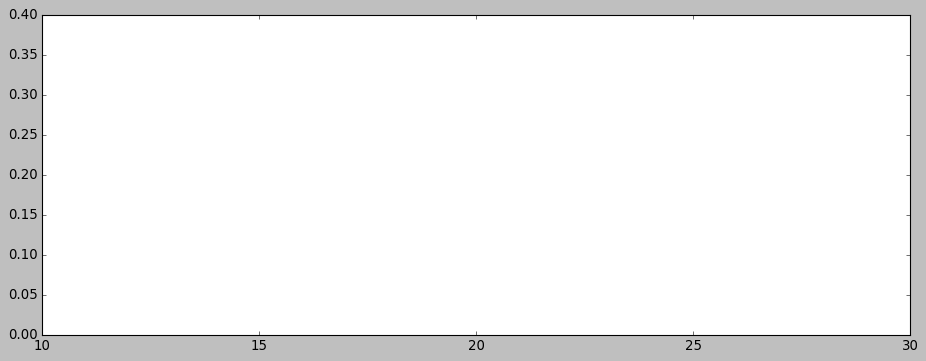

Number Correct:  129
Possible Number of Matches:  134

Event 300: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  88.4297520661157 %


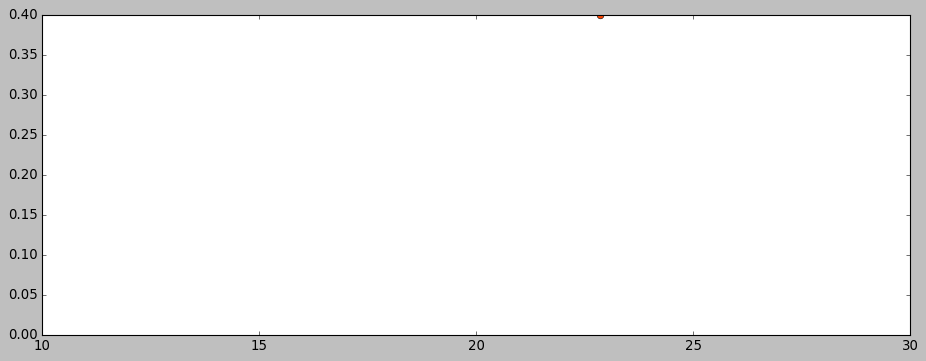

Number Correct:  184
Possible Number of Matches:  209

Event 301: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  88.70967741935483 %


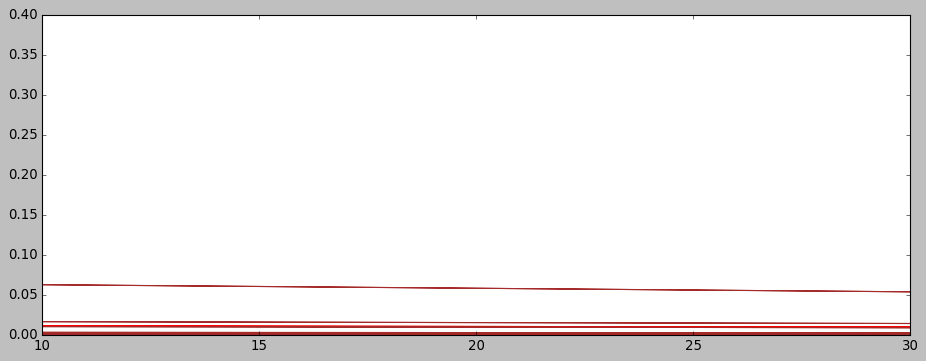

Number Correct:  103
Possible Number of Matches:  109

Event 302: Found 1 of 1, added 1 (eff 100.00%)
Percentage Matched =  76.87074829931973 %


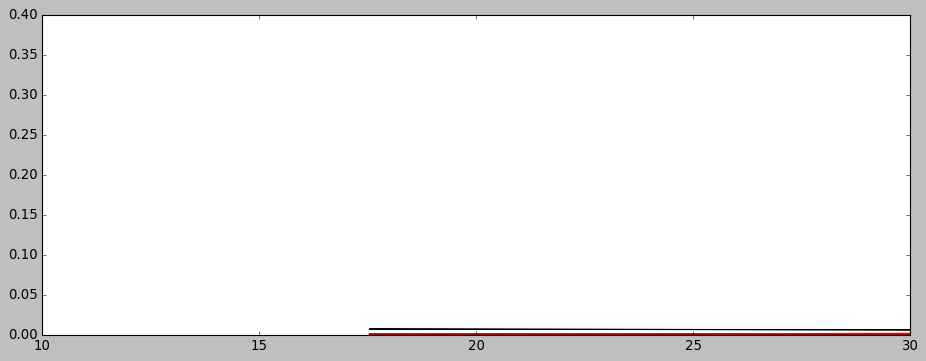

Number Correct:  109
Possible Number of Matches:  110

Event 303: Found 3 of 4, added 1 (eff 75.00%)
Percentage Matched =  87.6923076923077 %


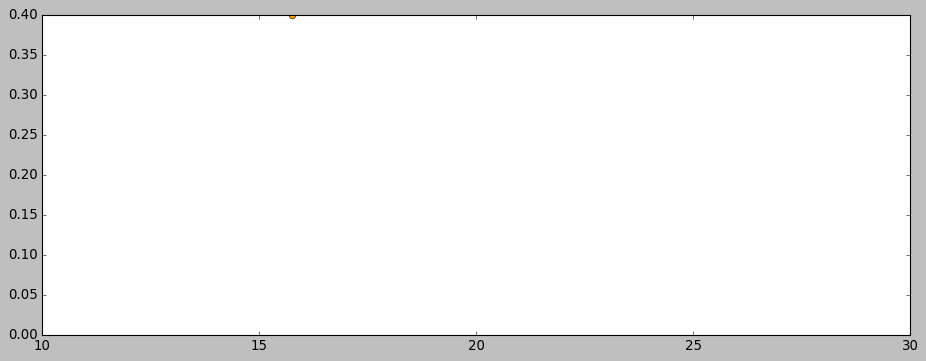

Number Correct:  97
Possible Number of Matches:  126

Event 304: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  91.7910447761194 %


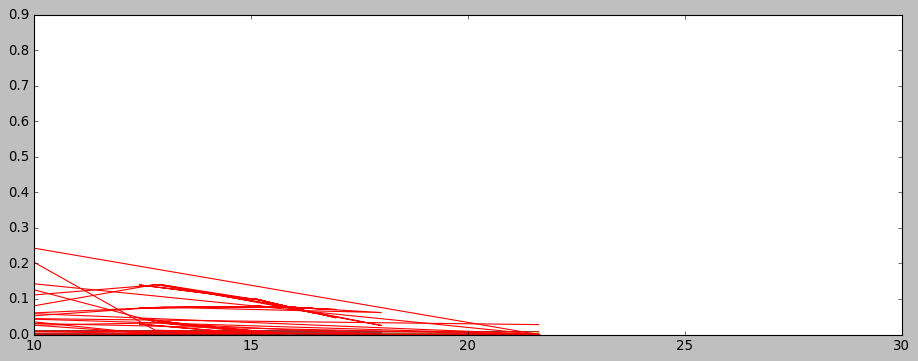

Number Correct:  112
Possible Number of Matches:  119

Event 305: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  89.63730569948187 %


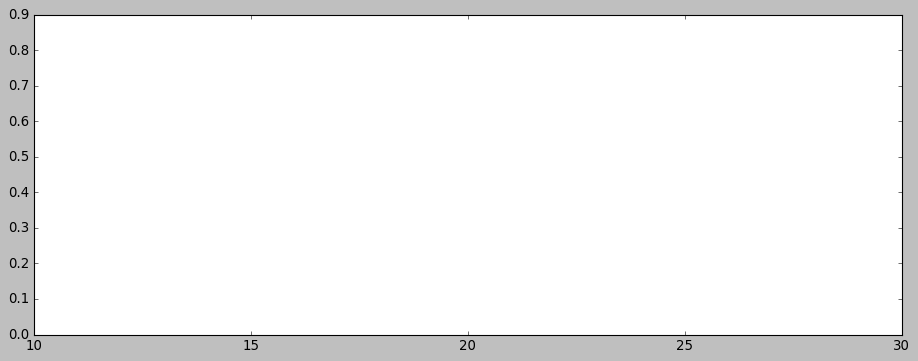

Number Correct:  293
Possible Number of Matches:  335

Event 306: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  87.93103448275862 %


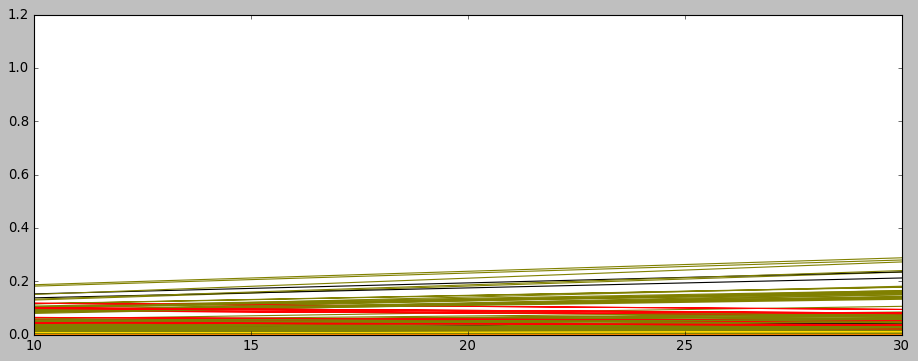

Number Correct:  338
Possible Number of Matches:  366

Event 307: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  87.5776397515528 %


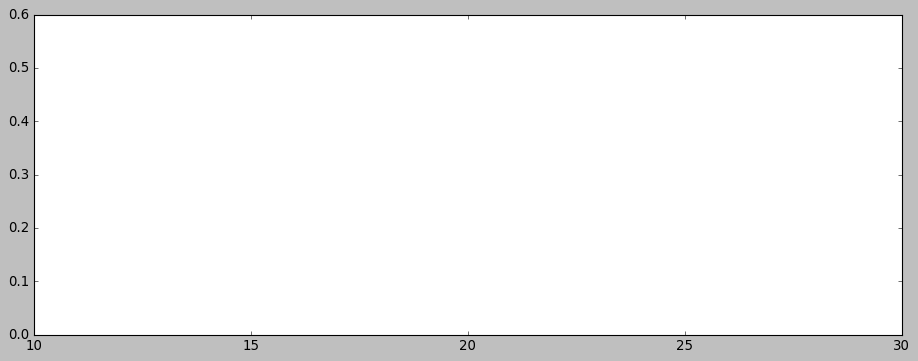

Number Correct:  252
Possible Number of Matches:  269

Event 308: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  91.0377358490566 %


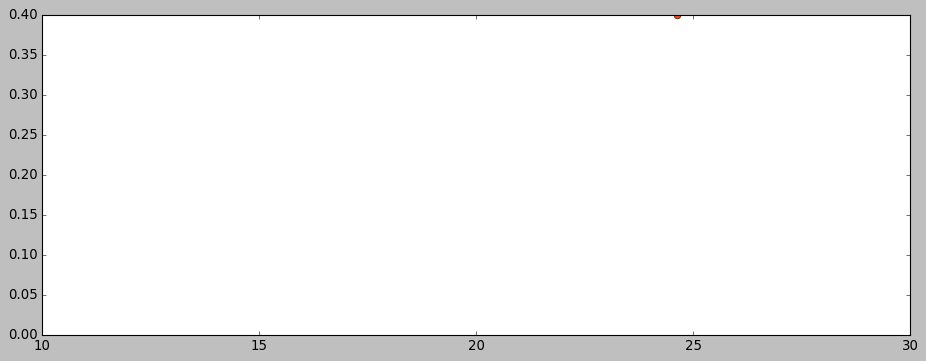

Number Correct:  105
Possible Number of Matches:  105

Event 309: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  80.46875 %


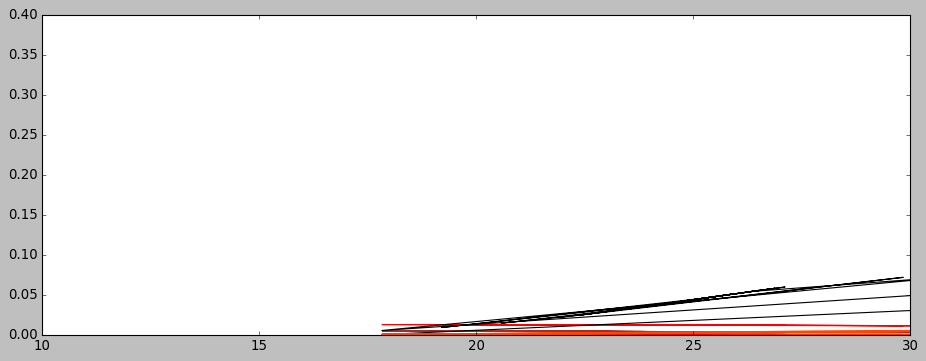

Number Correct:  91
Possible Number of Matches:  106

Event 310: Found 1 of 1, added 0 (eff 100.00%)
Percentage Matched =  60.256410256410255 %


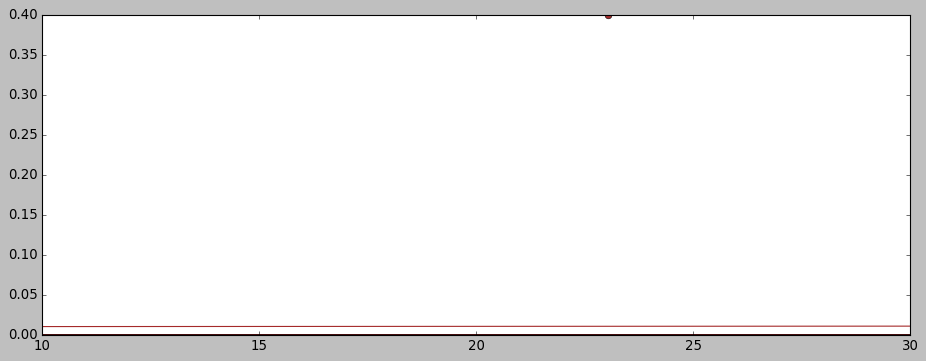

Number Correct:  45
Possible Number of Matches:  45

Event 311: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  71.67235494880546 %


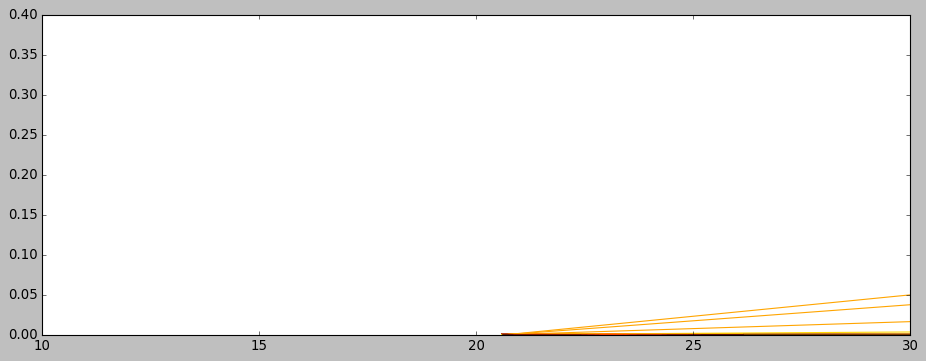

Number Correct:  170
Possible Number of Matches:  179

Event 312: Found 4 of 4, added 0 (eff 100.00%)
Percentage Matched =  91.76954732510288 %


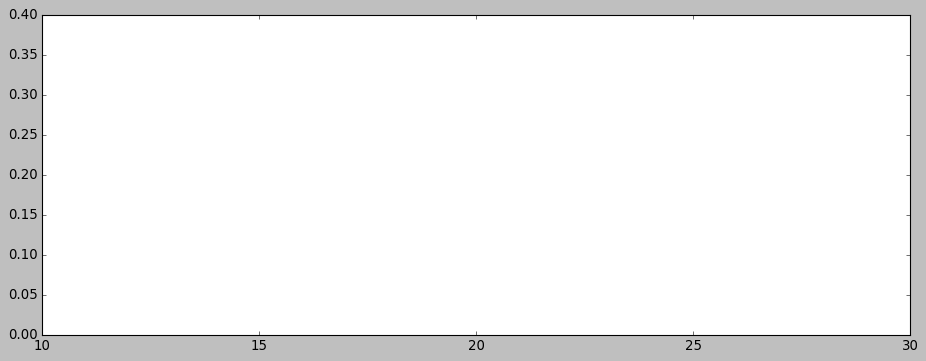

Number Correct:  211
Possible Number of Matches:  222

Event 313: Found 4 of 5, added 1 (eff 80.00%)
Percentage Matched =  71.74603174603175 %


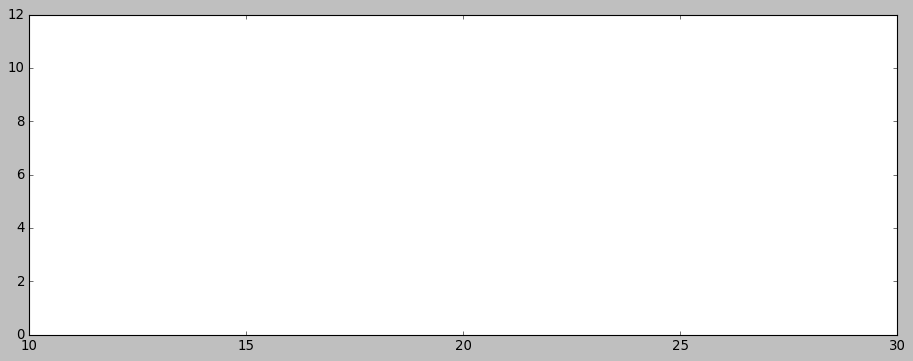

Number Correct:  208
Possible Number of Matches:  293

Event 314: Found 1 of 1, added 1 (eff 100.00%)
Percentage Matched =  64.24581005586592 %


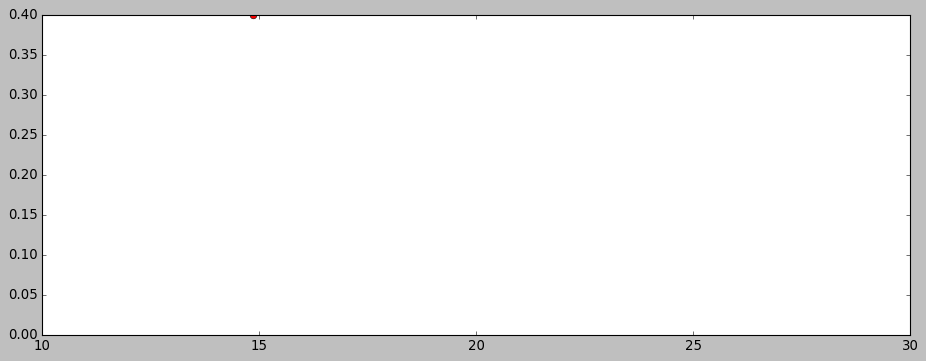

Number Correct:  113
Possible Number of Matches:  119

Event 315: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  97.46835443037975 %


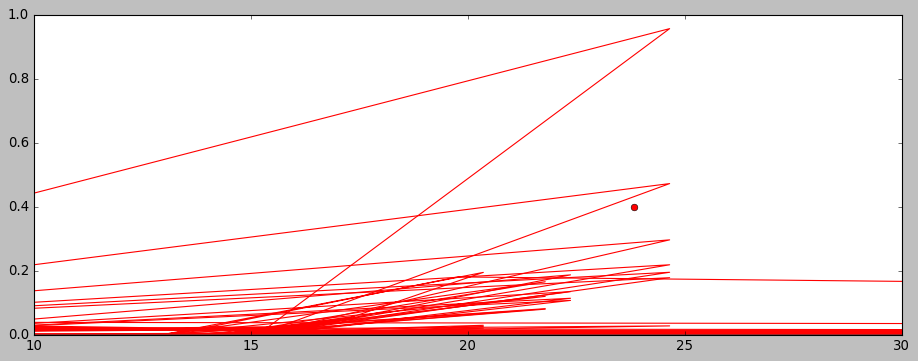

Number Correct:  72
Possible Number of Matches:  73

Event 316: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  83.68055555555556 %


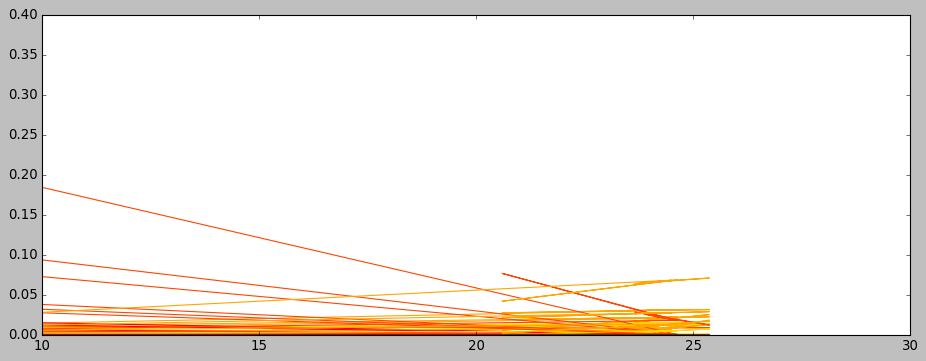

Number Correct:  214
Possible Number of Matches:  242

Event 317: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  50.74626865671642 %


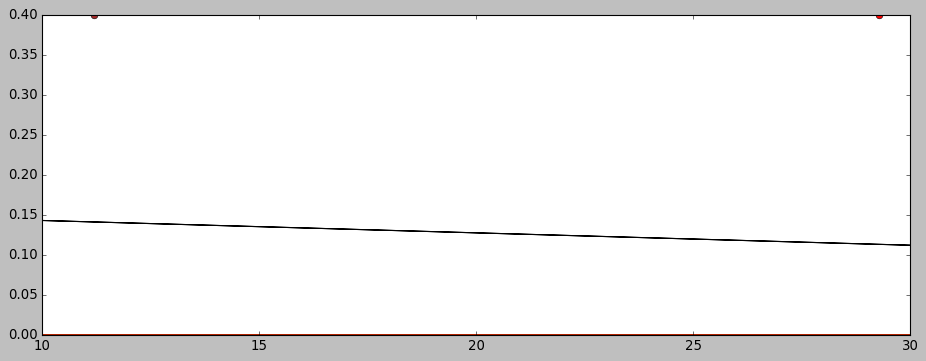

Number Correct:  32
Possible Number of Matches:  33

Event 318: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  89.32384341637011 %


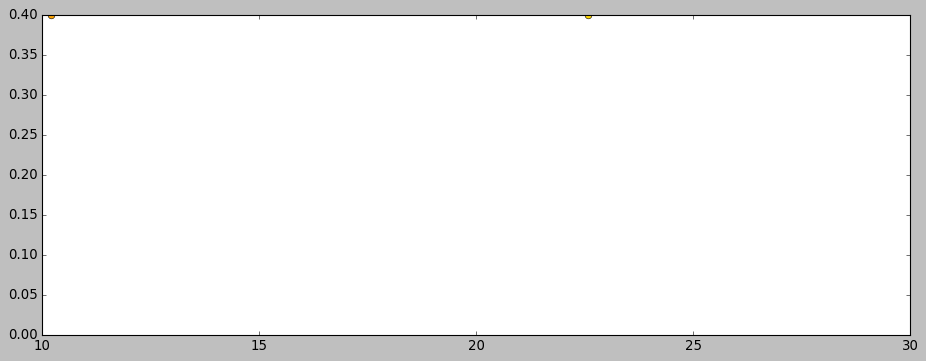

Number Correct:  230
Possible Number of Matches:  255

Event 319: Found 7 of 7, added 1 (eff 100.00%)
Percentage Matched =  91.0569105691057 %


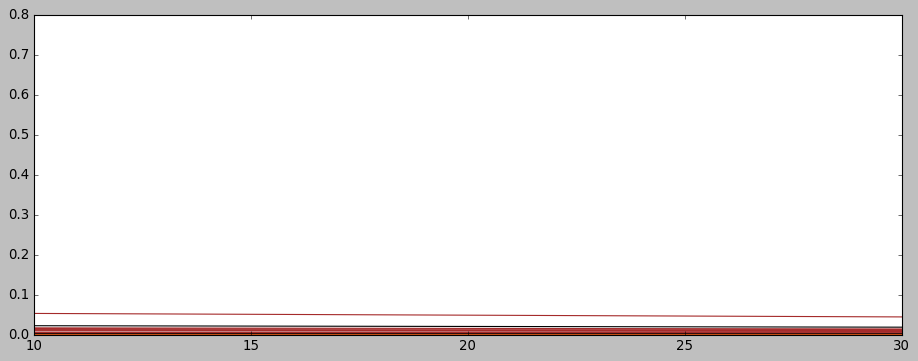

Number Correct:  284
Possible Number of Matches:  357

Event 320: Found 7 of 8, added 1 (eff 87.50%)
Percentage Matched =  89.71631205673759 %


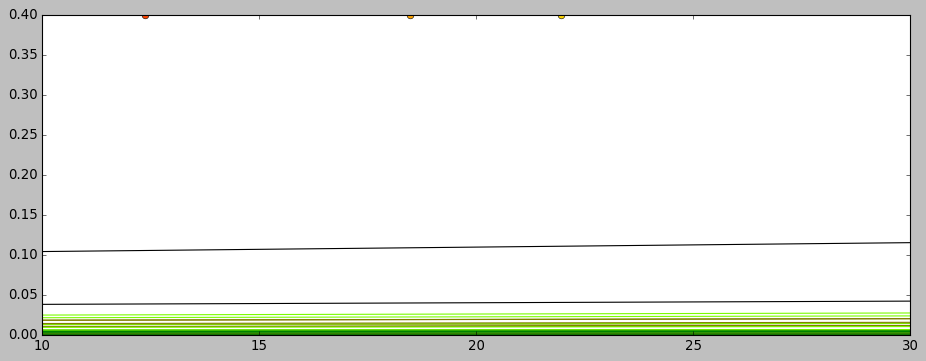

Number Correct:  206
Possible Number of Matches:  233

Event 321: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  89.86486486486487 %


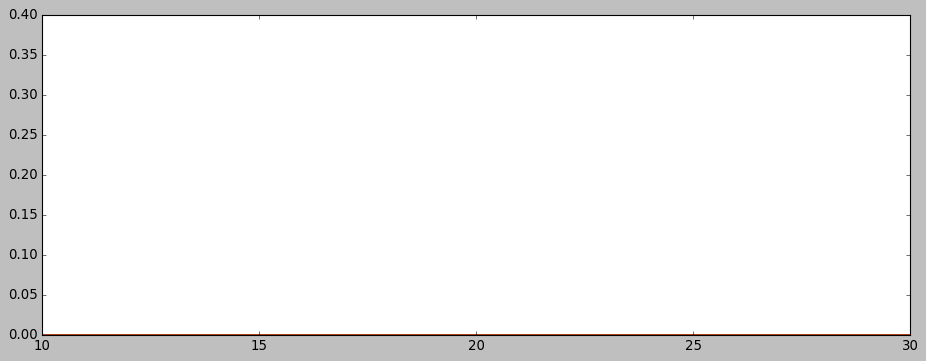

Number Correct:  121
Possible Number of Matches:  162

Event 322: Found 3 of 3, added 1 (eff 100.00%)
Percentage Matched =  87.33333333333333 %


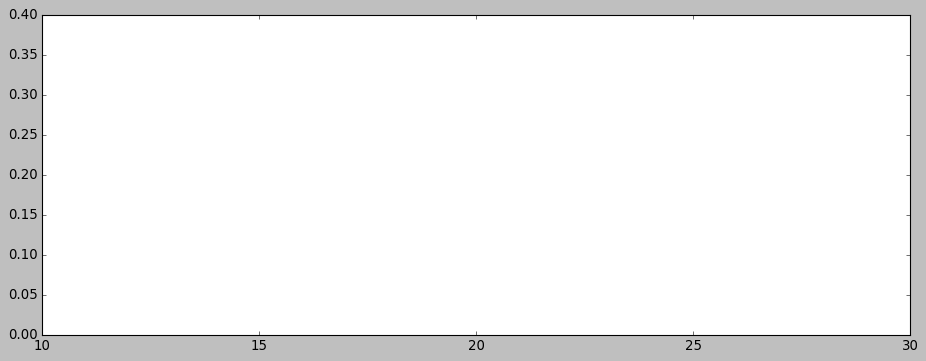

Number Correct:  127
Possible Number of Matches:  165

Event 323: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  84.14634146341463 %


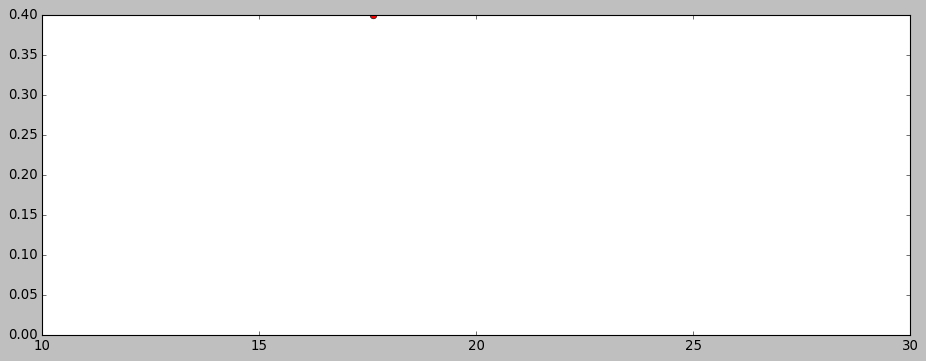

Number Correct:  135
Possible Number of Matches:  139

Event 324: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  88.20960698689956 %


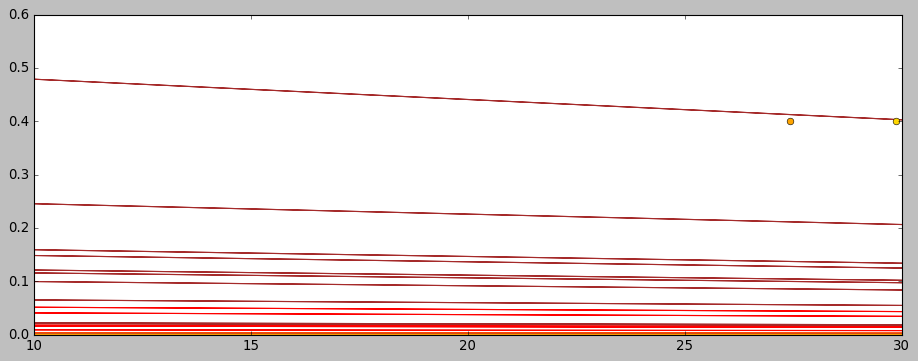

Number Correct:  169
Possible Number of Matches:  201

Event 325: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  90.20408163265306 %


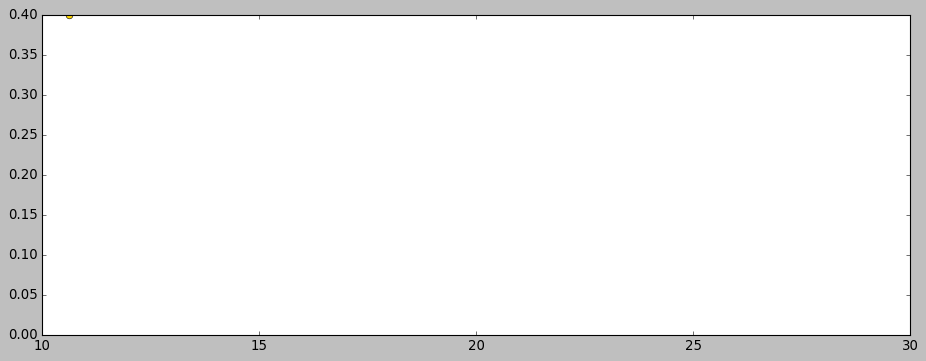

Number Correct:  204
Possible Number of Matches:  220

Event 326: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  88.52459016393442 %


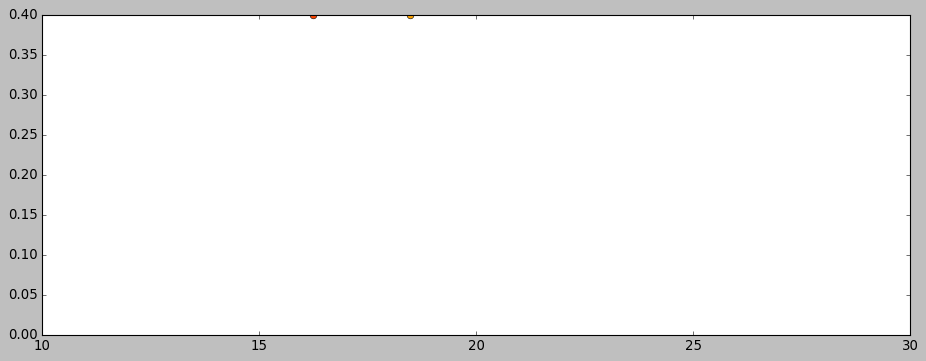

Number Correct:  141
Possible Number of Matches:  163

Event 327: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  92.28295819935691 %


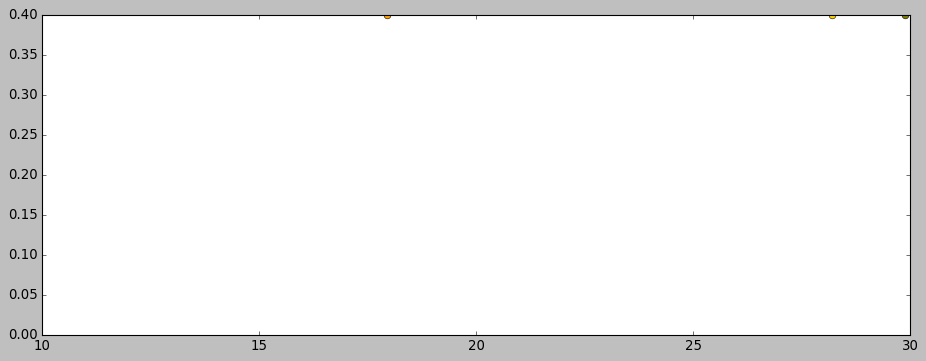

Number Correct:  256
Possible Number of Matches:  290

Event 328: Found 6 of 7, added 1 (eff 85.71%)
Percentage Matched =  92.33576642335767 %


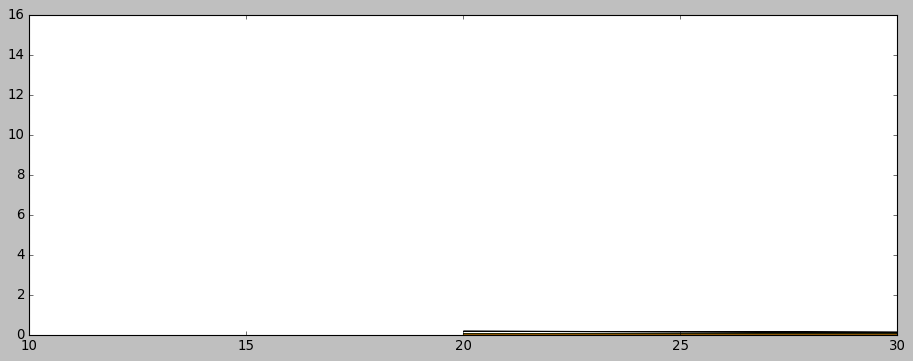

Number Correct:  176
Possible Number of Matches:  207

Event 329: Found 5 of 5, added 0 (eff 100.00%)
Percentage Matched =  63.681592039801 %


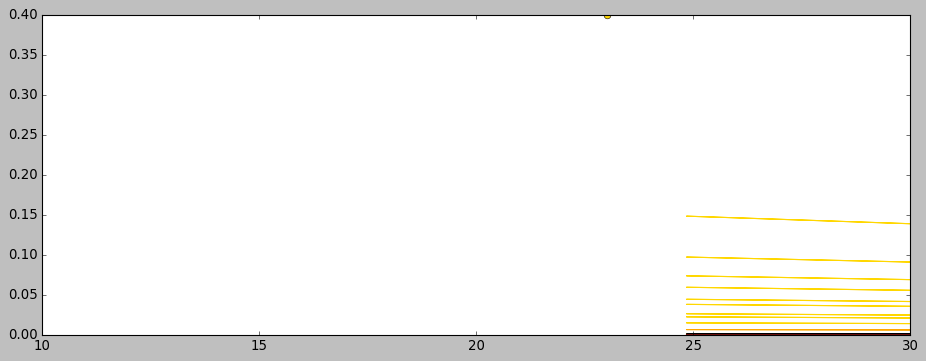

Number Correct:  114
Possible Number of Matches:  124

Event 330: Found 2 of 2, added 0 (eff 100.00%)
Percentage Matched =  78.2051282051282 %


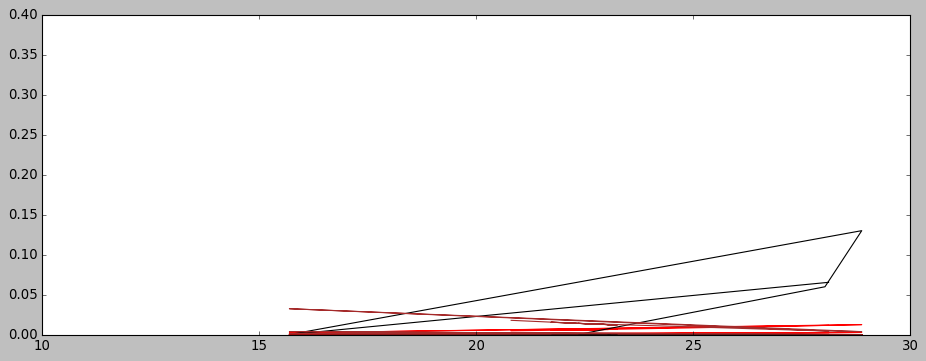

Number Correct:  60
Possible Number of Matches:  63

Event 331: Found 7 of 7, added 0 (eff 100.00%)
Percentage Matched =  79.64601769911505 %


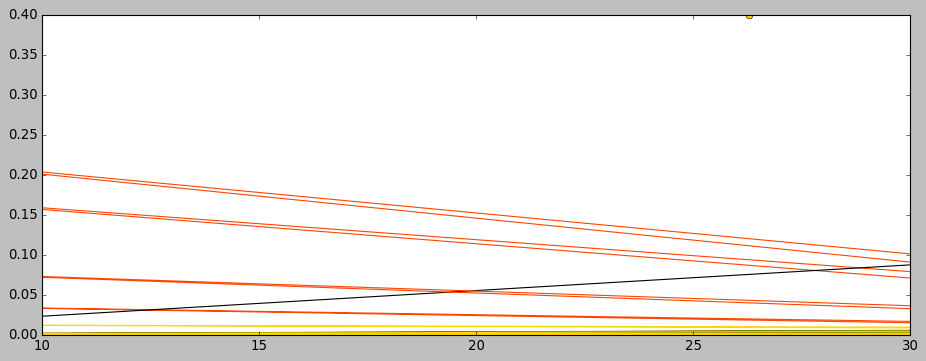

Number Correct:  164
Possible Number of Matches:  178

Event 332: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  90.58441558441558 %


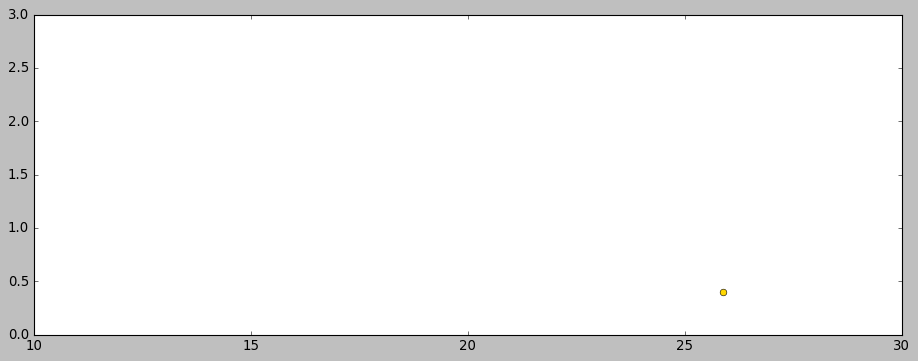

Number Correct:  254
Possible Number of Matches:  276

Event 333: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  86.05442176870748 %


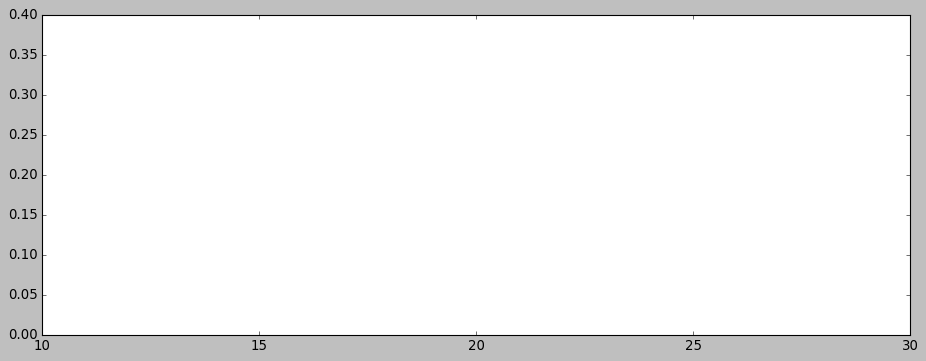

Number Correct:  213
Possible Number of Matches:  257

Event 334: Found 3 of 3, added 0 (eff 100.00%)
Percentage Matched =  43.609022556390975 %


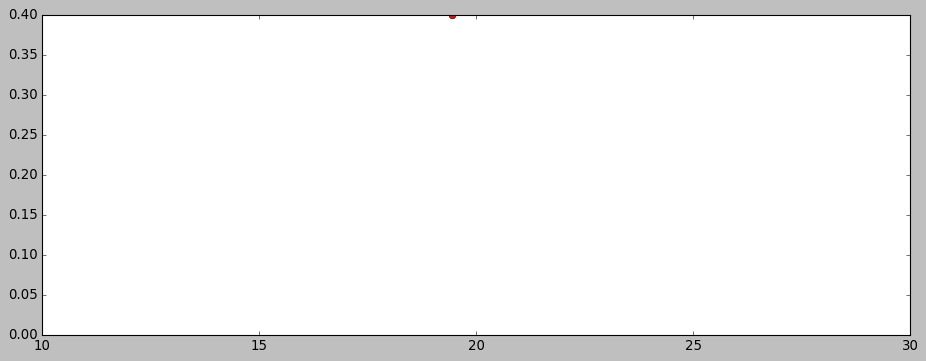

Number Correct:  55
Possible Number of Matches:  55

Event 335: Found 5 of 5, added 4 (eff 100.00%)
Percentage Matched =  91.76136363636364 %


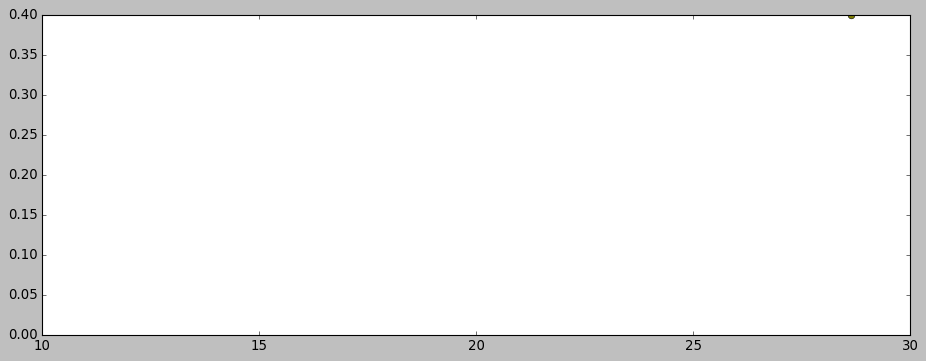

Number Correct:  288
Possible Number of Matches:  435

Event 336: Found 5 of 5, added 1 (eff 100.00%)
Percentage Matched =  85.51401869158879 %


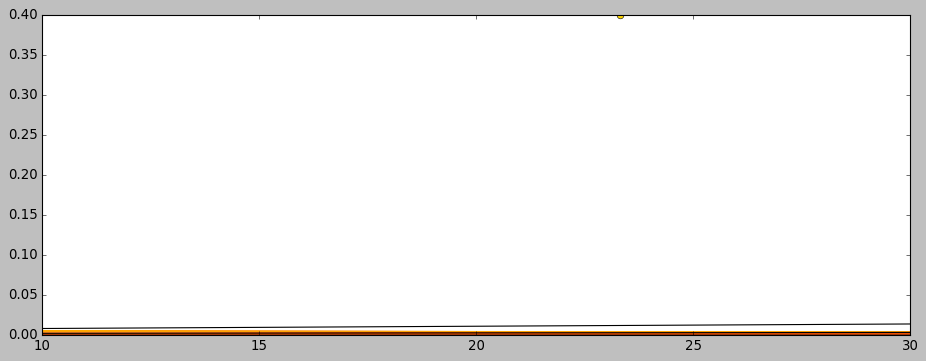

Number Correct:  169
Possible Number of Matches:  183

Event 337: Found 6 of 6, added 0 (eff 100.00%)
Percentage Matched =  87.62886597938144 %


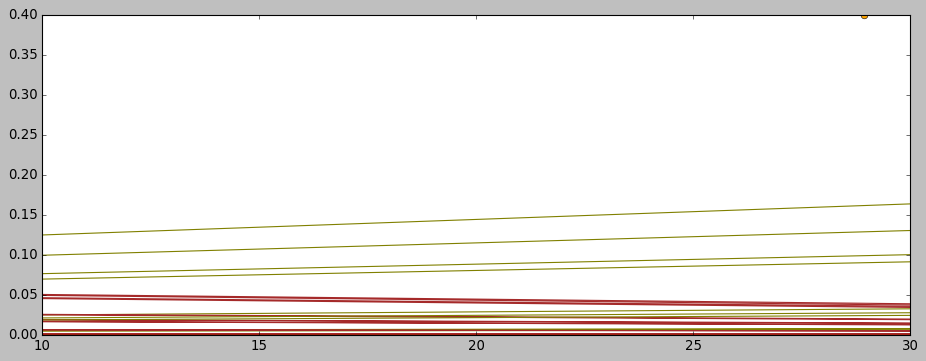

Number Correct:  164
Possible Number of Matches:  171

Event 338: Found 8 of 8, added 0 (eff 100.00%)
Percentage Matched =  89.05660377358491 %


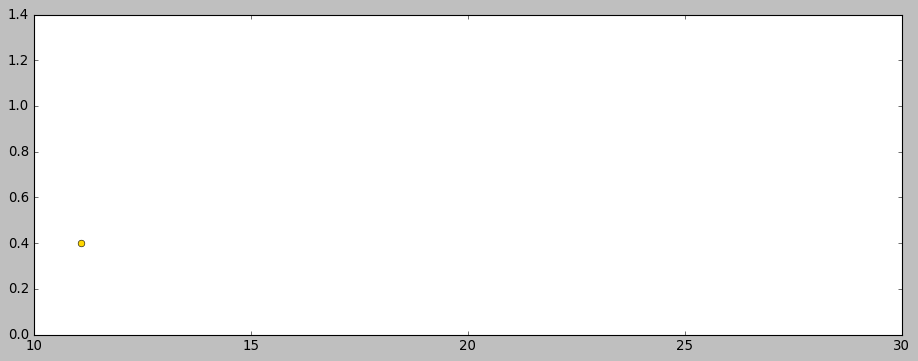

Number Correct:  220
Possible Number of Matches:  240

Event 339: Found 9 of 10, added 0 (eff 90.00%)


KeyboardInterrupt: 

In [13]:
inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05

# initialize arrays/lists
missed_ratio = [] #of unmatched tracks, how many should have been matched to valid PVs
correct_ratio = [] #ratio of correctly matched tracks / total
ratios = np.zeros(test.shape[0]) #ratio of matched tracks / total
stds = [] #keep track of window size used to match tracks
deltazmin_matched = [] #distance of track to PV for matched tracks
deltazmin_unmatched = [] #distance of track to PV for unmatched tracks
deltax_PV = []
deltay_PV = []
deltaz_PV = []

#initialize dictionaries (used to see trends w.r.t. number of tracks per PV)
resolution_dict_z = {}
resolution_dict_x = {}
resolution_dict_y = {}
resolution_dict_z_best = {}
resolution_dict_x_best = {}
resolution_dict_y_best = {}
ratio_dict = {}
resolution_dict_z_pvf = {}

#colors used to show which tracks are matched to which PVs
PV_colors = ['brown','red','orangered','orange','gold','olive','lawngreen','green',
             'springgreen','turquoise','cyan','deepskyblue','dodgerblue','navy','blue',
            'indigo','darkviolet','purple','magenta','deeppink']

# ITERATE THROUGH EACH EVENT
for event in range(test.shape[0]):
    
    n_correct = 0
    n_false = 0
    
    #assign current input, label, and output for event
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficencies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    print(f"\nEvent {event}:", results)
    
    #grab means of predicted PVs
    comp_centroids = (fcomputed / 10) - 100
    
    #find standard deviations of predicted PVs
    std = get_std_resolution(fcomputed, output, 3.5, 0.001, 20, 0)
    std = std/10
    
    #reset these values to zero before iterating through tracks
    n_matched = 0
    n_missed = 0
    
    maxy = 0 #used for plotting
    
    #initialize match dictionaries
    matches = {}
    for i in range(len(comp_centroids)):
        matches[i] = []
        
    unmatched = {}
    for i in range(len(comp_centroids)):
        unmatched[i] = []
    
    minmatched = sys.float_info.max # used for deltaz_minmatched (initialize then update in loop)
    minunmatched = sys.float_info.max # used for deltaz_minunmatched (initialize then update in loop)
    
    heights = np.zeros(len(pocas["z"]["poca"][event])) # used to calculate weights to compute weighted average of matched tracks to reconstruct PVs
    
    plt.figure(figsize=(14, 5))
    
    # ITERATE THROUGH TRACKS
    for j in range(len(pocas["z"]["poca"][event])):
        
        # compute array corresponding to z-projection of POCA ellipsoid, then store max
        current_gauss = gaussian(zvals, pocas["z"]["poca"][event][j], pocas["z"]["major_axis"][event][j])
        heights[j] = 1/(pocas["z"]["major_axis"][event][j]*np.sqrt(2*np.pi))
        
        
        # below used for plotting
        if maxy<heights[j]:
            maxy = heights[j]
            

        # (sometimes, we encounter events where no PVs are found)
        if not len(comp_centroids)==0:
            
            #find PV (and index) with minimum distance to track
            diff = np.abs(np.add(comp_centroids, -pocas["z"]["poca"][event][j]))
            minimum = diff.min()
            ind = np.where(diff == minimum)[0][0]
            
            #calculate and store window with which to decide matching
            std_mod = np.sqrt(pocas["z"]["major_axis"][event][j]**2 + std[ind]**2)
            stds.append(std_mod)
            
            if minimum <= 5*std_mod:
                #uncomment below for plotting
                plt.plot(zvals, current_gauss, color = PV_colors[ind])
                
                
                n_matched += 1 #count number of matched tracks
                matches[ind].append(j) #keep track of match
                
                #below used for deltazmin_matched
                if minimum <= minmatched:
                    minmatched = minimum
            else:
                #uncomment below for plotting
                plt.plot(zvals, current_gauss, color = 'k')
                
                #below used for deltazmin_unmatched
                unmatched[ind].append(j)
                if minimum <= minunmatched:
                    minunmatched = minimum
    
    print("Percentage Matched = ", 100*n_matched/len(pocas["z"]["poca"][event]), "%")
    
    #update lists
    ratios[event] = n_matched/len(pocas["z"]["poca"][event])
    deltazmin_matched.append(minmatched)
    deltazmin_unmatched.append(minunmatched)
    
    
    #uncomment below for plotting (to plot PVs)
    for j in range(len(comp_centroids)):
        plt.plot(comp_centroids[j], np.ones_like(comp_centroids[j])*.4, 'o', color= PV_colors[j], markeredgecolor = 'k')
        
    plt.xlim([10,30])
    #plt.ylim([0,1.2*maxy])
    plt.show()
    
    # initialize arrays to store PV locations calculated from matched track POCAs
    x_guesses = np.zeros(len(comp_centroids))
    y_guesses = np.zeros(len(comp_centroids))
    z_guesses = np.zeros(len(comp_centroids))
    
    n_tracks = np.zeros(len(comp_centroids)) # stores number of matched tracks per PV
    
    key_guesses = [] #stores truth indices of matched tracks
    keys_unmatched = [] #stores truth indices of unmatched tracks
    
    # iterate through dictionary of track matches, plot error ellipses/combined PV ellipse
    for i in matches:
        
#         fig, axs = plt.subplots(3, 
#                                 figsize=(12,24),
#                                 gridspec_kw={'height_ratios':[4,4,4], 'hspace':0.2})
        
        
        centers = np.stack(([pocas["x"]["poca"][event][k] for k in matches[i]],
                            [pocas["y"]["poca"][event][k] for k in matches[i]],
                            [pocas["z"]["poca"][event][k] for k in matches[i]]))
        
        min_z = min(centers[2,:]) - 0.5
        max_z = max(centers[2,:]) + 0.5
        min_x = min(centers[0,:]) - 0.1
        max_x = max(centers[0,:]) + 0.1
        min_y = min(centers[1,:]) - 0.1
        max_y = max(centers[1,:]) + 0.1
        
        major_axes = np.stack(([pocas["x"]["major_axis"][event][k] for k in matches[i]],
                               [pocas["y"]["major_axis"][event][k] for k in matches[i]],
                               [pocas["z"]["major_axis"][event][k] for k in matches[i]]))
        
        minor_axes1 = np.stack(([pocas["x"]["minor_axis1"][event][k] for k in matches[i]],
                               [pocas["y"]["minor_axis1"][event][k] for k in matches[i]],
                               [pocas["z"]["minor_axis1"][event][k] for k in matches[i]]))
        
        minor_axes2 = np.stack(([pocas["x"]["minor_axis2"][event][k] for k in matches[i]],
                               [pocas["y"]["minor_axis2"][event][k] for k in matches[i]],
                               [pocas["z"]["minor_axis2"][event][k] for k in matches[i]]))
        
        #plotEllipses(centers, major_axes, minor_axes1, minor_axes2, fig, axs)
        
        center, major_axis, minor_axis1, minor_axis2 = combine_ellipsoids_approx(centers,
                                                                                 major_axes, 
                                                                                 minor_axes1, 
                                                                                 minor_axes2)
        
        #print('Combined Ellipse Center: ', center)
#         plot_combined_ellipse(center, major_axis, minor_axis1, minor_axis2, fig, axs)
        
#         axs[0].plot(center[0], center[1], '.', color = 'r')
#         axs[1].plot(center[2], center[0], '.', color = 'r')
#         axs[2].plot(center[2], center[1], '.', color = 'r')
        
#         xlim = 0.1
#         ylim = 0.1
#         axs[0].set_xlim([-1.5*xlim,1.5*xlim])
#         axs[0].set_ylim([-1.5*ylim,1.5*ylim])
#         axs[0].set_xlabel('x')
#         axs[0].set_ylabel('y')
#         axs[0].set_title('POCA distribution (x, y)')
#         axs[0].set_aspect('equal')
#         axs[0].set_anchor('W')
            
#         axs[1].set_ylim([-1.5*xlim,1.5*xlim])
#         axs[1].set_xlim([center[2]-5,center[2]+5])
#         axs[1].set_ylabel('x')
#         axs[1].set_xlabel('z')
#         axs[1].set_title('POCA distribution (x, z)')
#         axs[1].set_anchor('W')
            
#         axs[2].set_ylim([-1.5*ylim,1.5*ylim])
#         axs[2].set_xlim([center[2]-5,center[2]+5])
#         axs[2].set_ylabel('y')
#         axs[2].set_xlabel('z')
#         axs[2].set_title('POCA distribution (y, z)')
#         axs[2].set_anchor('W')
        
#         plt.show()
        
        #save guesses
        x_guesses[i] = center[0]
        y_guesses[i] = center[1]
        z_guesses[i] = center[2]
        
        n_tracks[i] = len(matches[i])
        
        key_guesses.append([track_matches[event][j] for j in matches[i]])
        keys_unmatched.append([track_matches[event][j] for j in unmatched[i]])
        
        
    # find the indices of the truth PVs which correspond to the PVs found by pv-finder
    true_ind = np.zeros(len(comp_centroids))
    for j in range(len(comp_centroids)):
        true_ind[j] = min(range(len(PV.z[event])), key=lambda i: abs(PV.z[event][i]-comp_centroids[j]))
    
    # construct arrays corresponding to truth x,y,z positions of PVs and IDs (key)
    true_x = [PV.x[event][int(i)] for i in true_ind]
    true_y = [PV.y[event][int(i)] for i in true_ind]
    true_z = [PV.z[event][int(i)] for i in true_ind]
    true_key = [PV.key[event][int(i)] for i in true_ind]
    
    # find out how many were correctly/falsely matched
    for i in range(len(true_key)):
        for j in range(len(key_guesses[i])):
            if not true_key[i]==key_guesses[i][j]:
                n_false+=1
            else:
                n_correct+=1
        for j in range(len(keys_unmatched[i])):
            if keys_unmatched[i][j] in true_key:
                n_missed+=1
            
    # append to a few macro lists
    if not len(pocas["z"]["poca"][event])-n_matched ==0:
        missed_ratio.append(n_missed/(len(pocas["z"]["poca"][event])-n_matched))
    
    if not n_false + n_correct ==0:
        correct_ratio.append(n_correct/(n_false+n_correct))
        
    print('Number Correct: ', n_correct)
            
    x_guesses_best = np.zeros(len(true_key))
    y_guesses_best = np.zeros(len(true_key))
    z_guesses_best = np.zeros(len(true_key))
    
    n_correct_total = 0
    for i in range(len(true_key)):
        xvals = []
        yvals = []
        zvals = []
        weightvals = []
        for j in range(len(track_matches[event])):
            if track_matches[event][j] == true_key[i]:
                
                center = [pocas["x"]["poca"][event][j], 
                          pocas["y"]["poca"][event][j], 
                          pocas["z"]["poca"][event][j]]
                major_axis = [pocas["x"]["major_axis"][event][j], 
                              pocas["y"]["major_axis"][event][j], 
                              pocas["z"]["major_axis"][event][j]]
                minor_axis1 = [pocas["x"]["minor_axis1"][event][j], 
                              pocas["y"]["minor_axis1"][event][j], 
                              pocas["z"]["minor_axis1"][event][j]]
                minor_axis2 = [pocas["x"]["minor_axis2"][event][j], 
                              pocas["y"]["minor_axis2"][event][j], 
                              pocas["z"]["minor_axis2"][event][j]]
                
                major_axis_mag = np.linalg.norm(major_axis)
                minor_axis1_mag = np.linalg.norm(minor_axis1)
                minor_axis2_mag = np.linalg.norm(minor_axis2)
                
                volume = (4/3)*np.pi*major_axis_mag*minor_axis1_mag*minor_axis2_mag
                
                xvals.append(pocas["x"]["poca"][event][j])
                yvals.append(pocas["y"]["poca"][event][j])
                zvals.append(pocas["z"]["poca"][event][j])
                
                if not volume == 0:
                    weightvals.append(1/volume)
                else: weightvals.append(0)
                
        n_correct_total += len(weightvals)
        
        if len(weightvals)>0:
            x_guesses_best[i] = np.average(xvals, weights = weightvals)
            y_guesses_best[i] = np.average(yvals, weights = weightvals)
            z_guesses_best[i] = np.average(zvals, weights = weightvals)
                
            
    print('Possible Number of Matches: ', n_correct_total)
            
    deltax_PV_best = np.add(true_x, -x_guesses_best).tolist()
    deltay_PV_best = np.add(true_y, -y_guesses_best).tolist()
    deltaz_PV_best = np.add(true_z, -z_guesses_best).tolist()
            
    # compute difference between truth positions and positions calculated using POCAs
    deltax_PV_current = np.add(true_x, -x_guesses).tolist()   
    deltay_PV_current = np.add(true_y, -y_guesses).tolist()
    deltaz_PV_current = np.add(true_z, -z_guesses).tolist()
    
    # append to macro lists
    deltax_PV += deltax_PV_current
    deltay_PV += deltay_PV_current
    deltaz_PV += deltaz_PV_current
    
    # to compare POCA reconstruction to pv-finder (pvf) output
    deltaz_PV_pvf = np.add(true_z, -comp_centroids).tolist()
    
    # UPDATE DICTIONARIES
    for i in range(len(n_tracks)):
        
        if n_tracks[i] in resolution_dict_z:
            resolution_dict_z[n_tracks[i]].append(deltaz_PV_current[i])
        else:
            resolution_dict_z[n_tracks[i]] = [deltaz_PV_current[i]]
        
        if n_tracks[i] in resolution_dict_x:
            resolution_dict_x[n_tracks[i]].append(deltax_PV_current[i])
        else:
            resolution_dict_x[n_tracks[i]] = [deltax_PV_current[i]]
            
        if n_tracks[i] in resolution_dict_y:
            resolution_dict_y[n_tracks[i]].append(deltay_PV_current[i])
        else:
            resolution_dict_y[n_tracks[i]] = [deltay_PV_current[i]]
            
        if n_tracks[i] in resolution_dict_z_best:
            resolution_dict_z_best[n_tracks[i]].append(deltaz_PV_best[i])
        else:
            resolution_dict_z_best[n_tracks[i]] = [deltaz_PV_best[i]]
        
        if n_tracks[i] in resolution_dict_x_best:
            resolution_dict_x_best[n_tracks[i]].append(deltax_PV_best[i])
        else:
            resolution_dict_x_best[n_tracks[i]] = [deltax_PV_best[i]]
            
        if n_tracks[i] in resolution_dict_y_best:
            resolution_dict_y_best[n_tracks[i]].append(deltay_PV_best[i])
        else:
            resolution_dict_y_best[n_tracks[i]] = [deltay_PV_best[i]]
            
        if n_tracks[i] in ratio_dict:
            ratio_dict[n_tracks[i]].append(ratios[event])
        else:
            ratio_dict[n_tracks[i]] = [ratios[event]]
            
        if n_tracks[i] in resolution_dict_z_pvf:
            resolution_dict_z_pvf[n_tracks[i]].append(deltaz_PV_pvf[i])
        else:
            resolution_dict_z_pvf[n_tracks[i]] = [deltaz_PV_pvf[i]]
            
    # uncomment below for plotting
#    plt.plot(x_guesses, y_guesses, 'o', color = 'g', label = "from POCA")
#     plt.plot(true_x, true_y, 'o', color = 'b', label = "truth")
#     plt.legend()
#     title = f"\nEvent {event}:" + str(results)
#     plt.title(title)
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show()


In [ ]:
nums_z = []
widths_z = []
unc_z = []

nums_x = []
widths_x = []
unc_x = []

nums_y = []
widths_y = []
unc_y = []

nums_z_best = []
widths_z_best = []
unc_z_best = []

nums_x_best = []
widths_x_best = []
unc_x_best = []

nums_y_best = []
widths_y_best = []
unc_y_best = []

nums_z_pvf = []
widths_z_pvf = []
unc_z_pvf = []


for n in sorted(resolution_dict_z.keys())[5:]:
    
    
    bins = np.arange(-1,1,0.01)
    vals, bins, patches = plt.hist(resolution_dict_z[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-1,1,0.005)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta z_{PV}$ for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_z.append(n)
    widths_z.append(abs(coeff[2]))
    unc_z.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-1,1,0.01)
    vals, bins, patches = plt.hist(resolution_dict_z_best[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-1,1,0.005)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta z_{PV}$ (Best) for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_z_best.append(n)
    widths_z_best.append(abs(coeff[2]))
    unc_z_best.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-1,1,0.01)
    vals, bins, patches = plt.hist(resolution_dict_z_pvf[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-1,1,0.005)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta z_{PV}$ (pv-finder) for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_z_pvf.append(n)
    widths_z_pvf.append(abs(coeff[2]))
    unc_z_pvf.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-0.2,0.2,0.002)
    vals, bins, patches = plt.hist(resolution_dict_x[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-0.2,0.2,0.001)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta x_{PV}$ for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_x.append(n)
    widths_x.append(abs(coeff[2]))
    unc_x.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-0.2,0.2,0.002)
    vals, bins, patches = plt.hist(resolution_dict_x_best[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-0.2,0.2,0.001)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta x_{PV}$ (Best) for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_x_best.append(n)
    widths_x_best.append(abs(coeff[2]))
    unc_x_best.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-0.2,0.2,0.002)
    vals, bins, patches = plt.hist(resolution_dict_y[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-0.2,0.2,0.001)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta y_{PV}$ for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_y.append(n)
    widths_y.append(abs(coeff[2]))
    unc_y.append(np.sqrt(np.abs(var_matrix[2,2])))
    
    bins = np.arange(-0.2,0.2,0.002)
    vals, bins, patches = plt.hist(resolution_dict_y_best[n],bins=bins)
    coeff, var_matrix = curve_fit(gauss_fitfunction, bins[:-1], vals, p0=[10,0,0.1])
    xfit = np.arange(-0.2,0.2,0.001)
    plt.plot(xfit, gauss_fitfunction(xfit,coeff[0],coeff[1],coeff[2]),'-',color='r',linewidth=2)
    title = '$\Delta y_{PV}$ (Best) for PVs with ' + str(n) + ' Tracks'
    plt.title(title)
    plt.show()
    
    nums_y_best.append(n)
    widths_y_best.append(abs(coeff[2]))
    unc_y_best.append(np.sqrt(np.abs(var_matrix[2,2])))

In [ ]:
plt.errorbar(nums_z[:90], widths_z[:90], xerr = 1/2, yerr = np.array(unc_z[:90]), marker = '.', linestyle = '', color = 'b')
plt.errorbar(nums_z_pvf[:90], widths_z_pvf[:90], xerr = 1/2, yerr = np.array(unc_z_pvf[:90]), marker = '.', linestyle = '', color = 'r')
plt.errorbar(nums_z_best[:90], widths_z_best[:90], xerr = 1/2, yerr = np.array(unc_z_best[:90]), marker = '.', linestyle = '', color = 'g')
plt.legend(['POCA', 'PV-Finder', 'Truth'])
plt.xlim([0,90])
plt.ylim([0,1.15*max(widths_z[:70])])
plt.ylabel('Resolution (mm)')
plt.xlabel('Number of Tracks Associated with PV')
plt.title('PV Resolution (z-direction) from Different Reconstruction Methods')
plt.show()

plt.errorbar(nums_x[:90], widths_x[:90], xerr = 1/2, yerr = np.array(unc_x[:90]), marker = '.', linestyle = '', color = 'b')
plt.errorbar(nums_x_best[:90], widths_x_best[:90], xerr = 1/2, yerr = np.array(unc_x_best[:90]), marker = '.', linestyle = '', color = 'g')
plt.legend(['POCA', 'Truth'])
plt.xlim([0,90])
plt.ylim([0,1.15*max(widths_x[:70])])
plt.ylabel('Resolution (mm)')
plt.xlabel('Number of Tracks Associated with PV')
plt.title('PV Resolution (x-direction) from Different Reconstruction Methods')
plt.show()

plt.errorbar(nums_y[:90], widths_y[:90], xerr = 1/2, yerr = np.array(unc_y[:90]), marker = '.', linestyle = '', color = 'b')
plt.errorbar(nums_y_best[:90], widths_y_best[:90], xerr = 1/2, yerr = np.array(unc_y_best[:90]), marker = '.', linestyle = '', color = 'g')
plt.legend(['POCA', 'Truth'])
plt.xlim([0,90])
plt.ylim([0,1.15*max(widths_y[:70])])
plt.ylabel('Resolution (mm)')
plt.xlabel('Number of Tracks Associated with PV')
plt.title('PV Resolution (y-direction) from Different Reconstruction Methods')
plt.show()

In [ ]:
n_vals = ratio_dict.keys()
ratios = np.zeros(len(n_vals))
unc = np.zeros(len(n_vals))
for i,n in enumerate(n_vals):
    ratios[i] = np.average(ratio_dict[n])
    unc[i] = 1/np.sqrt(len(ratio_dict[n]))
plt.figure(figsize=(14, 5))
plt.errorbar(n_vals, ratios, xerr = 1/2, yerr = unc, linestyle = '', marker = '.')
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('Number of Tracks Associated with PV')
plt.ylabel('Ratio of Correctly Matched Tracks/Total')
plt.show()

In [ ]:
plt.hist(correct_ratio,bins=50)
plt.title("Ratio of Tracks Matched Correctly / Total Matched Tracks")
plt.show()

plt.hist(missed_ratio,bins=50)
plt.title("Ratio of Unmatched Tracks which belong to a valid PV to Total Unmatched Tracks")
plt.show()

In [ ]:
plt.hist(ratios, bins=50)
plt.title("Ratio of Matched Tracks/Total")
plt.show()

sbins = np.arange(0.01,10.01,0.1)
plt.hist(5*stds, bins=sbins)
plt.title("Values of 5$\sigma$")
plt.show()

plt.hist(deltazmin_matched, bins=50, range=[0,0.05])
plt.title("$\Delta z$ min for matched tracks")
plt.show()

plt.hist(deltazmin_unmatched, bins=50, range=[0,10])
plt.title("$\Delta z$ min for unmatched tracks")
plt.show()

In [ ]:
print(stds[0:100])